# **Quantum-Classical Parameter Mapping - Results**

In this Jupyter notebook, we aim to numerically analyze the mapping of parameters between a QM Equilibrium Ising model and a toy binary stochastic dynamics. The Quantum Boltzmann Machine [1]. It can be used to encode classical data, as described in [2]. The Boltzmann machine and general info on dynamics and inverse mapping can be found in [3].

Note: This notebook provides no further explanation for the code. It is mainly useful for generating results. For a more detailed explanation of the code and tests see the notebook `Quantum-Classical Mapping - Explanation.ipynb` notebook

[1] Amin, Mohammad H., et al. "Quantum boltzmann machine." Physical Review X 8.2 (2018): 021050.  
[2] Kappen, Hilbert J. "Learning quantum models from quantum or classical data." Journal of Physics A: Mathematical and Theoretical 53.21 (2020): 214001.  
[3] Nguyen, H. Chau, Riccardo Zecchina, and Johannes Berg. "Inverse statistical problems: from the inverse Ising problem to data science." Advances in Physics 66.3 (2017): 197-261.


In [265]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import math
import re
from numba import njit
from itertools import product
from scipy.linalg import kron
from typing import Tuple, Optional, Dict, List
from numba.typed import List
from matplotlib import rc

## **Implementation of toy dynamics**

In [271]:
###  CONVERTING SPIN <-> BINARY FUNCTIONS
#----------------------------------------------------------------------
@njit
def index_to_spin_state(s_idx: int, N: int) -> np.ndarray:
    """Convert an index to a spin state."""
    s = np.zeros((N,), dtype=np.int64)
    for i in range(N):
        # get the ith bit of s_idx.
        bit = (s_idx >> i) & 1
        # convert the bit to a spin (-1 or 1).
        s[N - 1 - i] = bit * 2 - 1
    return s

@njit
def spin_state_to_index(s: np.ndarray) -> int:
    """Convert a spin state to an index."""
    N = len(s)
    s_idx = 0
    for i in range(N):
        # convert the spin to a bit (0 or 1).
        bit = (s[i] + 1) // 2
        # set the ith bit of s_idx.
        s_idx |= bit << (N - 1 - i)
    return s_idx

@njit
def bits_flipped_indices(s_idx: int, flip_index: int, N: int) -> List[int]:
    """Return the indices of the bits that are flipped when going from s_idx to flip_index."""
    flipped_bits = s_idx ^ flip_index
    flipped_indices = []
    for k in range(N):
        if (flipped_bits & (1 << k)) != 0:
            flipped_indices.append(N - 1 - k)
    return flipped_indices

@njit
def steady_state(A):
    """Calculates the steady state of a (left) stochastic matrix"""
    # compute eigenvalues and corresponding eigenvectors for the transposed matrix
    eigenvalues, eigenvectors = np.linalg.eig(A.T)
    
    # get the eigenvector corresponding to eigenvalue 1 (the steady state)
    steady_state = np.abs(np.real(eigenvectors[:, np.argmax(np.real(eigenvalues))]))
    
    # normalize the vector to get a probability distribution
    steady_state = steady_state / np.sum(steady_state)

    return steady_state.flatten()

In [272]:
@njit
def steady_state(A):
    """Calculates the steady state of a (left) stochastic matrix"""
    # convert to complex128 to avoid numba domain change errors
    A = A.astype(np.complex128)

    # compute eigenvalues and corresponding eigenvectors for the transposed matrix
    eigenvalues, eigenvectors = np.linalg.eig(A.T)
    
    # get the eigenvector corresponding to eigenvalue 1 (the steady state)
    steady_state = np.abs(np.real(eigenvectors[:, np.argmax(np.real(eigenvalues))]))
    
    # normalize the vector to get a probability distribution
    steady_state = steady_state / np.sum(steady_state)
    steady_state = steady_state.astype(np.float64)
    
    return steady_state.flatten()

In [273]:
### AUXILARY SIMULATION FUNCTIONS
#----------------------------------------------------------------------
@njit
def g_single(i: int, from_idx: int, to_idx: int, s: np.ndarray, w: np.ndarray, h: np.ndarray, J: np.ndarray):
    """Calculates the single flip probability."""
    sum_Js = np.sum(J[i, :] * s)
    return np.exp(-w[from_idx, to_idx] - s[i] * (h[i] + sum_Js))

@njit
def g_double(i: int, j: int, from_idx: int, to_idx:int, s: np.ndarray, w: np.ndarray, h: np.ndarray, J: np.ndarray):
    """Calculates the double flip probability"""
    sum_Js_i = np.sum(J[i, :] * s) - J[i, j] * s[j]
    sum_Js_j = np.sum(J[j, :] * s) - J[i, j] * s[i]

    return np.exp(-w[from_idx, to_idx] + J[i, j] * s[i] * s[j] - s[i] * (sum_Js_i + h[i]) - s[j] * (sum_Js_j + h[j]))

@njit
def choice(probabilities: np.ndarray) -> int:
    """A workaround for np.random.choice, which is unsupported by numba"""
    cumulative_distribution = np.cumsum(probabilities)
    return np.searchsorted(cumulative_distribution, np.random.random(), side ="right")

In [274]:
@njit
def compute_transition_matrix(w: np.ndarray, h: np.ndarray, J: np.ndarray) -> np.ndarray:
    """Computes the transition matrix for the given parameters."""
    N = len(h)  # number of spins in the lattice
    transition_matrix = np.zeros((2**N, 2**N))

    #sum over rows to fill
    for from_idx in range(2**N):
        s = index_to_spin_state(from_idx, N)
        flip_probs = np.zeros((2**N))  # initialize with zeros

        for i in range(N):
            to_index = from_idx ^ (1 << i)
            i_flipped = bits_flipped_indices(from_idx, to_index, N)[0]
            flip_probs[to_index] = g_single(i_flipped, from_idx, to_index, s, w, h, J)  # single flip probabilities

        for i in range(N):
            for j in range(i+1, N):
                to_index = from_idx ^ (1 << i) ^ (1 << j)
                i_flipped, j_flipped = bits_flipped_indices(from_idx, to_index, N)
                flip_probs[to_index] = g_double(i_flipped, j_flipped, from_idx, to_index, s, w, h, J)  # double flip probabilities

       # add the no-flip probability and store the flipping probabilities
        no_flip_prob = 1 - sum(flip_probs)
        flip_probs[from_idx] = no_flip_prob
        transition_matrix[from_idx] = flip_probs

    return transition_matrix

In [275]:
def set_w_zero(w, N):
    """Sets diagonal and self-interactions for more than 2 spin flips to zero"""
    np.fill_diagonal(w, 0)
    for from_idx in range(2**N):
        s = index_to_spin_state(from_idx, N)
        for to_idx in range(2**N):
            flipped_indices = bits_flipped_indices(from_idx, to_idx, N)
            if len(flipped_indices) > 2:  
                w[from_idx, to_idx] = 0
    return w

def check_w(w, h, J, step_size = 1e-4, no_flip_prob = 0):
    """Checks if w gives rise to a proper normalized W. Prints the minimal value of w required if it's not the case"""
    min_scalar = 0
    W = compute_transition_matrix(w, h, J)
    self_probs = np.diag(W.copy())

    if np.all(self_probs >= no_flip_prob):
        return
    else:
        self_probs_old = self_probs.copy()
        while True:
            new_w      = w + np.ones(w.shape) * min_scalar
            W          = compute_transition_matrix(new_w, h, J)
            self_probs = np.diag(W)

            # check if the self-transition probabilities are all at least no_flip_prob
            if np.all(self_probs >= no_flip_prob):
                break

            # if the condition is not met, increase the scalar value and try again
            min_scalar += step_size

        assert np.all(self_probs_old >= no_flip_prob), f"Need to use larger w matrix: \n {new_w} "

def check_parameters(w, J, h):
    """Check if parameters are chosen to give rise to a normalized W that satisfies detailed balance"""
    check_w(w, h, J)
    assert np.allclose(J, J.T) and np.all(w.diagonal() == 0) and np.all(J.diagonal() == 0),  "J should be symmetric and J and w should have a zero diagonal"


def check_detailed_balance(W):
    """
    Check if the transition matrix W and stationary distribution pi satisfy the detailed balance condition.
    """
    pi = steady_state(W)
    n_states = W.shape[0]
    for i in range(n_states):
        for j in range(n_states):
            assert np.isclose(W[i, j] * pi[i], W[j, i] * pi[j]), "Transition matrix does not satisfy detailed balance"


def test_transition_matrix(W):
    """Test that the sum of the probabilities in each row of the transition matrix is 1 and there are no negative elements."""
    for row in W:
        assert np.isclose(np.sum(row), 1), "Row sums to " + str(np.sum(row))
        assert np.all(row >= 0), "Negative probability in row " + str(row)

In [276]:
###  SIMULATION FUNCTIONS
#----------------------------------------------------------------------
@njit
def spin_flip(s: np.ndarray, transition_matrix: np.ndarray) -> np.ndarray:
    """ Flipping algorithm, uses precomputed transition matrix. """
    N = len(s)  # number of spins in the lattice

    # calculate the index of the current state in the transition matrix
    from_idx = spin_state_to_index(s)

    # get probabilities from transition matrix
    flip_probs = transition_matrix[from_idx]

    # randomly choose a spin flip according to its probability of occurring
    to_idx = choice(flip_probs)

    # apply the chosen spin flip
    flipped_indices = bits_flipped_indices(from_idx, to_idx, N)
    
    if len(flipped_indices)   == 0:  # no flip
        pass
    elif len(flipped_indices) == 1:  # single flip
        i = flipped_indices[0]
        s[i] *= -1
    elif len(flipped_indices) == 2:  # double flip
        i, j = flipped_indices
        s[i] *= -1
        s[j] *= -1
    elif len(flipped_indices) == 3:  # triple flip
        i, j, k = flipped_indices
        s[i] *= -1
        s[j] *= -1
        s[k] *= -1
    elif len(flipped_indices) == 4:  # quadruple flip
        i, j, k, l = flipped_indices
        s[i] *= -1
        s[j] *= -1
        s[k] *= -1
        s[l] *= -1

    return s

@njit
def simulate_dynamics(W: np.ndarray, steps: int, N: int, s = None) -> np.ndarray:
    """Simulates the dynamics of the system for the given number of steps."""

    if s is None:
        s = np.ones(N, dtype=np.int64)
    trajectory = np.empty((steps, N), dtype=np.int64)

    for t in range(steps):
        s = spin_flip(s, W)
        trajectory[t] = s

    return trajectory

In [277]:
@njit
def infer_transition_matrix(trajectory: np.ndarray) -> np.ndarray:
    """Infers the transition matrix from a time series of the states of the system"""
    N = trajectory.shape[1]  # number of spins in the lattice
    steps = trajectory.shape[0]  # number of steps in the trajectory
    transition_matrix = np.zeros((2**N, 2**N))

    for t in range(steps - 1):
        # convert the spin states to indices
        s_idx = spin_state_to_index(trajectory[t])
        next_s_idx = spin_state_to_index(trajectory[t + 1])

        # increment the corresponding cell in the transition matrix
        transition_matrix[s_idx, next_s_idx] += 1

    # normalize each row to get probabilities
    for i in range(2**N):
        row_sum = np.sum(transition_matrix[i])
        if row_sum > 0:  # avoid division by zero
            transition_matrix[i] /= row_sum

    return transition_matrix

## **Implementation of the Boltzmann Machine**

In [10]:
###  BOLTZMANN MACHINE AUXILARY FUNCTIONS
#----------------------------------------------------------------------
def all_possible_configs(N: int) -> np.ndarray:
    '''Generates a 2^N by N matrix with all possible configurations of a binary spin system of size N'''
    configs = np.zeros((2**N,N))
    for i in range(2**N):
        config = np.array([1 if x == '1' else -1 for x in np.binary_repr(i, width=N)])
        configs[i] = config
    return configs

@njit
def calcEnergy(config: np.ndarray, J: np.ndarray, h: np.ndarray) -> float:
    '''Calculates the energy of a given configuration'''
    config_float = config.astype(np.float64)  # convert config to float
    energy = -np.dot(config_float.T, np.dot(J, config_float)) / 2 - np.dot(h, config_float)
    return energy

@njit
def calcMag(config: np.ndarray) -> float:
    ''' Magnetizations of a given configuration '''
    return np.sum(config)

@njit
def calcCorr(config: np.ndarray) -> np.ndarray: 
    '''Calculates the spin-spin correlations of a given configuration. Returns a NxN matrix with the correlations'''
    return np.outer(config, config.T)

@njit
def log_likelihood(p: np.ndarray, J: np.ndarray, h: np.ndarray, configs: np.ndarray) -> float:
    """Calculates the log-likelihood of the system under the Boltzmann distribution."""
    Z = 0
    for config in configs:
        Ene = calcEnergy(config, J, h)
        Z += np.exp(-Ene)
    logZ = np.log(Z)

    log_likelihood = 0
    for i, config in enumerate(configs):
        Ene = calcEnergy(config, J, h)
        log_likelihood += p[i] * (-Ene - logZ)

    return log_likelihood

In [11]:
###  BOLTZMANN MACHINE FUNCTIONS
#----------------------------------------------------------------------
@njit
def ising_solve_exact_simplified(N: int, J: np.ndarray, h: np.ndarray, configs: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:    
    '''Calculates the free statistics for a single temperature using exact calculation'''
    beta = 1.0
    Z, C1, C2  = 0, np.zeros((N)), np.zeros((N,N))    #  initialize arrays to store variables                       
                                           
    for config in configs:
        Ene  = calcEnergy(config,J,h)
        Corr = calcCorr(config) 
        p    = np.exp(-beta * Ene)                    #  non-normalized probability of this  configuration at this temperature
        Z  +=  p                                        
        C1 +=  p * config                               
        C2 +=  p * Corr

    Ci   = C1 / Z
    CiCj = C2 / Z
        
    return Ci,CiCj

@njit
def classical_boltzmann_machine(p: np.ndarray, N: int, configs: np.ndarray, maxiter: int, learning_rate: float, tol: float = 1e-14) -> Tuple[np.ndarray, np.ndarray, List[np.ndarray], List[np.ndarray], List[float]]:
    '''Solves the inverse Ising problem. Returns weight matrices that generated the clamped statistics 
    and the inferred weight matrix'''
    J_assym = 2.0 * np.random.random((N, N)) - 1.0   # random initial values between -1 and 1
    J = (J_assym+ J_assym.T)/2                       # symmetrize the random matrix 
    np.fill_diagonal(J, 0)                           # set diagonal of J to 0 to ensure detailed balance
    h = 2.0 * np.random.random(N) - 1.0              # random initial values between -1 and 1

    J = J.astype(np.float64)
    h = h.astype(np.float64)

    # compute the expected spin values
    Ci_clamp = np.dot(p, configs)

    # compute the expected spin-spin correlations
    CiCj_clamp = configs.T @ np.diag(p) @ configs
        
    #  initialize gradient ascent values  
    it    = 0
    delta_J = np.inf
    delta_h = np.inf
    # old_log_likelihood = -np.inf

    # initialize lists to store the values of the parameters and the log-likelihood at each iteration
    J_values = []
    h_values = []
    log_likelihood_values = []
    
    while (it < maxiter and (delta_J > tol or delta_h > tol)):    #  start gradient ascent
        it += 1

        #generate free statistics based on type of solver
        Ci_free, CiCj_free = ising_solve_exact_simplified(N, J, h, configs) 

        # compute the updates for J and h
        delta_J = learning_rate * (CiCj_clamp - CiCj_free)
        delta_h = learning_rate * (Ci_clamp   - Ci_free)
            
        h     = h + delta_h               #  update weight matrix based on statistics  
        J     = J + delta_J
        
        # compute the magnitude of the updates
        delta_J = np.linalg.norm(delta_J)
        delta_h = np.linalg.norm(delta_h)

        # calculate the log-likelihood and check for convergence
        new_log_likelihood = log_likelihood(p, J, h, configs)
        # if np.abs(new_log_likelihood - old_log_likelihood) < tol:
        #     break
        # old_log_likelihood = new_log_elikelihood

        # store the current values of the parameters and the log-likelihood
        J_values.append(J)
        h_values.append(h)
        log_likelihood_values.append(new_log_likelihood)
        
    return J, h, J_values, h_values, log_likelihood_values

In [12]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot_scatter(ax, x, y, xlabel, ylabel, color, size=10):
    '''Creates a scatter subplot'''
    ax.scatter(x, y, s=size, marker='o', color=color)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_yscale('log')

def plot_convergence(J_values, h_values, log_likelihood_values, title='Convergence Plots', size=10):
    '''Plots the convergence of the parameters and the log-likelihood.'''
    it = len(J_values)
    its = np.arange(1, it+1, 1)
    its_diff = np.arange(1, it, 1)

    J_diff = np.diff(J_values, axis=0)
    h_diff = np.diff(h_values, axis=0)

    J_max = np.linalg.norm(J_diff, axis=(1,2))
    h_max = np.linalg.norm(h_diff, axis=1)

    fig = plt.figure(figsize=(25, 6));    #  make plots
    fig.suptitle(title, fontsize=30, y = 1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)

    ax1 = fig.add_subplot(1, 3, 1)
    plot_scatter(ax1, its_diff , J_max, "Iterations", r"$ (\Delta h)_{max}$", "IndianRed", size)
    ax1.text(0, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
    
    ax2 = fig.add_subplot(1, 3, 2)
    plot_scatter(ax2, its_diff , h_max, "Iterations", r"$ (\Delta J)_{max}$ ", "SteelBlue", size)
    ax2.text(0, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
    
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.scatter(its, log_likelihood_values, s=size, marker='o', color="Coral")
    ax3.set_xlabel("Iterations", fontsize=20)
    ax3.set_ylabel("Log Likelihood", fontsize=20)
    ax3.text(0, 1.0, 'C.)', transform=ax3.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

In [13]:
def compute_w(W: np.ndarray, J: np.ndarray, h: np.ndarray) -> np.ndarray:
    """Computes the parameters w from the flip probabilities, J, h, and the spin states."""
    # Initialize w with zeros
    N = len(h)
    w = np.zeros((2**N, 2**N), dtype = np.float64)

    #sum over rows to fill
    for from_idx in range(2**N):
        s = index_to_spin_state(from_idx, N)
        for to_idx in range(2**N):
            # calculate w_ii
            flipped_indices = bits_flipped_indices(from_idx, to_idx, N)
            
            if len(flipped_indices) == 0:  # no flip; self-transition
                # w[from_idx, to_idx] = ???
                pass

            elif len(flipped_indices) == 1:  # single flip, compute wii
                i = flipped_indices[0]
                sum_Js = np.sum(J[i, :] * s)
                w[from_idx, to_idx] = -np.log(W[from_idx,to_idx] + 1e-10) - s[i] * (h[i] + sum_Js)
            elif len(flipped_indices) == 2:  # double flip, compute wij
                j, i = flipped_indices
                sum_Js_i = np.sum(J[i, :] * s) - J[i, j] * s[j]
                sum_Js_j = np.sum(J[j, :] * s) - J[i, j] * s[i]
                w[from_idx, to_idx] = -np.log(W[from_idx,to_idx]+ 1e-10) + J[i, j] * s[i] * s[j] - s[i] * (sum_Js_i + h[i]) - s[j] * (sum_Js_j + h[j])
            
            else: # triple or more flip
                pass

    return w

def infer_parameters(W: np.ndarray, maxiter: int = 2**20, learning_rate: float = 0.1, tolerance = 1e-10, plot = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Infers the parameters w, h, J from a given transition matrix."""
    N = int(np.log2(W.shape[0]))

    # infer the equilibrium distribution p from W
    p = steady_state(W)

    # run the Boltzmann machine
    configs = all_possible_configs(N)
    J, h, J_values, h_values, log_likelihood_values = classical_boltzmann_machine(p, N, configs, maxiter, learning_rate, tolerance )

    w = compute_w(W, J, h)

    if plot == True:
        plot_convergence(J_values, h_values, log_likelihood_values, title = 'BM Convergence')

    return w, J, h

## **Implementation of quantum Hamiltonian**

In [14]:
# define the Pauli matrices globally
PAULI_I = np.array([[1, 0], [0, 1]],    dtype=np.complex128)
PAULI_X = np.array([[0, 1], [1, 0]],    dtype=np.complex128)
PAULI_Y = np.array([[0, 1j], [-1j, 0]], dtype=np.complex128)
PAULI_Z = np.array([[-1, 0], [0, 1]],   dtype=np.complex128)

# create an array of Pauli matrices and their labels
PAULI_MATRICES = np.array([PAULI_I, PAULI_X, PAULI_Y, PAULI_Z], dtype=np.complex128)
PAULI_LABELS = ['I', 'X', 'Y', 'Z']

def tensor_product(matrices: List[np.ndarray]) -> np.ndarray:
    """Compute the tensor product of a list of matrices."""
    result = matrices[0]
    # iterate over each matrix in the list starting from the second one
    for matrix in matrices[1:]:
        result = kron(result, matrix)
    return result
 
def generate_interaction_matrices(num_qubits: int) -> Tuple[np.ndarray, np.ndarray, Dict[Tuple[str, ...], Optional[float]]]:
    """Constructs the tensor product of Pauli matrices for each qubit pair."""
    num_combinations = 4 ** num_qubits # total number of combinations of Pauli matrices for num_qubits
    interaction_matrices = np.empty((num_combinations, 2 ** num_qubits, 2 ** num_qubits), dtype=np.complex128) 
    interaction_labels = np.empty((num_combinations, num_qubits), dtype=object)

    # initialize an empty dictionary to store the weights associated with each interaction matrix
    interaction_weights = {}

    # enumerate over all possible combinations of Pauli matrices for num_qubits
    for idx, matrix_indices in enumerate(product(range(4), repeat=num_qubits)):
        # select the corresponding Pauli matrices for the current combination
        matrices = PAULI_MATRICES[list(matrix_indices)]
        # compute the tensor product of the selected matrices
        interaction_matrix = tensor_product(matrices)

        # store the computed tensor product matrix and its corresponding labe
        interaction_matrices[idx] = interaction_matrix
        label_tuple = tuple(PAULI_LABELS[i] for i in matrix_indices)
        interaction_labels[idx] = label_tuple

        # initialize the weight associated with this interaction matrix
        # by default, it is set to None. You can change it later.
        interaction_weights[label_tuple] = None

    return interaction_matrices, interaction_labels, interaction_weights

In [15]:
def weights_dict_to_array(interaction_labels: np.ndarray, interaction_weights: Dict[Tuple[str, ...], Optional[float]]) -> np.ndarray:
    """
    Converts the interaction_weights dictionary to a numpy array based on the order of interaction_labels.
    """
    if all(value == None for value in interaction_weights.values()):
        weights_array = np.zeros(len(interaction_labels))
        print('Mind that you most likely don\'t have an ergodic dynamics with all zero weights')
    else:
        weights_array = np.array([interaction_weights[tuple(label)] if interaction_weights[tuple(label)] is not None else 0 for label in interaction_labels])
    return weights_array

def weights_array_to_dict(interaction_labels: np.ndarray, weights_array: np.ndarray) -> Dict[Tuple[str, ...], float]:
    """
    Converts a numpy array to an interaction_weights dictionary based on the order of interaction_labels.
    """
    interaction_weights = {tuple(label): weights_array[i] for i, label in enumerate(interaction_labels)}
    return interaction_weights

def generate_random_parameter_matrix(random_seed: int, num_qubits: int, interaction_labels: np.ndarray) -> np.ndarray:
    """
    Generates a random parameter array for the random seed value random_seed.
    Interactions containing more than 2-body interactions are set to zero.
    """
    np.random.seed(random_seed)  # set the random seed value
    num_params = 4**num_qubits   # calculate the number of parameters for the weight matrix
    w_array = np.random.rand(num_params)  # generate a random parameter array of size num_params

    # iterate over the interaction labels
    for i, label_tuple in enumerate(interaction_labels):
        # count the number of 'I' in the current label tuple
        num_I = np.count_nonzero(label_tuple == 'I')
        # if there are more than 2 'I', set the corresponding weight to 0
        if num_I < num_qubits - 2:
            w_array[i] = 0

    w_array[0] = 0 # -log(Z) = 0
    return w_array

In [16]:
@njit
def hamiltonian_n_qubits(interaction_weights: np.ndarray, interaction_matrices: np.ndarray) -> np.ndarray:
    """
    Calculates the Hamiltonian matrix of an n-qubit system
    """
    num_qubits = int(np.log2(interaction_matrices.shape[1]))
    H = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex128)
    for i in range(len(interaction_weights)):
        H -= interaction_weights[i] * interaction_matrices[i]

    return H

## **Implementation of density matrix**

In [17]:
@njit
def expmat(A: np.ndarray) -> np.ndarray:
    """
    Computes the exponential of a given matrix `A'.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex128)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.exp(evals[i]) * projector
    return res

@njit
def logmat(A: np.ndarray) -> np.ndarray:
    """
    Computes the natural logarithm of a given matrix `A`. Same structure as expmat.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex128)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.log(evals[i]) * projector
    return res

In [18]:
@njit
def rho_model(interaction_weights: np.ndarray, interaction_matrices: np.ndarray) -> np.ndarray:
    """
    Computes the density matrix of an n-qubit system using the Hamiltonian
    and the interaction matrices, and then normalizes it. Exact Diagonalization.
    """
    H = hamiltonian_n_qubits(interaction_weights, interaction_matrices)  # get Hamiltonian matrix
    rho = expmat(-H)                                                     # definition of rho

    Z = np.real(np.trace(rho))                                           # get Z
    rho /= Z                                                             # normalize such that Tr[rho] = 1
    # for errors in numerical precision
    rho += 1e-6 * np.eye(rho.shape[0])

    return rho 


In [19]:
def check_density_matrix(rho, check_negative = False):  
    """Checks if the trace of rho is equal to 1 and if its eigenvalues are positive-semidefinite. Optional check for negative rho entries"""

    eigenvalues, _ = np.linalg.eig(rho)
    # check if rho is positive semi-definite
    if not np.all(eigenvalues >= 1e-6):
        raise ValueError(f"Matrix rho is not positive semi-definite. rho:\n{np.linalg.eigh(rho)[0]} \n {rho}")
    
    # check if rho is Hermitian
    if not np.allclose(rho, rho.conj().T):
        raise ValueError(f"Matrix rho is not Hermitian. rho: \n{rho}")
    
    # check if trace of rho is equal to 1
    if not np.isclose(np.trace(rho), 1):
        raise ValueError(f"The trace of rho is not equal to 1. rho: {np.trace(rho)} \n {rho}")
    
    if check_negative:
        # check if rho has negative elements
        if not np.all(rho >= 0):
            raise ValueError(f"Matrix rho contains negative values: \n{rho}")

In [20]:
def set_odd_y_interactions_to_zero(interaction_labels, interaction_weights):
    # iterate over each label tuple
    for label_array in interaction_labels:
        # convert numpy array to tuple
        label_tuple = tuple(label_array)
        # count the number of 'Y' in the label tuple
        num_y = label_tuple.count('Y')

        # if the count is odd, set the corresponding weight to 0
        if num_y % 2 == 1:
            interaction_weights[label_tuple] = 0

    return interaction_weights

In [21]:
def check_qm_parameters(interaction_matrices, interaction_labels, interaction_weights):
    for label_array in interaction_labels:
        # convert numpy array to tuple
        label_tuple = tuple(label_array)
        # count the number of 'Y' in the label tuple
        num_y = label_tuple.count('Y')

        # if the count is odd, check the weight
        if num_y % 2 == 1:
            assert interaction_weights[label_tuple] == 0 or interaction_weights[label_tuple] == None, f'Odd Y-interactions have non-zero components: {label_tuple} {interaction_weights[label_tuple]} '
        
        # check if all z-terms are smaller than |1|
        if 'Z' in label_tuple:
            if interaction_weights[label_tuple] != None:
                assert abs(interaction_weights[label_tuple]) < 1, f'Z interactions larger than |1|: {label_tuple} {interaction_weights[label_tuple]}'
        
        #check first two rules using negativity. Possible to implement this better, but this will do
        interaction_weights_array = weights_dict_to_array(interaction_labels, interaction_weights)
        rho = rho_model(interaction_weights_array, interaction_matrices)
        check_density_matrix(rho, check_negative = False)

## **Implementation of the Quantum Boltzmann Machine**

Now that we can properly generate the interaction matrices, associate a weight with them and obtain the density matrix. We can build the quantum boltzmann machine:

In [22]:
###QBM AUXILLARY FUNCTIONS
#----------------------------------------------------------------------------------------------
@njit
def observables(rho: np.ndarray, interaction_matrices: np.ndarray) -> np.ndarray:
    """
    Computes the expectation values of the interaction matrices [observables]
    """
    obs = np.zeros(len(interaction_matrices), dtype=np.complex128)
    rho_contig = np.ascontiguousarray(rho)

    for i, interaction_matrix in enumerate(interaction_matrices):   
        interaction_matrix_contig = np.ascontiguousarray(interaction_matrix)
        obs[i] = np.real(np.trace(np.dot(rho_contig, interaction_matrix_contig)))
    return obs

@njit
def KL_divergence(eta: np.ndarray, rho: np.ndarray) -> float:
    """
    Calculates the KL divergence between the model and target distribution.
    """
    return np.real(np.trace(eta@(logmat(eta)-logmat(rho))))

@njit
def QM_likelihood(eta: np.ndarray, rho: np.ndarray) -> float:
    """
    Calculates the quantum Likelihood of the distribution
    """
    return -np.real(np.trace(eta @ logmat(rho)))

Now build the actual QBM

In [23]:
@njit
def quantum_boltzmann_machine(
    interaction_matrices: np.ndarray, 
    learning_rate: float, 
    maxiter: int, 
    tolerance: float, 
    w_initial: np.ndarray, 
    eta: np.ndarray = np.array([math.nan]), 
    w_eta: np.ndarray = np.array([math.nan])
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, int]:
    
    """
    Train the Quantum Boltzmann Machine (QBM) to fit the target distribution eta.    
    """
    # compute target density matrix using ED if oracle w_eta is provided, otherwise use provided eta
    if np.isnan(eta).any():
        assert not np.isnan(w_eta).any(), "Either eta or w_eta must be provided"
        eta = rho_model(w_eta, interaction_matrices)

    obs_clamped = observables(eta, interaction_matrices)  # get clamped QM statistics

    w = w_initial.copy()  # get initial weights for free QM statistics
    rho = rho_model(w, interaction_matrices)  # generate the density matrix rho for the initial weights
    obs_model = observables(rho, interaction_matrices)  # get free QM statistics

    it = 0  # initialize gradient ascent loop
    diff = np.inf
    W_list, lk_list, kl_list = np.zeros(maxiter), np.zeros(maxiter), np.zeros(maxiter)  # initialize values to store

    consecutive_small_change = 0  # counter for consecutive iterations with small change in W_max
    prev_W_diff = 0.0  # previous value of W_max

    while diff > tolerance and it < maxiter and consecutive_small_change < 20:
        rho = rho_model(w, interaction_matrices)  # get free QM statistics
        obs_model = observables(rho, interaction_matrices)
        w_previous = w.copy()
        w += learning_rate * np.real(obs_clamped - obs_model)  # Update weights

        if np.isnan(w_eta).any():
            W_diff = np.max(np.abs(w - w_previous))
            W_list[it] = W_diff

        else:
            Wmax = np.max(np.abs(w-w_eta))
            W_list[it] = Wmax                  

        # check if W_max has a small change compared to the previous iteration
        if np.abs(W_diff - prev_W_diff) < 1e-14:
            consecutive_small_change += 1
        else:
            consecutive_small_change = 0  # reset counter if W_max changes significantly
        prev_W_diff = W_diff

        diff = np.max(np.abs(obs_model - obs_clamped))  # evaluate differences in clamped and model statistics

        lk_list[it] = QM_likelihood(eta, rho)
        kl_list[it] = KL_divergence(eta, rho)
        it += 1
    
    return w, lk_list, kl_list, W_list, it

In [24]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot(it, Wmax, kl, lk, title='Convergence Plots', size=10):
    fig = plt.figure(figsize=(16, 6));                           #  make plots
    fig.suptitle(title, fontsize=30, y = 1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    its= np.arange(1,it+1,1)

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.scatter(its, Wmax[:it], s=size, marker='o', color="SlateBlue")
    ax1.set_xlabel("Iterations", fontsize=20)
    ax1.set_ylabel(r"$ (\Delta w)_{max}$", fontsize=20)
    ax1.set_yscale('log')
    ax1.text(0, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
   

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(its, kl[:it], s=size, marker='o', color="ForestGreen")
    ax2.set_xlabel("Iterations", fontsize=20)
    ax2.set_ylabel("KL Divergence", fontsize=20)
    ax2.set_yscale('symlog')  #symlog for when the KL divergence goes to zero
    ax2.text(0, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

    # ax3 = fig.add_subplot(1, 3, 3)
    # ax3.scatter(its, lk[:it], s=size, marker='o', color="Coral")
    # ax3.set_xlabel("Iterations", fontsize=20)
    # ax3.set_ylabel("Log Likelihood", fontsize=20)
    # ax3.set_yscale('log')
    # # ax3.set_ylim([0.482015, 0.482030])
    # ax3.text(0, 1.0, 'B.)', transform=ax3.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

## **Bidirectional Conversion of Density Matrices and Transition Matrices**

In [25]:
@njit
def transition_matrix_to_density_matrix(W: np.ndarray) -> np.ndarray:
    # convert to complex128 to avoid numba domain change errors
    W = W.astype(np.complex128)

    # calculate steady-state distribution p
    eigenvalues, eigenvectors = np.linalg.eig(W.T) #switch row to collumn normalized by transposing

    p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])
    p = p / np.sum(p) #normalize 
    p = p.astype(np.complex128) #make it complex to numba domain change errors

    # calculate the matrix A
    sqrt_p_diag     = np.diag(np.sqrt(p))
    inv_sqrt_p_diag = np.diag(1 / np.sqrt(p))
    
    A = inv_sqrt_p_diag @ W.T @ sqrt_p_diag

    # symmetrize A to make it Hermitian
    A = 0.5 * (A + np.transpose(np.conjugate(A)))

    # add a scalar constant to all eigenvalues to make them non-negative (ensuring rho is positive semidefinite)
    min_eigval = np.min(np.real(np.linalg.eigvalsh(A)))
    if min_eigval < 0:
        A += (np.abs(min_eigval) + 1e-4) * np.eye(A.shape[0])

    #  normalize such that Tr[rho] = 1
    rho = A / np.real(np.trace(A))    
    rho = rho.astype(np.complex128) #make it complex    

    return rho

In [26]:
@njit
def transition_matrix_to_density_matrix(W: np.ndarray) -> np.ndarray:
    # calculate steady-state distribution p
    eigenvalues, eigenvectors = np.linalg.eig(W.T) #switch row to collumn normalized by transposing

    p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])
    p = p / np.sum(p) #normalize 

    # calculate the matrix A
    sqrt_p_diag     = np.diag(np.sqrt(p))
    inv_sqrt_p_diag = np.diag(1 / np.sqrt(p))
    
    A = inv_sqrt_p_diag @ W.T @ sqrt_p_diag

    # symmetrize A to make it Hermitian
    A = 0.5 * (A + np.transpose(np.conjugate(A)))

    # add a scalar constant to all eigenvalues to make them non-negative (ensuring rho is positive semidefinite)
    min_eigval = np.min(np.real(np.linalg.eigvals(A)))
    if min_eigval < 0:
        A += (np.abs(min_eigval) + 1e-4) * np.eye(A.shape[0])

    #  normalize such that Tr[rho] = 1
    rho = A / np.real(np.trace(A))    
    rho = rho.astype(np.complex128) #make it complex    

    return rho

@njit
def density_matrix_to_transition_matrix(rho: np.ndarray) -> np.ndarray:
    # obtain the steady-state distribution √p
    eigenvalues, eigenvectors = np.linalg.eigh(rho)
    sqrt_p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])

    # square the elements of the eigenvector and normalize to obtain the steady-state distribution
    p = sqrt_p**2
    p = p / np.sum(p)  # normalize
    epsilon = 1e-10  # small constant to prevent division by zero
    p = p + epsilon

    sqrt_p_diag     = np.diag(np.sqrt(p))
    inv_sqrt_p_diag = np.diag(1 / np.sqrt(p))

    # calculate the matrix A
    A = np.real(rho)

    # compute the transition matrix W 
    W = sqrt_p_diag @ A @ inv_sqrt_p_diag
    W = W.T #switch back to row normalized by transposing

    # normalize each row to ensure the sum of each row equals 1
    W_row_sum = W.sum(axis=1)
    for i in range(W.shape[0]):
        W[i, :] /= W_row_sum[i]

    return W


## **Quantum-Classical Mapping**

### Building the pipelines

In [27]:
def forward_mapping(w: np.ndarray, J: np.ndarray, h: np.ndarray, learning_rate_qbm: float, maxiter_qbm: int, plot_convergence = False, perform_checks = True) -> np.ndarray:
    N = len(h)

    #get the transition matrix
    W = compute_transition_matrix(w,h,J)

    #convert it to a target density matrix
    eta = transition_matrix_to_density_matrix(W)

    # test if W and eta are valid
    if perform_checks:
        test_transition_matrix(W)
        check_density_matrix(eta)
        
    # learning parameters qbm
    tolerance = 1e-14
    random_seed = 444

    # set initial weights for QBM
    interaction_matrices, interaction_labels, _ = generate_interaction_matrices(N)
    w_initial= generate_random_parameter_matrix(random_seed + 1, N, interaction_labels)

    #infer its parameters using the QBM
    w_qm, lk, kl, Wdiff, it = quantum_boltzmann_machine(interaction_matrices, learning_rate_qbm, maxiter_qbm, tolerance, w_initial, eta=eta)
    
    #plot its convergence if needed
    if plot_convergence:
        plot(it, Wdiff, kl, lk, title='QBM Convergence', size=10)

    return w_qm

def inverse_mapping(w_qm: np.ndarray, learning_rate_bm: float, maxiter_bm: int, plot_convergence = False, perform_checks = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    N = int(np.log(w_qm.shape[0]) / np.log(4))

    #qm hamiltonian to density matrix
    interaction_matrices, _, _ = generate_interaction_matrices(N)
    rho = rho_model(w_qm, interaction_matrices)

    #density matrix to transition matrix
    W = density_matrix_to_transition_matrix(rho)

    # test if rho and W are valid
    if perform_checks:
        check_density_matrix(rho)
        test_transition_matrix(W)

    #infer the classical parameters using a classical boltzmann machine
    w, J, h = infer_parameters(W, maxiter_bm, learning_rate_bm, plot = plot_convergence)
    
    return W, w, J, h


### Analyzing the mappings

In [28]:
###  ANALYZING HELPER FUNCTIONS
#----------------------------------------------------------------------
def qm_interaction_label_to_string(interaction_label: Tuple[str, ...]) -> str:
    """Convert an quantum interaction label tuple to a string (h, J or sigma)"""
    # Find indices of all non-I terms
    non_i_indices = [i for i, val in enumerate(interaction_label) if val != 'I']
    # Generate string based on number of non-I terms
    if len(non_i_indices) == 0:
        return f"$\log(Z)$"
    elif len(non_i_indices) == 1:
        return f"$h_{{{non_i_indices[0]+1}}}^{{{interaction_label[non_i_indices[0]]}}}$"
    elif len(non_i_indices) == 2:
        return f"$J_{{{non_i_indices[0]+1}{non_i_indices[1]+1}}}^{{{interaction_label[non_i_indices[0]]}{interaction_label[non_i_indices[1]]}}}$"
    else:
        i_terms = "".join([str(idx+1) for idx in non_i_indices])
        k_terms = "".join([interaction_label[idx] for idx in non_i_indices])
        return f"$\\sigma_{{{i_terms}}}^{{{k_terms}}}$"

def qm_string_to_interaction_label(label_string: str, N: int) -> Tuple[str, ...]:
    """Convert a quantum string label to an interaction label tuple."""
    # check if the string starts with 'l' (log Z)
    if label_string.startswith('l'):
        return tuple('I' for _ in range(N))

    # initialize a list of 'I's of length N
    interaction_label = ['I'] * N

    if label_string.startswith('$\l'):
        return tuple(interaction_label)

    # check if the string starts with 'h' (bias)
    if label_string.startswith('$h'):
        # use regex to find the indices and axis in the label string
        m = re.match(r"\$h_\{(\d+)\}\^\{(\w)\}\$", label_string)
        index = int(m.group(1))
        axis = m.group(2)

        # replace the corresponding 'I' with axis
        interaction_label[index - 1] = axis

    # check if the string starts with 'J' (two-spin interaction)
    elif label_string.startswith('$J'):
        m = re.match(r"\$J_\{(\d+)(\d+)\}\^\{(\w)(\w)\}\$", label_string)
        indices = (int(m.group(1)), int(m.group(2)))
        axes = (m.group(3), m.group(4))

        # replace the corresponding 'I's with axes
        for i in range(2):
            interaction_label[indices[i] - 1] = axes[i]

    # otherwise, assume the string starts with '\sigma' (multi-spin interaction)
    else:
        m = re.match(r"\$\\sigma_\{(.+)\}\^\{(.+)\}\$", label_string)
        indices = tuple(map(int, m.group(1)))
        axes = tuple(m.group(2))

        # replace the corresponding 'I's with axes
        for i in range(len(indices)):
            interaction_label[indices[i] - 1] = axes[i]

    return tuple(interaction_label)


In [57]:
def analyze_forward_parameter_mapping(start, end, steps, params, indices, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm, detailed_balance = True):
    """Plot change of QM parameters when a single classical parameter is varied."""
    N = len(h)
    # check that the input matrices are symmetric and J has a zero diagonal
    check_parameters(w, J, h)

    # create array of parameter values to test
    qm_param_values = np.linspace(start, end, steps)

    # create lists to hold quantum parameter values
    quantum_params  = []  
    inversion_error = []  # stores the inversion error
    W_vals          = []  # stores transition matrices

    for idx, value in enumerate(qm_param_values):
        for param, index in zip(params, indices):
            # update the corresponding parameter
            if param == 'w':
                w[index] = value
                if detailed_balance:  # if detailed balance is enforced, update the symmetric element
                    w[index[::-1]] = value
            elif param == 'J':
                J[index] = value
                if detailed_balance:  # if detailed balance is enforced, update the symmetric element
                    J[index[::-1]] = value  # update symmetric element
            elif param == 'h':
                h[index[0]] = value

        # check if new parameters are valid
        check_parameters(w, J, h)
        
        # forward mapping
        W = compute_transition_matrix(w, h, J)
        w_qm = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence = False)

        # add to list of quantum parameters
        quantum_params.append(w_qm)
        W_vals.append(W)

        # get inversion error
        _, w_recovered, J_recovered, h_recovered = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence=False, perform_checks=False)
        error = np.sum(np.abs(w - w_recovered)) + np.sum(np.abs(J - J_recovered)) + np.sum(np.abs(h - h_recovered))
        inversion_error.append(error)

    if any(np.array(inversion_error) > 1e-3):
        plt.figure(figsize=(10, 7))
        plt.plot(qm_param_values, inversion_error)
        classical_param_indices_strings = ["".join(str(idx + 1) for idx in index) for index in indices]
        classical_parameters_string = f'{params[0]}_{{ {classical_param_indices_strings[0]} }}'
        if len(params) > 1:
            for i in range(1, len(params)):
                    classical_parameters_string += f', {params[i]}_{{ {classical_param_indices_strings[i]} }}'
        plt.title(f'Absolute Inversion error when varying ${classical_parameters_string}$')
        plt.xlabel(f'${classical_parameters_string}$')
        plt.ylabel('Sum of absolute error between initial and recovered parameters')
        plt.show()
        assert False, 'Inversion error too large!'

    return quantum_params


def analyze_inverse_parameter_mapping(start, end, steps, quantum_param_labels, w_qm, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm, higher_order_terms = False, anti_synchronize = False):
    """Plot change of Classical parameters when a single Quantum parameter is varied."""
    N  = int(np.log(w_qm.shape[0]) / np.log(4))
    
    # create array of quantum parameter values to test
    quantum_param_values = np.linspace(start, end, steps)

    # create lists to hold values
    W_vals = [] #stores transition matrices
    w_vals = []
    J_vals = []
    h_vals = []
    inversion_error = [] #stores the inversion error

    # find the index of quantum_param_label in interaction_labels
    interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(N)
    param_indices = [list(interaction_weights.keys()).index(quantum_param_label) for quantum_param_label in quantum_param_labels]

    for value in quantum_param_values:
        if anti_synchronize:
            w_qm[param_indices[0]] = value
            w_qm[param_indices[1]] = -value
        else:
            for param_index in param_indices:
                # update the quantum parameter
                w_qm[param_index] = value

        # perform the inverse mapping 
        W, w, J, h = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence = False, perform_checks= False)

        if not higher_order_terms: # invert the entire mapping if we only have 2-body interactions
            w_qm_recovered = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence=False, perform_checks=False)
            error = np.sum(np.abs(w_qm - w_qm_recovered))

        else:   # invert only the transition matrix if we have higher-order interactions
            # initialize QBM
            eta = transition_matrix_to_density_matrix(W)
            tolerance = 1e-14
            random_seed = 444
            w_initial= generate_random_parameter_matrix(random_seed + 1, N, interaction_labels)
            #infer its parameters using the QBM
            w_qm_recovered,_,_,_,_ = quantum_boltzmann_machine(interaction_matrices, learning_rate_qbm, maxiter_qbm, tolerance, w_initial, eta=eta)
            error = np.sum(np.abs(w_qm - w_qm_recovered))

        # add to lists
        W_vals.append(W)
        w_vals.append(w)
        J_vals.append(J)
        h_vals.append(h)
        inversion_error.append(error)

    if any(np.array(inversion_error) > 1e-3):
        plt.figure(figsize=(10, 7))
        plt.plot(quantum_param_values, inversion_error)
        qm_str_labels = [qm_interaction_label_to_string(quantum_param_label) for quantum_param_label in quantum_param_labels]

        quantum_parameters_string = f'{qm_str_labels[0]}'
        if len(qm_str_labels) > 1:
            for i in range(1, len(qm_str_labels)):
                    quantum_parameters_string += f', {qm_str_labels[i]}'

        plt.title(f'Absolute Inversion error when varying {quantum_parameters_string} $')
        plt.xlabel(f'{quantum_parameters_string}')
        plt.ylabel('Error')
        plt.ylabel('Sum of absolute error between initial and recovered parameters')
        plt.show()
        if N == 2:
            assert False, 'Inversion error too large for entire invertion!'
        if N > 2:
            assert False, 'Inversion error too large for transition matrix invertion!'

    return W_vals, w_vals, J_vals, h_vals

### Plotting the mappings

In [177]:
###  PLOTTING HELPER FUNCTIONS
#----------------------------------------------------------------------
def qm_color_dictionary(N):
    # dictionary to map string labels to color
    label_color_map = {}

    #sort them alphabetically and numerically
    _, interaction_labels, _ = generate_interaction_matrices(N)

    qm_str_labels = [qm_interaction_label_to_string(label) for label in interaction_labels]
    sorted_qm_str_labels = sorted(qm_str_labels, key=lambda x: (x[0].isalpha(), x))

    green_tot, blue_tot, purple_tot, green_count, blue_count, purple_count = 0,0,0,0,0,0

    #count how often a label appears
    for i, qm_str_label in enumerate(sorted_qm_str_labels):
        if qm_str_label.startswith('$h'):
            if 'X' in qm_str_label:
                green_tot += 1
            elif 'Y' in qm_str_label:
                blue_tot += 1
            elif 'Z' in qm_str_label:
                purple_tot += 1

    for i, qm_str_label in enumerate(sorted_qm_str_labels):
    # check if the string starts with 'h' (bias)
        if qm_str_label.startswith('$h'):
            if 'X' in qm_str_label:
                green_count += 1
                label_color_map[qm_str_label] = plt.cm.Greens(0.4 + 0.2 * green_count / green_tot)
            elif 'Y' in qm_str_label:
                blue_count += 1
                label_color_map[qm_str_label] = plt.cm.Blues(0.4 + 0.2 * blue_count / blue_tot)
            elif 'Z' in qm_str_label:
                purple_count += 1
                label_color_map[qm_str_label] = plt.cm.Purples(0.4 + 0.2 * purple_count / purple_tot)

        # check if the string starts with 'J' (two-spin interaction)
        elif qm_str_label.startswith('$J'):
            if 'X' in qm_str_label and 'Y' in qm_str_label:
                label_color_map[qm_str_label] = 'MediumSlateBlue'
            elif 'X' in qm_str_label and 'Z' in qm_str_label:
                label_color_map[qm_str_label] = '#bb5679'
            elif 'Y' in qm_str_label and 'Z' in qm_str_label:
                label_color_map[qm_str_label] = 'Cornflowerblue'
            elif 'XX' in qm_str_label:
                label_color_map[qm_str_label] = 'IndianRed'
            elif 'YY' in qm_str_label:
                label_color_map[qm_str_label] = 'Khaki'
            elif 'ZZ' in qm_str_label:
                label_color_map[qm_str_label] = 'LightSalmon'

        # otherwise, assume the string starts with '\sigma' (multi-spin interaction)
        else:
            label_color_map[qm_str_label] = 'HotPink'

    return label_color_map

def qm_line_type_dictionary(N):
    # dictionary to map string labels to color
    label_line_map = {}

    #sort them alphabetically and numerically
    _, interaction_labels, _ = generate_interaction_matrices(N)

    qm_str_labels = [qm_interaction_label_to_string(label) for label in interaction_labels]
    sorted_qm_str_labels = sorted(qm_str_labels, key=lambda x: (x[0].isalpha(), x))

    for qm_str_label in sorted_qm_str_labels:
        # check if the string starts with 'h' (bias)
        if qm_str_label.startswith('$h'):
            if '1' in qm_str_label:
                label_line_map[qm_str_label] = '-'
            if '2' in qm_str_label:
                label_line_map[qm_str_label] = '--'
            if '3' in qm_str_label:
                label_line_map[qm_str_label] = ':'
            if '4' in qm_str_label:
                label_line_map[qm_str_label] = '-.'

        # check if the string starts with 'J' (two-spin interaction)
        # elif qm_str_label.startswith('$J'):
        #     if '1' in qm_str_label:
        #         label_line_map[qm_str_label] = '-'
        #     if '2' in qm_str_label:
        #         label_line_map[qm_str_label] = '--'
        #     if '3' in qm_str_label:
        #         label_line_map[qm_str_label] = ':'
        #     if '4' in qm_str_label:
        #         label_line_map[qm_str_label] = '-.'
        # otherwise, assume the string starts with '\sigma' (multi-spin interaction)
        else:
            label_line_map[qm_str_label] = '-'

    return label_line_map

In [196]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot_forward_mapping(quantum_params, start, end, steps, params, indices, w, J, h, N, qm_params_to_plot=None, threshold=0.01, print_initial_config = False, title = None, detailed_balance = True):
    classical_param_values = np.linspace(start, end, steps)
    _, interaction_labels, interaction_weights = generate_interaction_matrices(N)

    label_color_map = qm_color_dictionary(N)
    label_line_map  = qm_line_type_dictionary(N)

    # create plots for the changed parameters
    if print_initial_config:
        plt.figure(figsize=(10, 7))
    else:
        plt.figure(figsize=(8, 7))

    # # Set LaTeX font to Palatino
    # rc('text', usetex=True)
    # rc('font', family='serif')
    # rc('font', serif='Palatino')

    # find quantum parameters that have changed more than the threshold
    changed_params_booleans = np.abs(np.nanmax(quantum_params, axis=0) - np.nanmin(quantum_params, axis=0)) > threshold
    # get tuple labels to plot
    tuples_to_plot = np.array(interaction_labels)[changed_params_booleans]
    #convert tuple labels to strings
    qm_str_labels_to_plot = [qm_interaction_label_to_string(label) for label in tuples_to_plot]
    #sort them alphabetically and numerically
    sorted_qm_str_labels_to_plot = sorted(qm_str_labels_to_plot, key=lambda x: (x[0].isalpha(), x))
    #convert them back to tuple labels
    sorted_tuples_to_plot = [qm_string_to_interaction_label(string, N) for string in sorted_qm_str_labels_to_plot]

    #plot the quantum parameters
    for label in sorted_tuples_to_plot:
        qm_str_label = qm_interaction_label_to_string(label)
        tuple_to_idx = list(interaction_weights).index(label)
        qm_param_values = np.array(quantum_params)[:, tuple_to_idx]

        if qm_params_to_plot is None or qm_str_label in qm_params_to_plot:
            color = label_color_map[qm_str_label]
            line  = label_line_map[qm_str_label]
            plt.plot(classical_param_values, qm_param_values, linestyle = line, label=qm_str_label, color=color)

    classical_param_indices_strings = ["".join(str(idx + 1) for idx in index) for index in indices]
    if params[0] == 'h':
        classical_parameters_string = f'h_{{ {indices[0][0] + 1} }}'
    else:
        classical_parameters_string = f'{params[0]}_{{ {classical_param_indices_strings[0]} }}'

    if len(params) > 1:
        for i in range(1, len(params)):
                if params[i] == 'h':
                    classical_parameters_string += f', h_{{ {index[i] + 1} }}'
                else:
                    classical_parameters_string += f', {params[i]}_{{ {classical_param_indices_strings[i]} }}'

    #set title and axes labels
    if title is None:
        title = f'Change in Quantum Parameters when varying ${classical_parameters_string}$'
    plt.title(title, fontsize = 18)
    plt.xlabel(f'${classical_parameters_string}$', fontsize = 14)
    plt.ylabel('Quantum Parameters', fontsize = 14)
    
    # plot the initial parameter configuration if needed
    if print_initial_config:
        w_print = w.astype(str)
        J_print = J.astype(str)
        h_print = h.astype(str)
        for param, index in zip(params, indices):
            classical_param_index_str = "".join(str(idx + 1) for idx in index)  # convert to proper string for visualization
            classical_param_index_str_reverse = "".join(str(idx + 1) for idx in index[::-1])  # convert to proper string for visualization

            print_sweep_param = f'${param}_{{ {classical_param_index_str} }}$'
            print_sweep_param_conj = f'${param}_{{ {classical_param_index_str_reverse} }}$'


            # update the corresponding parameter
            if param == 'w':
                w_print[index] = print_sweep_param
                if detailed_balance:        #  if detailed balance is enforced, update the symmetric element
                    w_print[index[::-1]] = print_sweep_param_conj   
            elif param == 'J':
                J_print[index] = print_sweep_param
                J_print[index[::-1]] = print_sweep_param_conj    # update symmetric element
            elif param == 'h':
                h_print[index[0]] = f'$h_{{ {index[0] + 1} }}$'
            
        # print initial parameter configuration as matrices
        plt.text(
            1.02, 0.8,  # Adjust the x-coordinate (1.02) and y-coordinate (0.5) to position the text
            f'Classical Parameters\n\nw:\n{w_print}\n\nJ:\n{J_print}\n\nh:\n{h_print}',
            verticalalignment='center', horizontalalignment='left',
            transform=plt.gca().transAxes,
            color='black', fontsize=10, fontfamily='monospace',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
        )
        # # move the legend outside the figure and position it below the upper right corner
        # if qm_params_to_plot is None:
        #     legend = plt.legend(loc='lower right', bbox_to_anchor=(1.112, 0), borderaxespad=0.)
            
        # elif any('$J' in str for str in  qm_params_to_plot) or any('$\s' in str for str in  qm_params_to_plot):
        #     legend = plt.legend(loc='lower right', bbox_to_anchor=(1.112, 0), borderaxespad=0.)
        # else:
        #     legend = plt.legend(loc='lower right', bbox_to_anchor=(1.107, 0), borderaxespad=0.)
        # # set the font size of the legend
        # legend.get_frame().set_linewidth(0.5)
        # for text in legend.get_texts():
        #     text.set_fontsize(12)
    plt.legend()
    plt.tight_layout()  # ensures the legend and text do not overlap with the plot
    plt.show()


def plot_inverse_mapping(w_vals, J_vals, h_vals, start, end, steps, quantum_param_labels, w_qm, classical_params_to_plot = None, threshold=0.01, title = None, print_initial_config = True, print_only_nonzero = False, anti_synchronize = False):
    N = len(h_vals[0])
    quantum_param_values = np.linspace(start, end, steps)

    # find classical parameters that have changed sufficiently
    changed_w = np.abs(np.nanmax(w_vals, axis = 0) - np.nanmin(w_vals, axis=0)) > threshold
    changed_J = np.abs(np.nanmax(J_vals, axis = 0) - np.nanmin(J_vals, axis=0)) > threshold
    changed_h = np.abs(np.nanmax(h_vals, axis = 0) - np.nanmin(h_vals, axis=0)) > threshold

    # flatten parameters
    w_vals = np.array(w_vals).reshape(steps,N**4)
    J_vals = np.array(J_vals).reshape(steps,N**2)
    h_vals = np.array(h_vals)
    changed_w = changed_w.flatten()
    changed_J = changed_J.flatten()
    changed_h = changed_h.flatten()

    # get indices to plot
    indices_to_plot_w = np.arange(N**4)[changed_w]
    indices_to_plot_J = np.arange(N**2)[changed_J]
    indices_to_plot_h = np.arange(N)[changed_h]

    # create plots for the changed parameters
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(26, 7))

    #get string label of sweep qm parameter
    interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(N)
    param_indices = [list(interaction_weights.keys()).index(quantum_param_label) for quantum_param_label in quantum_param_labels]
    qm_str_labels = [qm_interaction_label_to_string(quantum_param_label) for quantum_param_label in quantum_param_labels] 
    quantum_parameters_string = f'{qm_str_labels[0]}'
    if len(qm_str_labels) > 1:
        for i in range(1, len(qm_str_labels)):
                quantum_parameters_string += f', {qm_str_labels[i]}'
    if anti_synchronize:
        quantum_parameters_string += ' (anti-synchronized)'

    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)

    # # Set LaTeX font to Palatino
    # rc('text', usetex=True)
    # rc('font', family='serif')
    # rc('font', serif='Palatino')

    #plot w
    for index in indices_to_plot_w:
        original_index = np.unravel_index(index, (2**N, 2**N))
        classical_param_index_str ="".join(str(idx + 1) for idx in original_index) #convert to proper string for visualization
        w_str_label = f'$w_{{{classical_param_index_str}}}$'
        w_values = w_vals[:, index]

        if classical_params_to_plot is None or w_str_label in classical_params_to_plot:
            # color = label_color_map[qm_str_label]
            # line  = label_line_map[qm_str_label]
            ax1.plot(quantum_param_values, w_values, label= w_str_label)
            ax1.legend(fontsize="20", loc ="best")

    ax1.set_xlabel(f'{quantum_parameters_string}', fontsize=20)
    ax1.set_ylabel('$w$ parameters', fontsize=20)
    ax1.text(0, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

    #plot J
    for index in indices_to_plot_J:
        original_index = np.unravel_index(index, (N, N))
        classical_param_index_str ="".join(str(idx + 1) for idx in original_index) #convert to proper string for visualization
        J_str_label = f'$J_{{{classical_param_index_str}}}$'
        J_values = J_vals[:, index]

        if classical_params_to_plot is None or J_str_label in classical_params_to_plot:
            # color = label_color_map[qm_str_label]
            # line  = label_line_map[qm_str_label]
            ax2.plot(quantum_param_values, J_values, label= J_str_label)
            ax2.legend(fontsize="20", loc ="best")

    ax2.set_xlabel(f'{quantum_parameters_string}', fontsize=20)
    ax2.set_ylabel('$J$ parameters', fontsize=20)
    ax2.text(0, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

    #plot h
    for index in indices_to_plot_h:
        h_str_label = f'$h_{{{index + 1}}}$'
        h_values = h_vals[:, index]

        if classical_params_to_plot is None or h_str_label in classical_params_to_plot:
            # color = label_color_map[qm_str_label]
            # line  = label_line_map[qm_str_label]
            ax3.plot(quantum_param_values, h_values, label= h_str_label)
            ax3.legend(fontsize="20", loc ="best")

    ax3.set_xlabel(f'{quantum_parameters_string}', fontsize=20)
    ax3.set_ylabel('$h$ parameters', fontsize=20)
    ax3.text(0, 1.0, 'C.)', transform=ax3.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

    #set title
    if title == None:
        title = f'Variation of Classical Parameters with Quantum Parameter {quantum_parameters_string}'
    fig.suptitle(title, fontsize=30, y = 1)

    # plot the initial parameter configuration if needed
    if print_initial_config:
        _, interaction_labels, interaction_weights = generate_interaction_matrices(N)

        #convert tuple labels to strings
        qm_str_labels = [qm_interaction_label_to_string(label) for label in np.array(interaction_labels)]
        #sort them alphabetically and numerically
        sorted_qm_str_labels = sorted(qm_str_labels, key=lambda x: (x[0].isalpha(), x))
        #convert them back to tuple labels
        sorted_tuples = [qm_string_to_interaction_label(string, N) for string in sorted_qm_str_labels]

        str_to_print = ''
        for label in sorted_tuples:
            qm_str_label = qm_interaction_label_to_string(label)
            tuple_to_idx = list(interaction_weights).index(label)
            quantum_param_values = np.array(w_qm)[tuple_to_idx]
            label_tuple = tuple(label)
            num_y = label_tuple.count('Y')
            if not qm_str_label.startswith('$\l') and not num_y % 2 == 1:
                if print_only_nonzero:
                    if not np.allclose(quantum_param_values, 0):
                        str_to_print += f'{qm_str_label}: {quantum_param_values}\n'
                else:
                    str_to_print += f'{qm_str_label}: {quantum_param_values}\n'

        ax3.text(
            1.05, .5,  # Adjust the x-coordinate and y-coordinate to position the text
            f'Quantum Parameters\n\n{str_to_print}',
            verticalalignment='center', horizontalalignment='left',
            transform=ax3.transAxes,
            color='black', fontsize=17, fontfamily='monospace',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
        )
    
    fig.tight_layout() 
    plt.show()

def plot_combined_dynamics(trajectory, N, w_qm = None, w = None, J = None, h = None, title = 'Dyamics', print_inferred_params = False,  print_only_nonzero = False):
    fig, (ax1,ax2)= plt.subplots(1, 2, figsize=(12, 6))

        
    # Plot for the system's evolution through states
    states = [(''.join(['0' if spin == -1 else '1' for spin in s])) for s in trajectory]  # convert spins to binary
    unique_states = sorted(set(states))
    state_indices = [unique_states.index(state) for state in states]
    
    ax1.step(range(len(state_indices)), state_indices, color = '#FFC300')
    ax1.set_yticks(range(len(unique_states)))
    ax1.set_yticklabels(unique_states)
    ax1.set_title("System's evolution through states")
    ax1.set_xlabel('Time step')
    ax1.set_ylabel('State')
    
    # Plot for the spins' evolution
    offset_labels = []
    y_ticks = []
    colors = ['#FF5733', '#C70039', '#900C3F', '#581845']
     
    for i in range(N):
        spin_trajectory = trajectory[:, i] - i * 3
        ax2.step(range(len(spin_trajectory)), spin_trajectory, label=f'Spin {i+1}', color = colors[i])
        offset_labels += ['0', '1']
        y_ticks += [(-(i*3) - 1), (-(i*3) +1)]
    
    ax2.set_title("Spins' evolution")
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Spin value (with offset)')
    ax2.set_yticks(y_ticks)
    ax2.set_yticklabels(offset_labels)
    ax2.legend(loc='best')
    ax2.plot()

    if w_qm is not None:
        _, interaction_labels, interaction_weights = generate_interaction_matrices(N)

        #convert tuple labels to strings
        qm_str_labels = [qm_interaction_label_to_string(label) for label in np.array(interaction_labels)]

        #sort them alphabetically and numerically
        sorted_qm_str_labels = sorted(qm_str_labels, key=lambda x: (x[0].isalpha(), x))

        #convert them back to tuple labels
        sorted_tuples = [qm_string_to_interaction_label(string, N) for string in sorted_qm_str_labels]

        str_to_print = ''
        for label in sorted_tuples:
            qm_str_label = qm_interaction_label_to_string(label)
            tuple_to_idx = list(interaction_weights).index(label)
            quantum_param_values = np.array(w_qm)[tuple_to_idx]
            label_tuple = tuple(label)
            num_y = label_tuple.count('Y')
            if not qm_str_label.startswith('$\l') and not num_y % 2 == 1:
                if print_only_nonzero:
                    if not np.allclose(quantum_param_values, 0):
                        str_to_print += f'{qm_str_label}: {quantum_param_values}\n'
                else:
                    str_to_print += f'{qm_str_label}: {quantum_param_values}\n'

        ax2.text(
            1.05, 0.8,  # Adjust the x-coordinate (1.02) and y-coordinate (0.5) to position the text
            f'Quantum Parameters\n\n{str_to_print}' ,
            verticalalignment='center', horizontalalignment='left',
            transform=plt.gca().transAxes,
            color='black', fontsize=10, fontfamily='monospace',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
        )

    if print_inferred_params:
        w_print = np.array2string(w, formatter={'float_kind': lambda x: "{:.5f}".format(x)})
        J_print = np.array2string(J, formatter={'float_kind': lambda x: "{:.5f}".format(x)})
        h_print = np.array2string(h, formatter={'float_kind': lambda x: "{:.5f}".format(x)})

        # print initial parameter configuration as matrices
        ax2.text(
            1.05, 0,  # Adjust the x-coordinate (1.02) and y-coordinate (0.5) to position the text
            f'Inferred \nClassical Parameters\n\nw:\n{w_print} \n\nJ:\n{J_print} \n\nh:\n{h_print}',
            verticalalignment='center', horizontalalignment='left',
            transform=plt.gca().transAxes,
            color='black', fontsize=10, fontfamily='monospace',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
        )

    plt.suptitle(title, fontsize=20, y = 1)
    plt.tight_layout()
    plt.show()

def plot_left_right_dynamics(start, end, steps, quantum_param_labels, simulation_steps, w_qm, W_vals, title = None):
    """Plots the dynamics for the left and right side of the inverse sweep. """
    N  = int(np.log(w_qm.shape[0]) / np.log(4))
    _,_,interaction_weights = generate_interaction_matrices(N)
    param_indices = [list(interaction_weights.keys()).index(quantum_param_label) for quantum_param_label in quantum_param_labels]

    w_qm_left = w_qm.copy()
    for param_index in param_indices:
        w_qm_left[param_index] = start
    w_left, J_left, h_left = infer_parameters(W_vals[0])
    trajectory_left = simulate_dynamics(W_vals[0], simulation_steps, N)

    w_qm_right = w_qm.copy()
    for param_index in param_indices:
     w_qm_right[param_index] = end
    w_right, J_right, h_right = infer_parameters(W_vals[steps-1])
    trajectory_right = simulate_dynamics(W_vals[steps-1], simulation_steps, N)

    if title is None:
        qm_str_labels = [qm_interaction_label_to_string(quantum_param_label) for quantum_param_label in quantum_param_labels] 
        quantum_parameters_string = f'{qm_str_labels[0]}'
        if len(qm_str_labels) > 1:
             for i in range(1, len(qm_str_labels)):
                quantum_parameters_string += f', {qm_str_labels[i]}'
        title = f'Influence of {quantum_parameters_string} on dynamics'
    plot_combined_dynamics(trajectory_left, N, w_qm_left, w_left, J_left , h_left, title, print_inferred_params = True)
    plot_combined_dynamics(trajectory_right, N, w_qm_right, w_right, J_right , h_right, title, print_inferred_params = True)

# **Results Quantum-Classical Mapping**

## Forward Reversibility

For all 3 systems, we can see that the forward mapping is reversible. This means that we can map from classical to quantum and back to classical and get the same result. This is a good sign, since it means that we can use the quantum system to represent the classical one and vice versa. The KL divergence between the two systems is zero. 

### Reversibility for 2-qubits

Since for a 2-qubit system, the Hamiltonian is a complete model, we would expect that the mapping $w_{cl} \rarr w_{qm} \rarr w_{cl}$ works.

Difference in initial and recovered parameters:
w: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
J: 
 [[0. 0.]
 [0. 0.]]
h: 
 [0. 0.]
Average error per parameter: 1.8016918132049673e-06


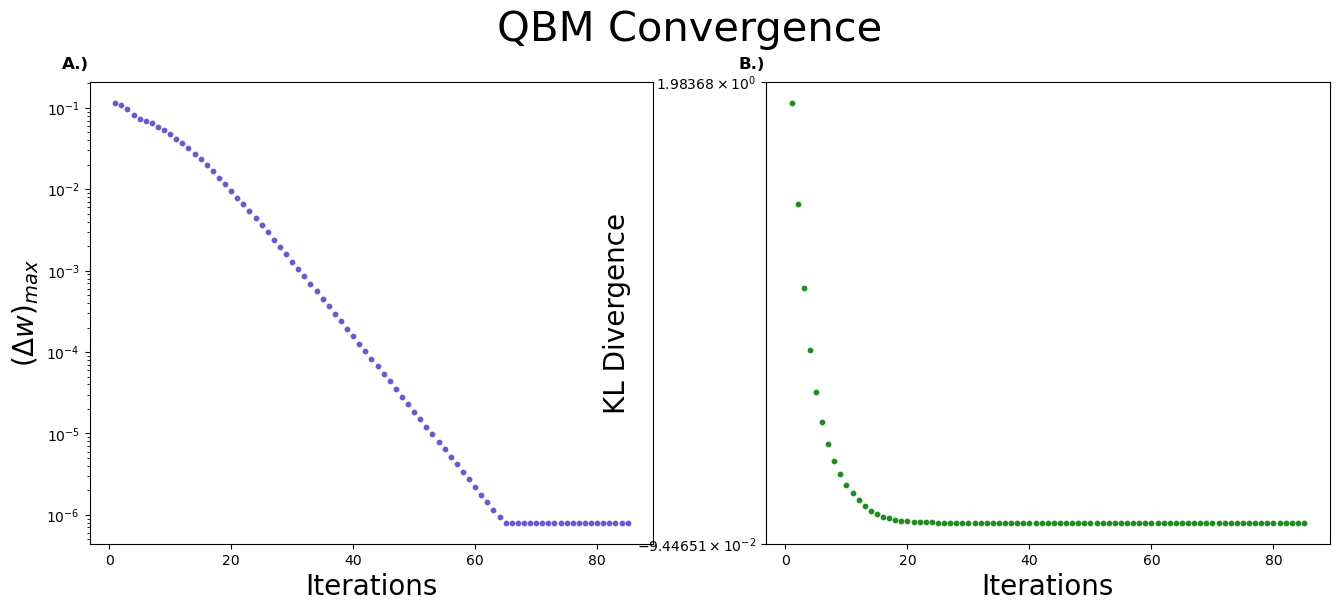

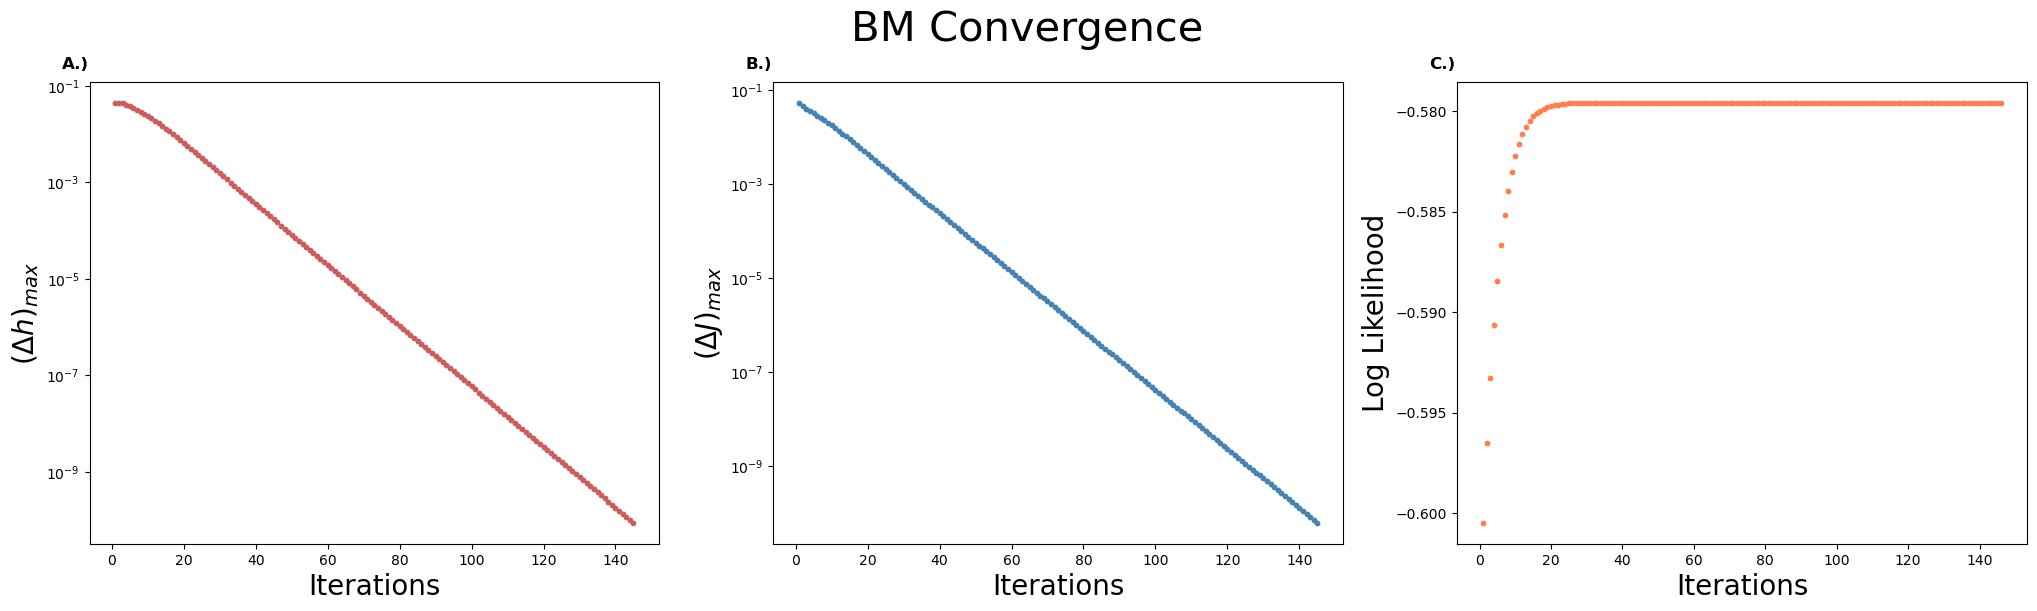

In [166]:
# initialize randomized initial parameters
N = 2

np.random.seed(0)
w = np.random.uniform(-1, 1, size=(2**N, 2**N)) + np.ones((2**N,2**N)) * 4 # add offset to make sure w is large enough for normalized probabilities
w = (w + w.T) / 2
np.fill_diagonal(w, 0)
w = w.astype(np.float64)

J = np.random.uniform(-1, 1, size=(N, N))
J = (J + J.T) / 2
np.fill_diagonal(J, 0)
J = J.astype(np.float64)

h = np.random.uniform(-1, 1, size=(N))
h = h.astype(np.float64)

# make sure w are large enough for normalized probabilities
check_parameters(w,J,h)

#intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .2
maxiter_qbm = 2**12

learning_rate_bm = .9
maxiter_bm = 2**12

# map forward and back. Set plot_convergence to True if you want to see the convergence plots
w_qm = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence = True)
W_recovered, w_recovered, J_recovered, h_recovered = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence = True, perform_checks = False)

print('Difference in initial and recovered parameters:')
print(f'w: \n {np.abs(w - w_recovered)}')
print(f'J: \n {np.abs(J - J_recovered)}')
print(f'h: \n {np.abs(h - h_recovered)}')

print(f'Average error per parameter: {(np.sum(np.abs(w - w_recovered)) + np.sum(np.abs(J - J_recovered)) + np.sum(np.abs(h - h_recovered))) / (w.size + J.size + h.size)}')


### Reversibility for 3-qubits


Another open question is if we are be able to invert the forward mapping for a non-complete Hamiltonian (i.e. N > 2). Let's try for a 3-qubit system:

Difference in initial and recovered parameters:
w: 
 [[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
J: 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
h: 
 [0. 0. 0.]
Average error per parameter: 3.85872712503453e-06


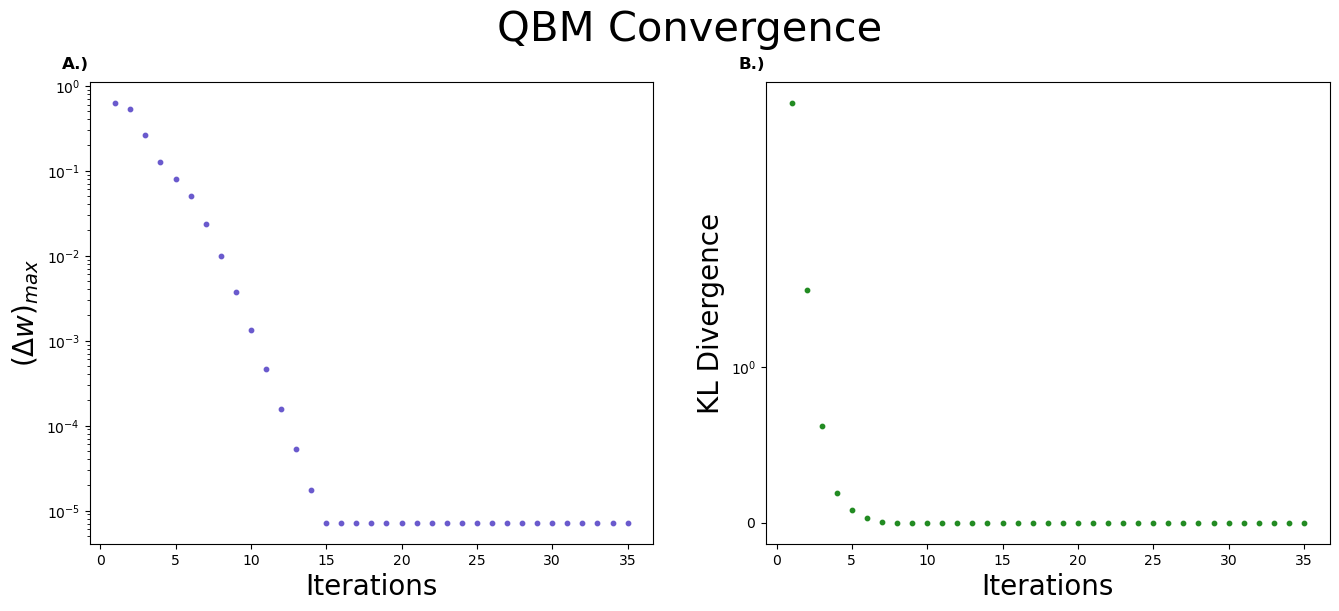

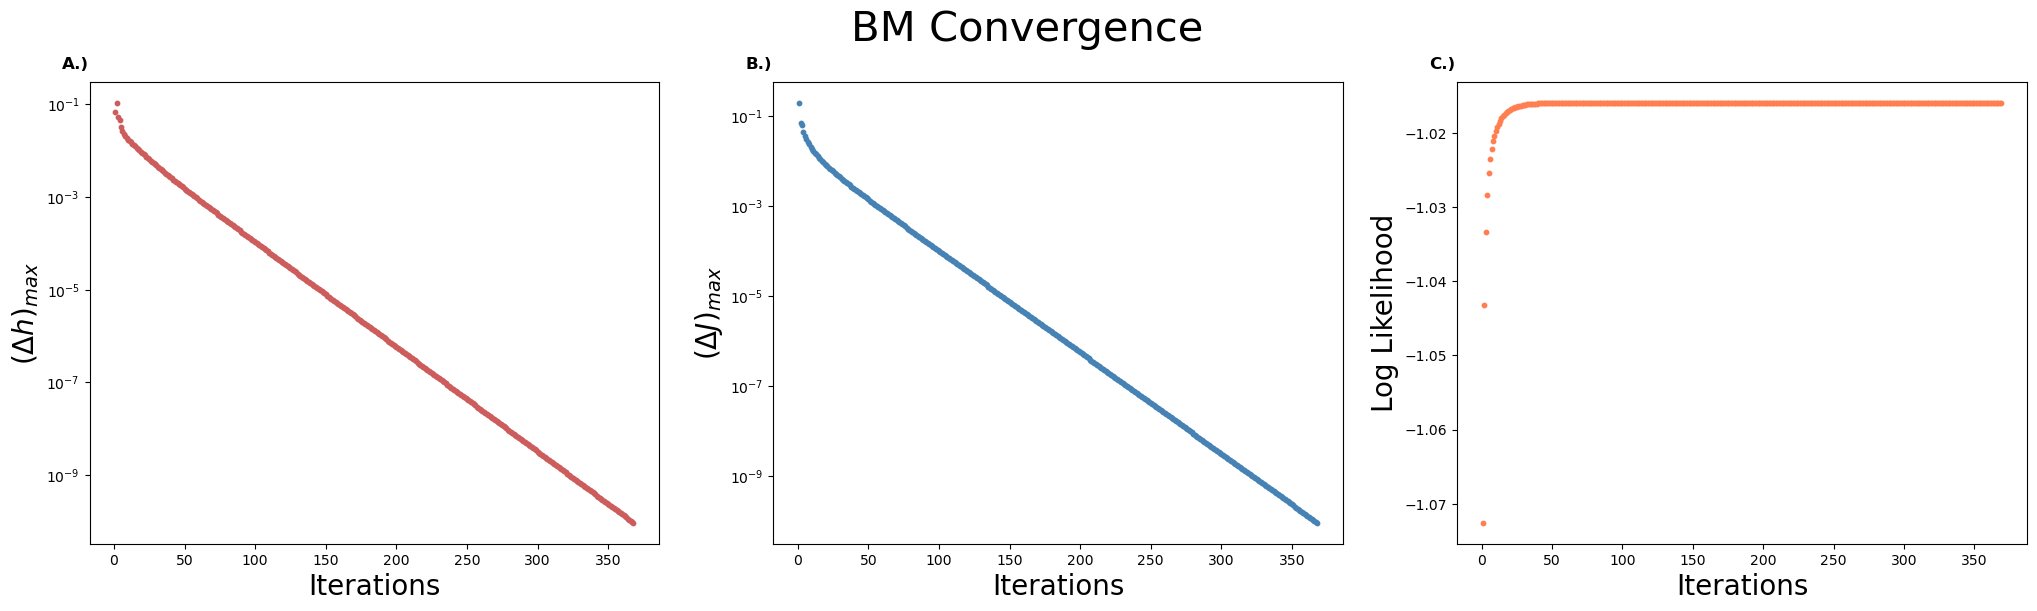

In [171]:
# initialize the classical parameters
N = 3
np.random.seed(0)
w = np.random.uniform(-1, 1, size=(2**N, 2**N)) + np.ones((2**N,2**N)) * 4 # add offset to make sure w is large enough for normalized probabilities
w = (w + w.T) / 2
np.fill_diagonal(w, 0)
w = w.astype(np.float64)

J = np.random.uniform(-1, 1, size=(N, N))
J = (J + J.T) / 2
np.fill_diagonal(J, 0)
J = J.astype(np.float64)

h = np.random.uniform(-1, 1, size=(N))
h = h.astype(np.float64)

w = set_w_zero(w,N)
check_parameters(w,J,h)

np.set_printoptions(precision=3, suppress=True)

#intialize the optimal learning parameters for 3-qubits
learning_rate_qbm = .9
maxiter_qbm = 2**10

learning_rate_bm = .9
maxiter_bm = 2**20

# map forward and back. Set plot_convergence to True if you want to see the convergence plots
w_qm = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence = True, perform_checks = False)
W_recovered, w_recovered, J_recovered, h_recovered = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence = True, perform_checks = False)

print('Difference in initial and recovered parameters:')
print(f'w: \n {np.abs(w - w_recovered)}')
print(f'J: \n {np.abs(J - J_recovered)}')
print(f'h: \n {np.abs(h - h_recovered)}')

print(f'Average error per parameter: {(np.sum(np.abs(w - w_recovered)) + np.sum(np.abs(J - J_recovered)) + np.sum(np.abs(h - h_recovered))) / (w.size + J.size + h.size)}')

We can recover the parameters, pretty accurately, even though we don't use a complete Hamiltonian.

### Reversibility for 4-qubits

Difference in initial and recovered parameters:
w: 
 [[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.003 0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.003 0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 

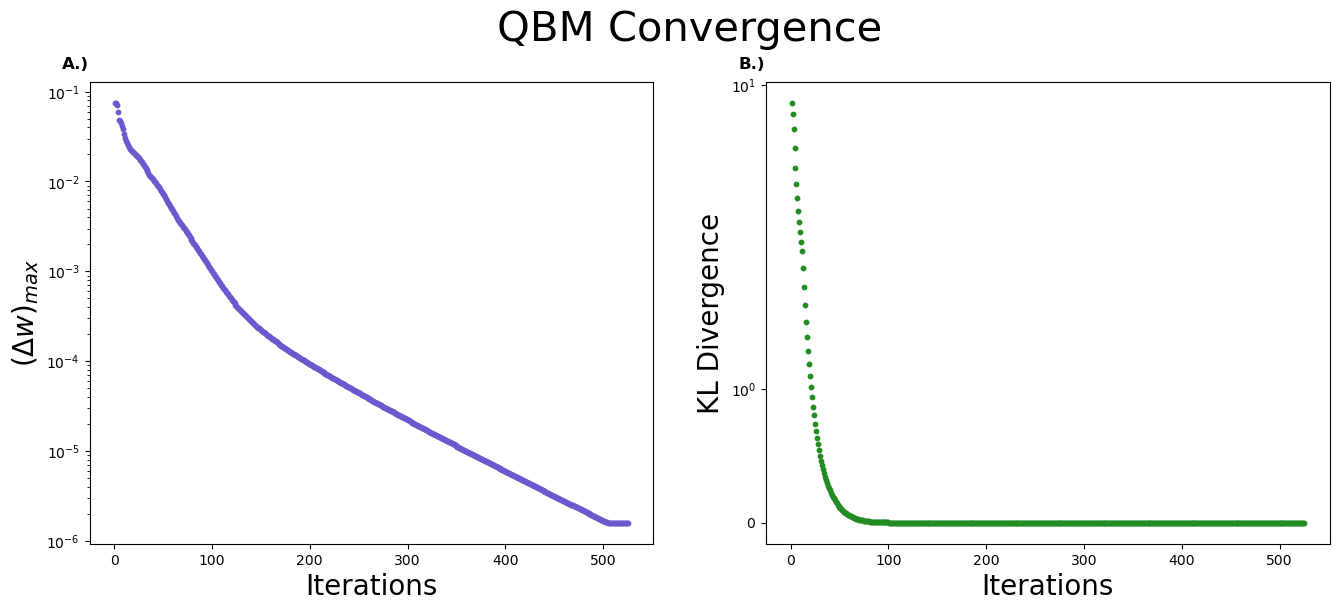

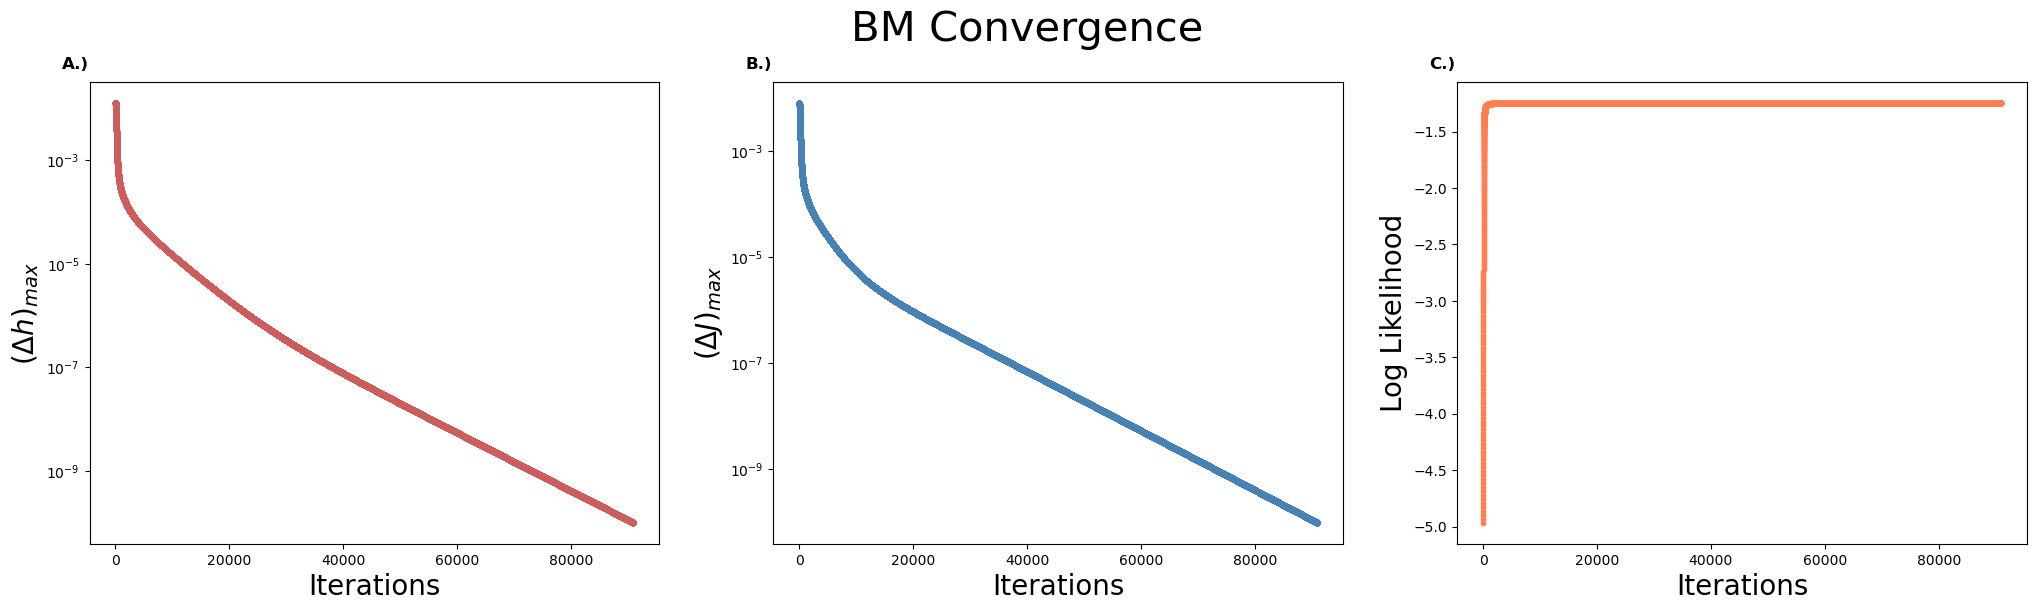

In [170]:

# initialize the classical parameters
N = 4
np.random.seed(0)
w = np.random.uniform(-1, 1, size=(2**N, 2**N)) + np.ones((2**N,2**N)) * 4 # add offset to make sure w is large enough for normalized probabilities
w = (w + w.T) / 2
np.fill_diagonal(w, 0)
w = w.astype(np.float64)

J = np.random.uniform(-1, 1, size=(N, N))
J = (J + J.T) / 2
np.fill_diagonal(J, 0)
J = J.astype(np.float64)

h = np.random.uniform(-1, 1, size=(N))
h = h.astype(np.float64)

w = set_w_zero(w,N)
check_parameters(w,J,h)

w = set_w_zero(w,N)
check_parameters(w,J,h)
np.set_printoptions(precision=3, suppress=True)

#intialize the optimal learning parameters for 4-qubits
learning_rate_qbm = .1
maxiter_qbm = 2**11

learning_rate_bm = .004
maxiter_bm = 2**22

# map forward and back. Set plot_convergence to True if you want to see the convergence plots
w_qm = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence = True, perform_checks = False)
W_recovered, w_recovered, J_recovered, h_recovered = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence = True, perform_checks = False)

print('Difference in initial and recovered parameters:')
print(f'w: \n {np.abs(w - w_recovered)}')
print(f'J: \n {np.abs(J - J_recovered)}')
print(f'h: \n {np.abs(h - h_recovered)}')

print(f'Average error per parameter: {(np.sum(np.abs(w - w_recovered)) + np.sum(np.abs(J - J_recovered)) + np.sum(np.abs(h - h_recovered))) / (w.size + J.size + h.size)}')

## Forward Mapping - Homogenous systems

### Results 2-qubits

In [93]:
# intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .5
maxiter_qbm = 2**22

#only relevant for checking if the mapping is inverisble
learning_rate_bm = .8
maxiter_bm = 2**20

# Default font
rc('text', usetex=False)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

# Palatino font
# rc('text', usetex=True)
# rc('font', family='serif')
# rc('font', serif='Palatino')

#### Varying J with no bias

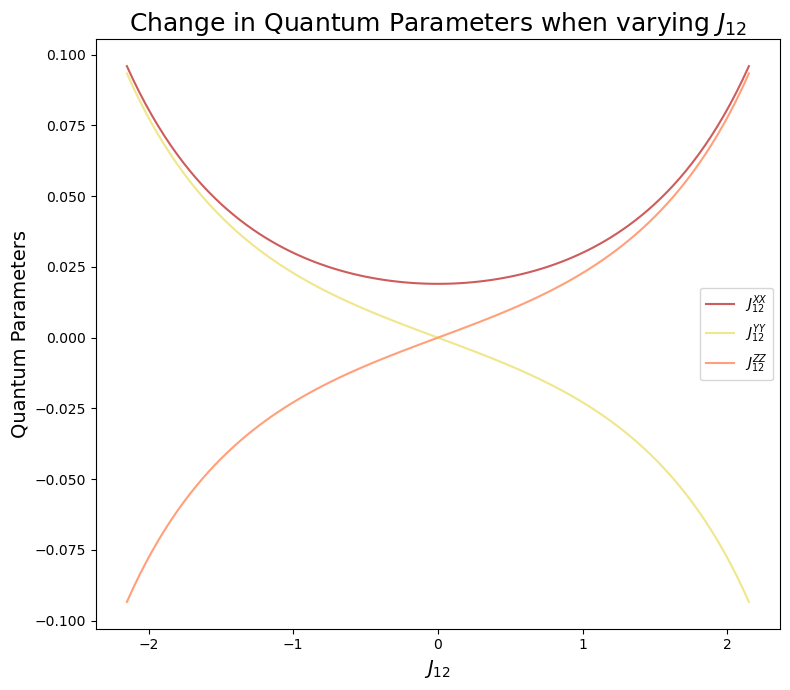

In [308]:
# initialize the parameters
N = 2
w = np.array([[0,4,4,4],
              [4,0,4,4],
              [4,4,0,4],
              [4,4,4,0]], dtype=np.float64)
J = np.array([[0, 0],
              [0, 0]],    dtype=np.float64)
h = np.array([1e-10, 1e-10],    dtype=np.float64)

#check that parameters are valid
check_parameters(w, J, h)

# define the classical parameter that will be varied
params = ['J']
indices = [(0, 1)]

# define the range over which the classical parameter will be varied
start = -2.15
end = 2.15
steps = 100

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$J_{12}^{XX}$', '$J_{12}^{YY}$', '$J_{12}^{ZZ}$'] 
# qm_params_to_plot = ['$h_{1}^{Z}$', '$h_{2}^{Z}$']
# qm_params_to_plot = ['$h_{1}^{X}$', '$h_{2}^{X}$']
# qm_params_to_plot = ['$J_{12}^{XX}$', '$J_{12}^{YY}$', '$J_{12}^{ZZ}$', '$h_{1}^{X}$', '$h_{2}^{X}$']
threshold = 0.01  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, params, indices, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)
plot_forward_mapping(quantum_params, start, end, steps, params, indices, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = False)

##### Difference Plot

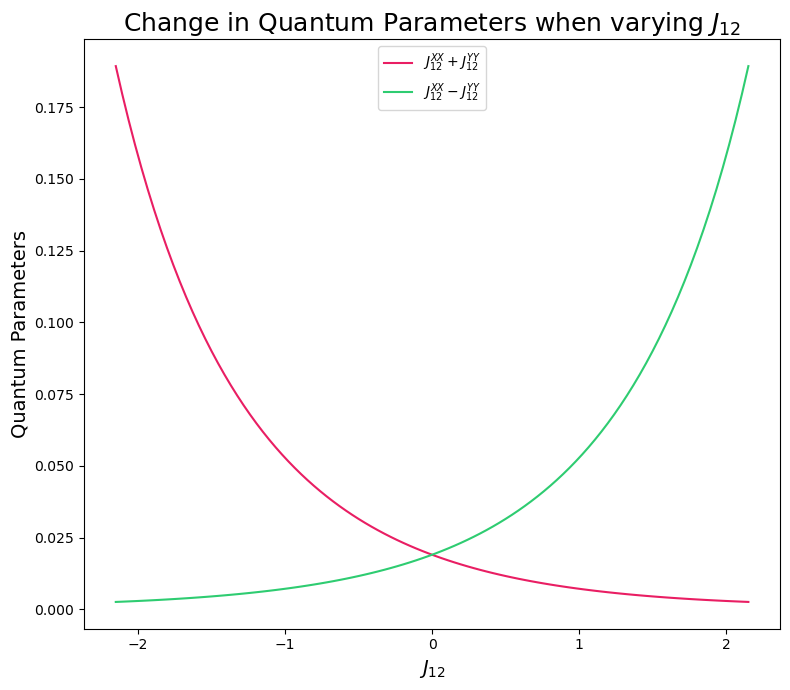

In [110]:
_,interaction_labels,interaction_weights = generate_interaction_matrices(N)
# print(interaction_labels)

Jxx = np.array(quantum_params)[:, list(interaction_weights.keys()).index(('X','X'))]
Jyy = np.array(quantum_params)[:, list(interaction_weights.keys()).index(('Y','Y'))]
Jzz = np.array(quantum_params)[:, list(interaction_weights.keys()).index(('Y','Y'))]

classical_param_values = np.linspace(start, end, steps)

# create plots for the changed parameters
plt.figure(figsize=(8, 7))

# Set LaTeX font to Palatino
# rc('text', usetex=True)
# rc('font', family='serif')
# rc('font', serif='Palatino')

# plt.plot(classical_param_values, Jxx, label = '$J_{12}^{XX}$', color = 'IndianRed')
# plt.plot(classical_param_values, Jyy, label = '$J_{12}^{YY}$', color = 'Khaki')
# plt.plot(classical_param_values, Jzz, label = '$J_{12}^{ZZ}$', color = 'LightSalmon')
plt.plot(classical_param_values, Jxx + Jyy, label = '$J_{12}^{XX} + J_{12}^{YY}$', color = '#e91e63')
plt.plot(classical_param_values, Jxx - Jyy, label = '$J_{12}^{XX} - J_{12}^{YY}$', color = '#2ecc71')


plt.title('Change in Quantum Parameters when varying $J_{12}$', fontsize = 18)
plt.xlabel('$J_{12}$', fontsize = 14)
plt.ylabel('Quantum Parameters', fontsize = 14)
plt.legend()
plt.tight_layout()  # ensures the legend and text do not overlap with the plot
plt.show()

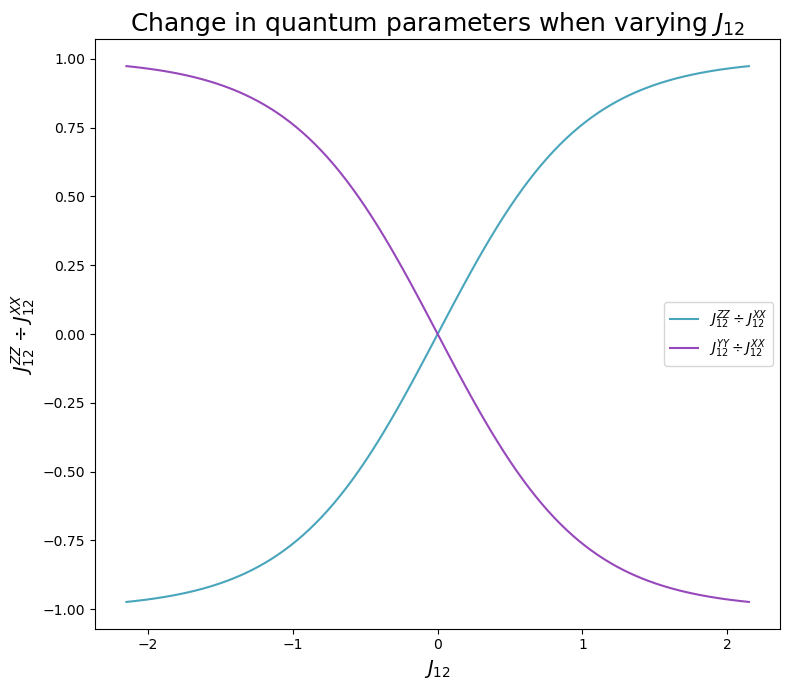

In [137]:
_,interaction_labels,interaction_weights = generate_interaction_matrices(N)
# print(interaction_labels)

Jxx = np.array(quantum_params)[:, list(interaction_weights.keys()).index(('X','X'))]
Jyy = np.array(quantum_params)[:, list(interaction_weights.keys()).index(('Y','Y'))]
Jzz = np.array(quantum_params)[:, list(interaction_weights.keys()).index(('Z','Z'))]

classical_param_values = np.linspace(start, end, steps)

# create plots for the changed parameters
plt.figure(figsize=(8, 7))

# Set LaTeX font to Palatino
# rc('text', usetex=True)
# rc('font', family='serif')
# rc('font', serif='Palatino')

plt.plot(classical_param_values, Jzz / Jxx, label = '$ {J_{12}^{ZZ}} \div {J_{12}^{XX}}$', color = '#48a5bb')
plt.plot(classical_param_values, Jyy / Jxx, label = '$ {J_{12}^{YY}} \div {J_{12}^{XX}}$', color = '#9748bb')



plt.title('Change in quantum parameters when varying $J_{12}$', fontsize = 18)
plt.xlabel('$J_{12}$', fontsize = 14)
plt.ylabel('$ {J_{12}^{ZZ}} \div {J_{12}^{XX}}$', fontsize = 14)
plt.legend()
plt.tight_layout()  # ensures the legend and text do not overlap with the plot
plt.show()

#### Varying J in homogenous system with small biases 

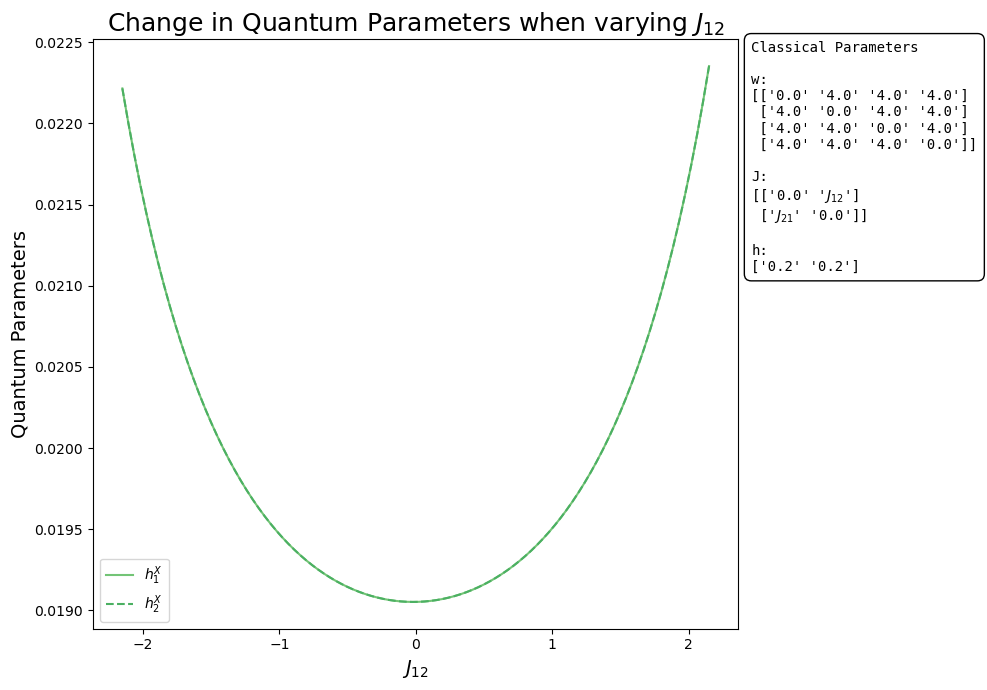

In [41]:
# initialize the classical parameters
N = 2
w = np.array([[0,4,4,4],
              [4,0,4,4],
              [4,4,0,4],
              [4,4,4,0]],  dtype=np.float64)
J = np.array([[0, 0],
              [0, 0]],     dtype=np.float64)
h = np.array([.2 ,.2], dtype=np.float64)

# define the classical parameter that will be varied
params = ['J']
indices = [(0, 1)]

# define the range over which the classical parameter will be varied
start = -2.15
end = 2.15
steps = 100

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$J_{12}^{XX}$', '$J_{12}^{YY}$', '$J_{12}^{ZZ}$'] 
# qm_params_to_plot = ['$h_{1}^{Z}$', '$h_{2}^{Z}$']
# qm_params_to_plot = ['$h_{1}^{X}$', '$h_{2}^{X}$']
threshold = 0.001  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, params, indices, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)
plot_forward_mapping(quantum_params, start, end, steps, params, indices, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True)

#### Varying J in homogenous system with large biases 

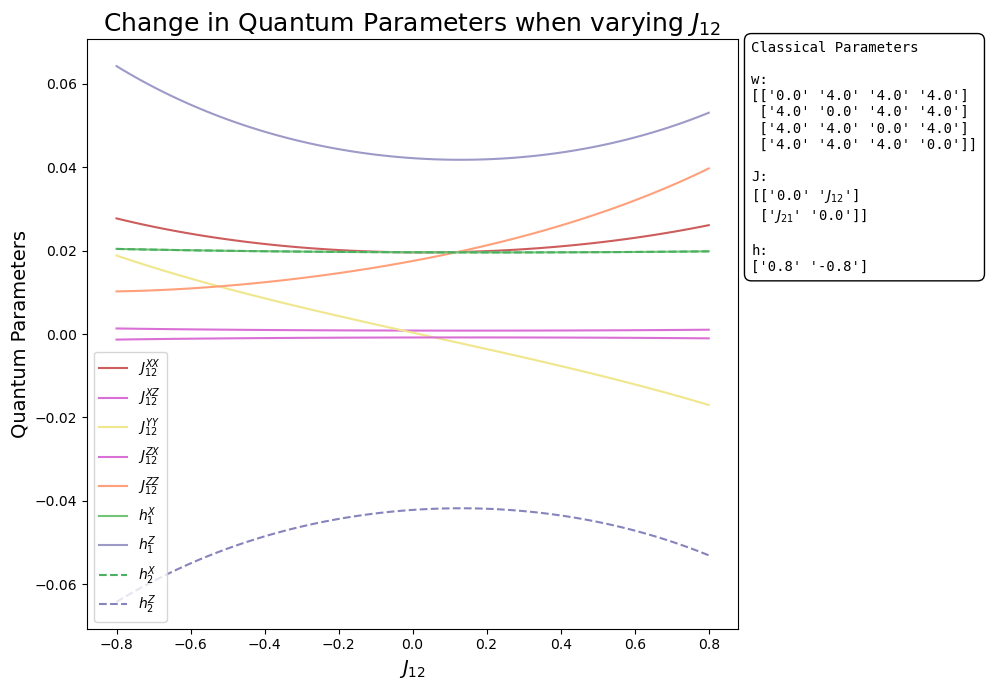

In [51]:
# initialize the classical parameters
N = 2
w = np.array([[0,4,4,4],
              [4,0,4,4],
              [4,4,0,4],
              [4,4,4,0]], dtype=np.float64)
J = np.array([[0, 0],
              [0, 0]],   dtype=np.float64)
h = np.array([.8,-.8],   dtype=np.float64)

#check that parameters are valid
check_parameters(w, J, h)

# define the classical parameter that will be varied
params = ['J']
indices = [(0, 1)]

# define the range over which the classical parameter will be varied
start = -.8
end = .8
steps = 100

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$J_{12}^{XX}$', '$J_{12}^{YY}$', '$J_{12}^{ZZ}$'] 
# qm_params_to_plot = ['$J_{12}^{XZ}$', '$J_{12}^{ZX}$']
# qm_params_to_plot = ['$h_{1}^{Z}$',   '$h_{2}^{Z}$']
# qm_params_to_plot = ['$h_{1}^{X}$',   '$h_{2}^{X}$']
threshold = 0.0001  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, params, indices, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)
plot_forward_mapping(quantum_params, start, end, steps, params, indices, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True)


#### Varying h in homogenous system without interactions

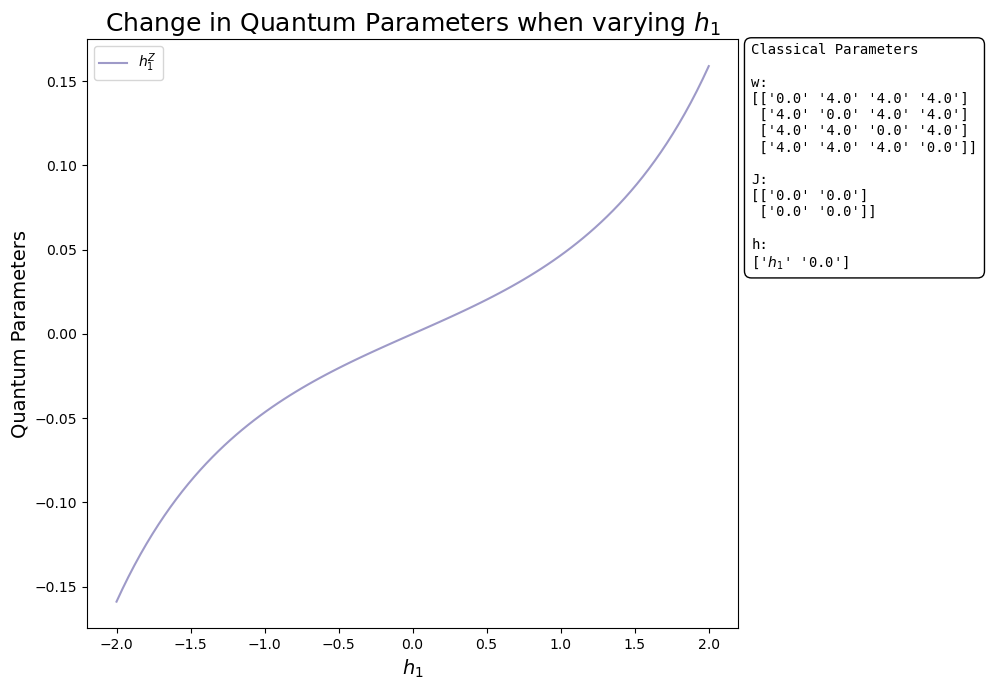

In [99]:
# initialize the classical parameters
N = 2
w = np.array([[0,4,4,4],
              [4,0,4,4],
              [4,4,0,4],
              [4,4,4,0]], dtype=np.float64)
J = np.array([[0, 0],
              [0, 0]],   dtype=np.float64)
h = np.array([0,0],      dtype=np.float64)

#check that parameters are valid
check_parameters(w, J, h)

# define the classical parameter that will be varied
params = ['h']
indices = [(0, 0)]

# define the range over which the classical parameter will be varied
start = -2
end = 2
steps = 100

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$J_{12}^{XX}$', '$J_{12}^{YY}$', '$J_{12}^{ZZ}$'] 
# qm_params_to_plot = ['$h_{1}^{Z}$', '$h_{2}^{Z}$']
# qm_params_to_plot = ['$h_{1}^{X}$', '$h_{2}^{X}$']
# qm_params_to_plot = ['$h_{2}^{Z}$', '$J_{12}^{XZ}$']
threshold = 0.01  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, params, indices, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)
plot_forward_mapping(quantum_params, start, end, steps, params, indices, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True)

##### Scaled Plot

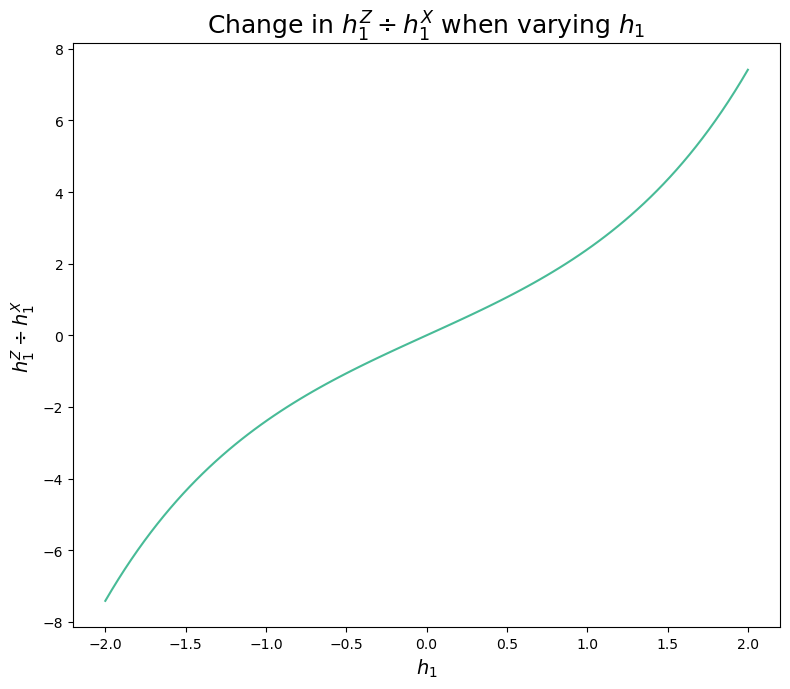

In [106]:
_,interaction_labels,interaction_weights = generate_interaction_matrices(N)

h1x = np.array(quantum_params)[:, list(interaction_weights.keys()).index(('X','I'))]
h1z = np.array(quantum_params)[:, list(interaction_weights.keys()).index(('Z','I'))]

classical_param_values = np.linspace(start, end, steps)

# create plots for the changed parameters
plt.figure(figsize=(8, 7))

plt.plot(classical_param_values, (h1z / h1x) , label = '$h_{1}^{Z} \div h_{1}^{X}$', color = '#48bb97')

plt.title('Change in $h_{1}^{Z} \div h_{1}^{X}$ when varying $h_{1}$', fontsize = 18)
plt.xlabel('$h_{1}$', fontsize = 14)
plt.ylabel('$h_{1}^{Z} \div h_{1}^{X}$', fontsize = 14)
# plt.legend()
plt.tight_layout()  # ensures the legend and text do not overlap with the plot
plt.show()

#### Varying h in homogenous system with small interactions

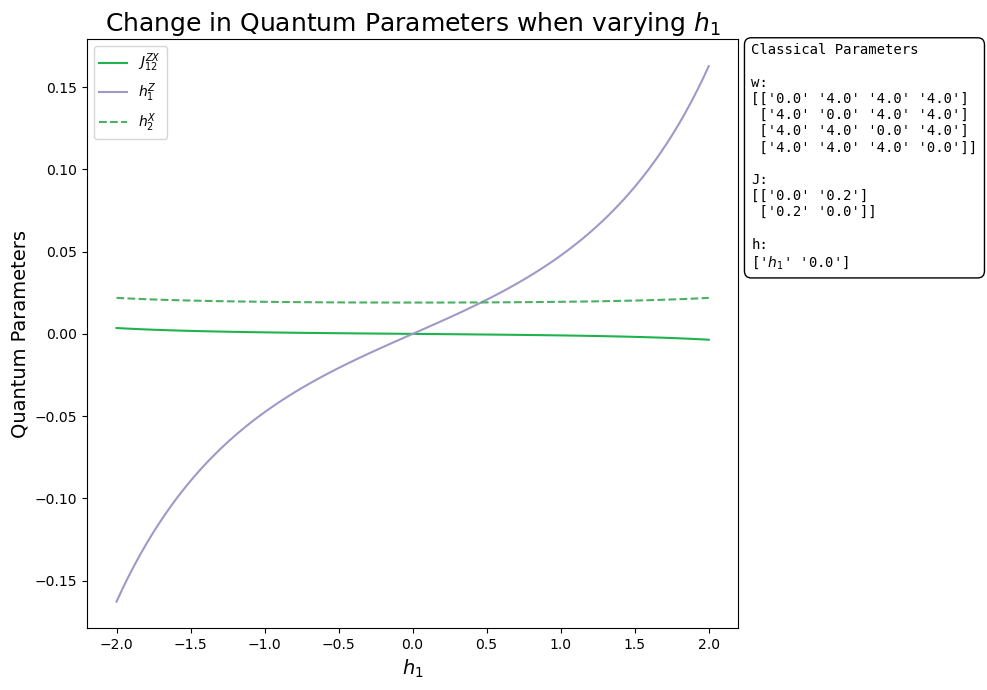

In [145]:
# initialize the classical parameters
N = 2
w = np.array([[0,4,4,4],
              [4,0,4,4],
              [4,4,0,4],
              [4,4,4,0]], dtype=np.float64)
J = np.array([[0, .2],
              [.2, 0]],   dtype=np.float64)
h = np.array([0,0],      dtype=np.float64)

#check that parameters are valid
check_parameters(w, J, h)

# define the classical parameter that will be varied
params = ['h']
indices = [(0, 0)]

# define the range over which the classical parameter will be varied
start = -2
end = 2
steps = 100


# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$h_{1}^{Z}$', '$h_{2}^{Z}$']
qm_params_to_plot = ['$h_{1}^{X}$', '$h_{2}^{X}$', '$h_{1}^{Z}$', '$h_{2}^{Z}$','$J_{12}^{ZX}$']
qm_params_to_plot = ['$h_{2}^{X}$', '$h_{1}^{Z}$', '$J_{12}^{ZX}$']
threshold = 0.001  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, params, indices, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)
plot_forward_mapping(quantum_params, start, end, steps, params, indices, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True)


#### Varying h in homogenous system with large interactions

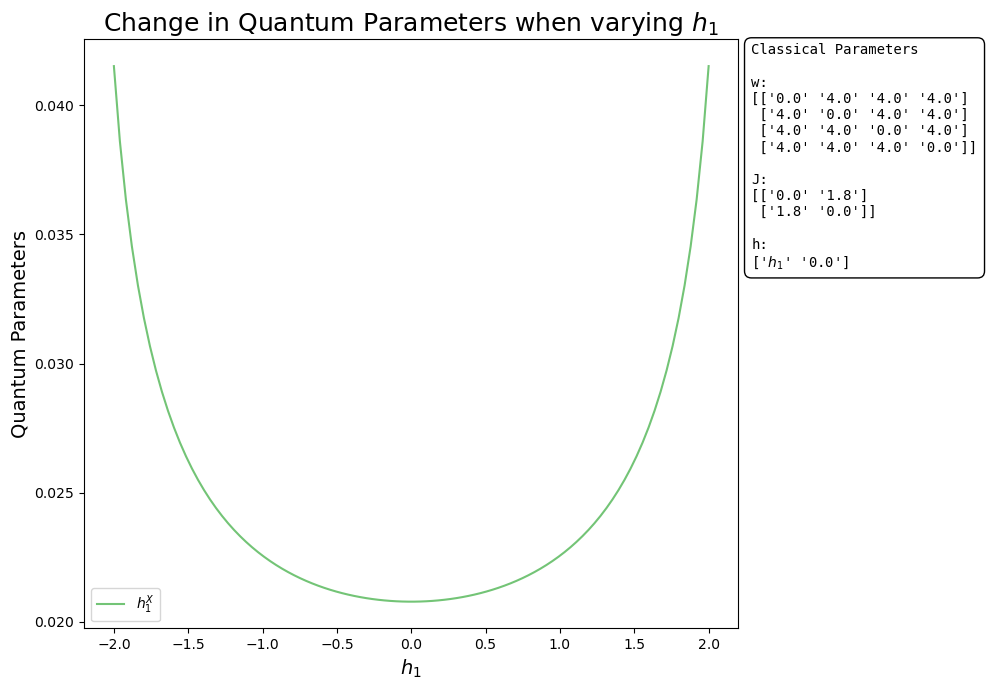

In [151]:
# initialize the classical parameters
N = 2
w = np.array([[0,4,4,4],
              [4,0,4,4],
              [4,4,0,4],
              [4,4,4,0]], dtype=np.float64)
J = np.array([[0, 1.8],
              [1.8, 0]],   dtype=np.float64)
h = np.array([0,0],      dtype=np.float64)

#check that parameters are valid
check_parameters(w, J, h)

# define the classical parameter that will be varied
params = ['h']
indices = [(0, 0)]

# define the range over which the classical parameter will be varied
start = -2
end = 2
steps = 100


# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$h_{1}^{Z}$', '$h_{2}^{Z}$']
# qm_params_to_plot = ['$h_{1}^{X}$', '$h_{2}^{X}$', '$h_{1}^{Z}$', '$h_{2}^{Z}$','$J_{12}^{ZX}$']
qm_params_to_plot = ['$h_{1}^{X}$']
threshold = 0.001  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, params, indices, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)
plot_forward_mapping(quantum_params, start, end, steps, params, indices, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True)


#### Varying single spin-flip transititions without interactions or biases

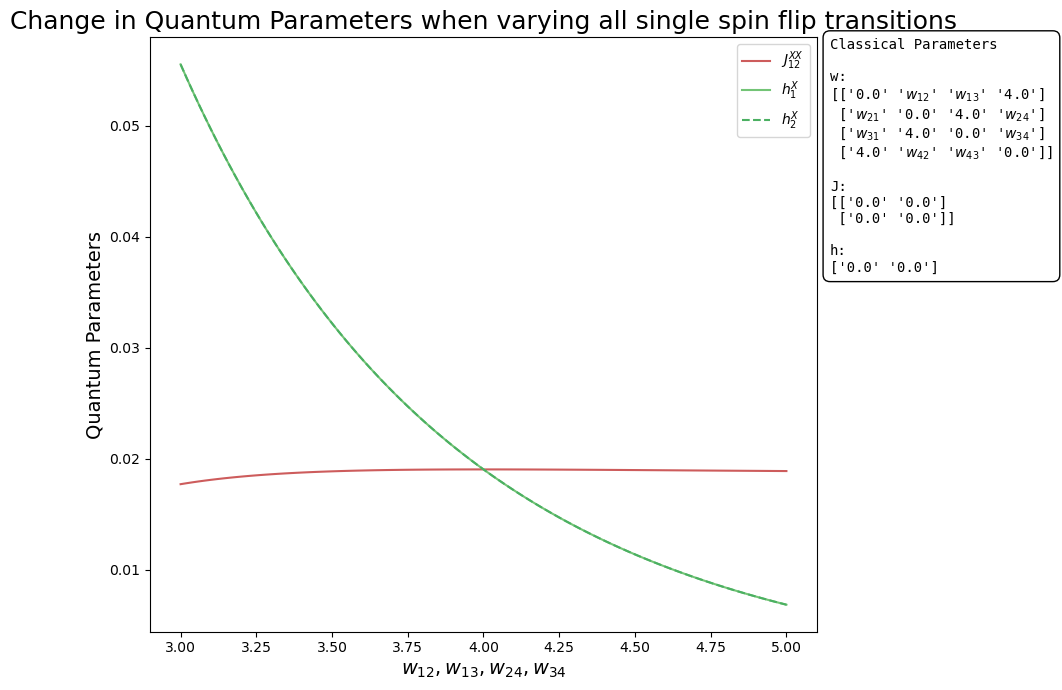

In [300]:
# initialize the classical parameters
N = 2
w = np.array([[0,4,4,4],
              [4,0,4,4],
              [4,4,0,4],
              [4,4,4,0]], dtype=np.float64)
J = np.array([[0, 0],
              [0, 0]],   dtype=np.float64)
h = np.array([0,0],      dtype=np.float64)

#check that parameters are valid
check_parameters(w, J, h)

# define the classical parameter that will be varied
params = ['w', 'w', 'w', 'w']
indices = [(0, 1), (0,2), (1,3), (2,3)]

# define the range over which the classical parameter will be varied
start = 3
end = 5
steps = 100

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$h_{1}^{Z}$', '$h_{2}^{Z}$']
# qm_params_to_plot = ['$h_{1}^{X}$', '$h_{2}^{X}$', '$h_{1}^{Z}$', '$h_{2}^{Z}$','$J_{12}^{ZX}$']
# qm_params_to_plot = ['$h_{1}^{X}$']
threshold = 0.001  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, params, indices, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)
title = 'Change in Quantum Parameters when varying all single spin flip transitions'
plot_forward_mapping(quantum_params, start, end, steps, params, indices, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True, title = title)


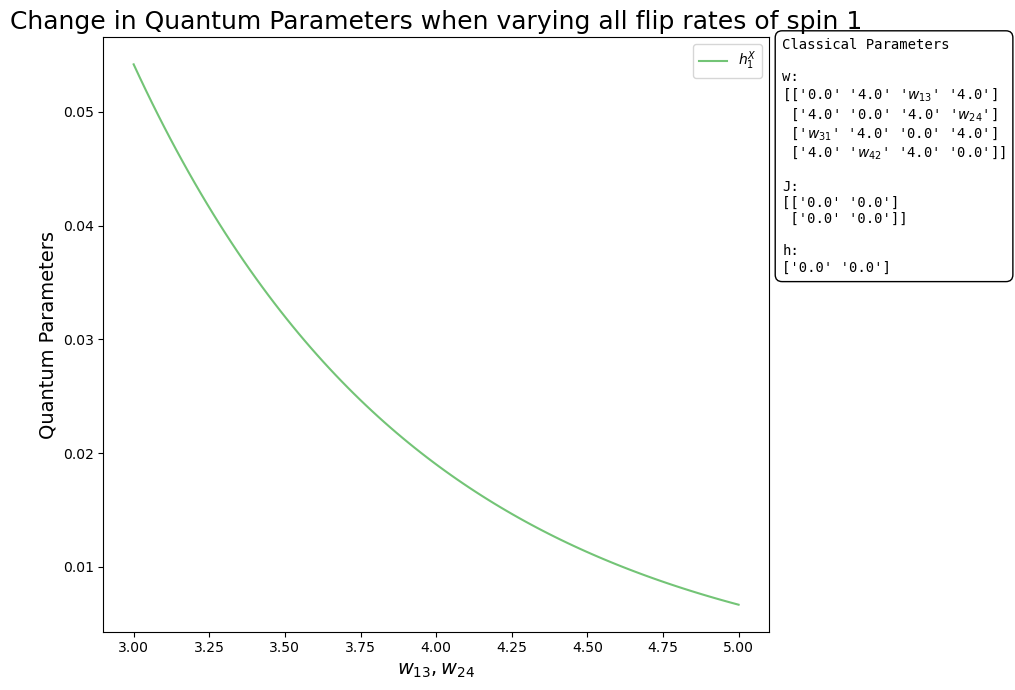

In [301]:
# initialize the classical parameters
N = 2
w = np.array([[0,4,4,4],
              [4,0,4,4],
              [4,4,0,4],
              [4,4,4,0]], dtype=np.float64)
J = np.array([[0, 0],
              [0, 0]],   dtype=np.float64)
h = np.array([0,0],      dtype=np.float64)

#check that parameters are valid
check_parameters(w, J, h)

# define the classical parameter that will be varied
params = ['w', 'w']
indices = [(0,2), (1,3)]

# define the range over which the classical parameter will be varied
start = 3
end = 5
steps = 100

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$h_{1}^{Z}$', '$h_{2}^{Z}$']
# qm_params_to_plot = ['$h_{1}^{X}$', '$h_{2}^{X}$', '$h_{1}^{Z}$', '$h_{2}^{Z}$','$J_{12}^{ZX}$']
# qm_params_to_plot = ['$h_{1}^{X}$']
threshold = 0.001  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, params, indices, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)
title = 'Change in Quantum Parameters when varying all flip rates of spin 1'
plot_forward_mapping(quantum_params, start, end, steps, params, indices, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True, title = title)

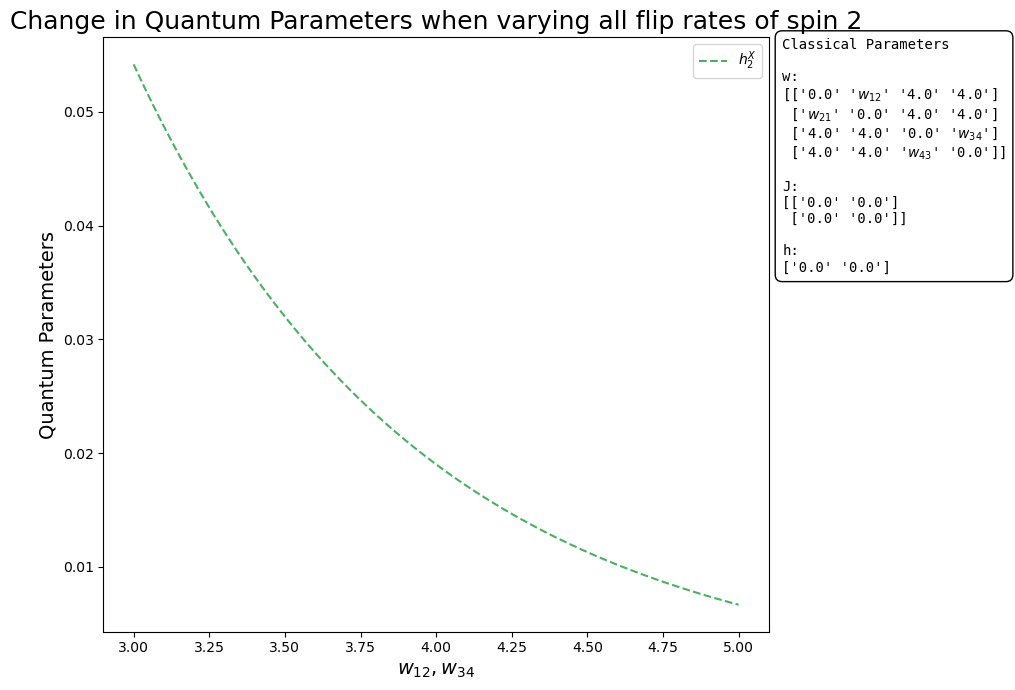

In [302]:
# initialize the classical parameters
N = 2
w = np.array([[0,4,4,4],
              [4,0,4,4],
              [4,4,0,4],
              [4,4,4,0]], dtype=np.float64)
J = np.array([[0, 0],
              [0, 0]],   dtype=np.float64)
h = np.array([0,0],      dtype=np.float64)

#check that parameters are valid
check_parameters(w, J, h)

# define the classical parameter that will be varied
params = ['w', 'w']
indices = [(0, 1), (2,3)]

# define the range over which the classical parameter will be varied
start = 3
end = 5
steps = 100

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$h_{1}^{Z}$', '$h_{2}^{Z}$']
# qm_params_to_plot = ['$h_{1}^{X}$', '$h_{2}^{X}$', '$h_{1}^{Z}$', '$h_{2}^{Z}$','$J_{12}^{ZX}$']
# qm_params_to_plot = ['$h_{1}^{X}$']
threshold = 0.001  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, params, indices, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)
title = 'Change in Quantum Parameters when varying all flip rates of spin 2'
plot_forward_mapping(quantum_params, start, end, steps, params, indices, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True, title = title)

odd transition: even to odd or odd to even state  
even transition: even to even or odd to odd transition  

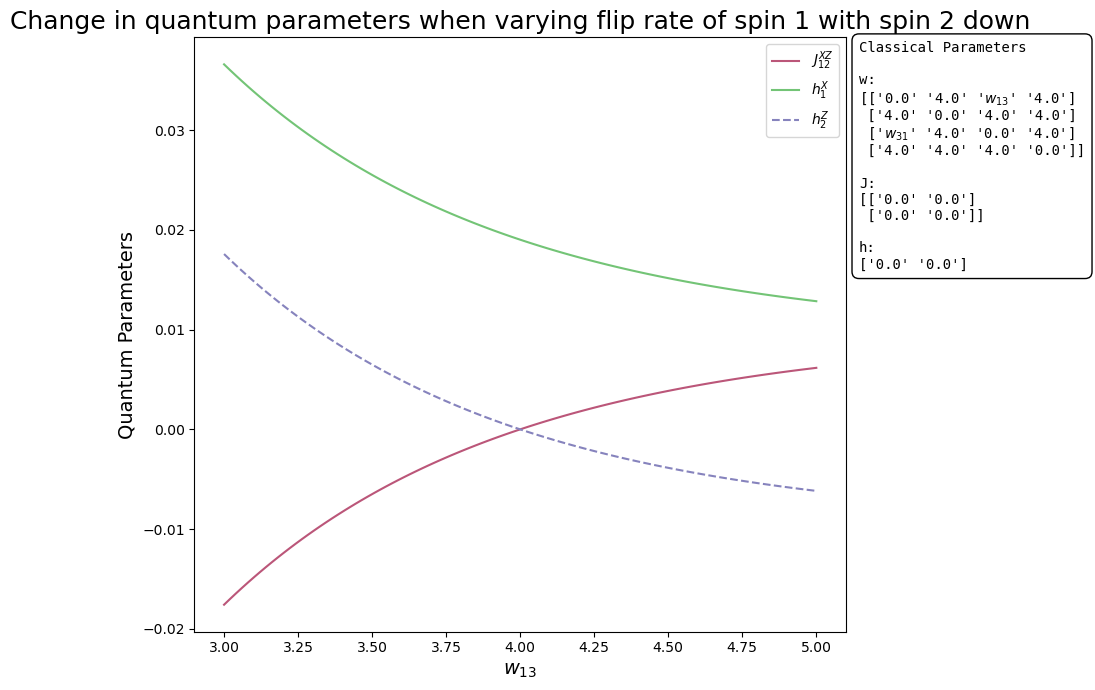

In [303]:
# initialize the classical parameters
N = 2
w = np.array([[0,4,4,4],
              [4,0,4,4],
              [4,4,0,4],
              [4,4,4,0]], dtype=np.float64)
J = np.array([[0, 0],
              [0, 0]],   dtype=np.float64)
h = np.array([0,0],      dtype=np.float64)

#check that parameters are valid
check_parameters(w, J, h)

# define the classical parameter that will be varied
params = ['w']
indices = [(0, 2)]

# define the range over which the classical parameter will be varied
start = 3
end = 5
steps = 100

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$h_{1}^{Z}$', '$h_{2}^{Z}$']
# qm_params_to_plot = ['$h_{1}^{X}$', '$h_{2}^{X}$', '$h_{1}^{Z}$', '$h_{2}^{Z}$','$J_{12}^{ZX}$']
# qm_params_to_plot = ['$h_{1}^{X}$']
threshold = 0.001  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, params, indices, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)
title = 'Change in quantum parameters when varying flip rate of spin 1 with spin 2 down'
plot_forward_mapping(quantum_params, start, end, steps, params, indices, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True, title = title)

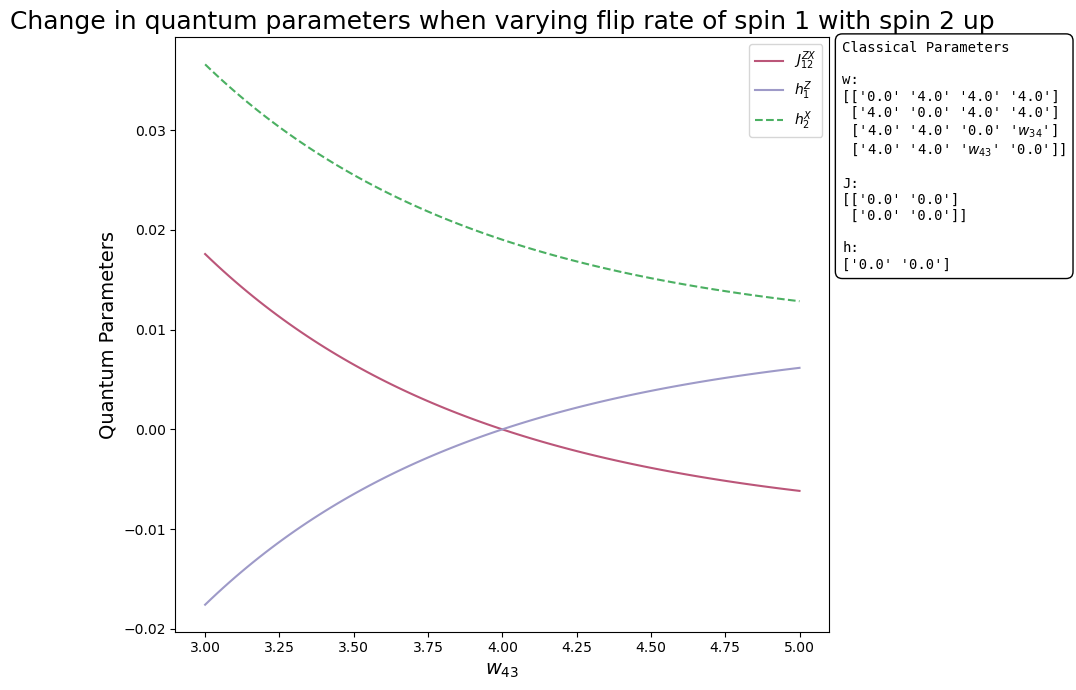

In [304]:
# initialize the classical parameters
N = 2
w = np.array([[0,4,4,4],
              [4,0,4,4],
              [4,4,0,4],
              [4,4,4,0]], dtype=np.float64)
J = np.array([[0, 0],
              [0, 0]],   dtype=np.float64)
h = np.array([0,0],      dtype=np.float64)

#check that parameters are valid
check_parameters(w, J, h)

# define the classical parameter that will be varied
params = ['w']
indices = [(3, 2)]

# define the range over which the classical parameter will be varied
start = 3
end = 5
steps = 100

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$h_{1}^{Z}$', '$h_{2}^{Z}$']
# qm_params_to_plot = ['$h_{1}^{X}$', '$h_{2}^{X}$', '$h_{1}^{Z}$', '$h_{2}^{Z}$','$J_{12}^{ZX}$']
# qm_params_to_plot = ['$h_{1}^{X}$']
threshold = 0.001  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, params, indices, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)
title = 'Change in quantum parameters when varying flip rate of spin 1 with spin 2 up'
plot_forward_mapping(quantum_params, start, end, steps, params, indices, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True, title = title)

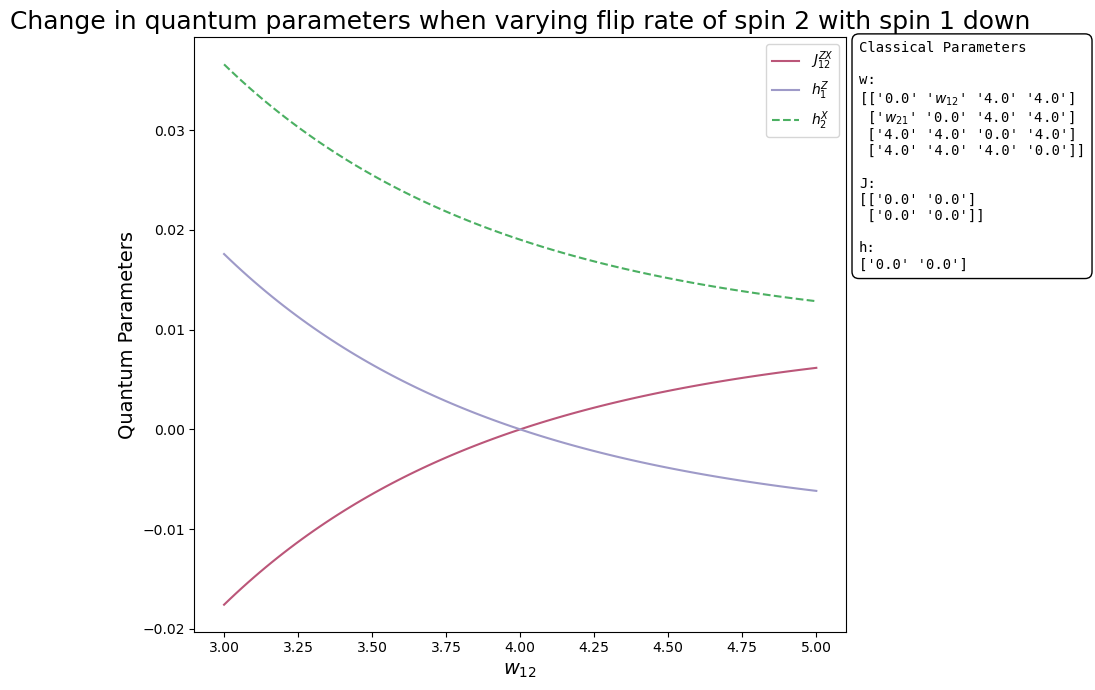

In [305]:
# initialize the classical parameters
N = 2
w = np.array([[0,4,4,4],
              [4,0,4,4],
              [4,4,0,4],
              [4,4,4,0]], dtype=np.float64)
J = np.array([[0, 0],
              [0, 0]],   dtype=np.float64)
h = np.array([0,0],      dtype=np.float64)

#check that parameters are valid
check_parameters(w, J, h)

# define the classical parameter that will be varied
params = ['w']
indices = [(0, 1)]

# define the range over which the classical parameter will be varied
start = 3
end = 5
steps = 100

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$h_{1}^{Z}$', '$h_{2}^{Z}$']
# qm_params_to_plot = ['$h_{1}^{X}$', '$h_{2}^{X}$', '$h_{1}^{Z}$', '$h_{2}^{Z}$','$J_{12}^{ZX}$']
# qm_params_to_plot = ['$h_{1}^{X}$']
threshold = 0.001  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, params, indices, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)
title = 'Change in quantum parameters when varying flip rate of spin 2 with spin 1 down'
plot_forward_mapping(quantum_params, start, end, steps, params, indices, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True, title = title)

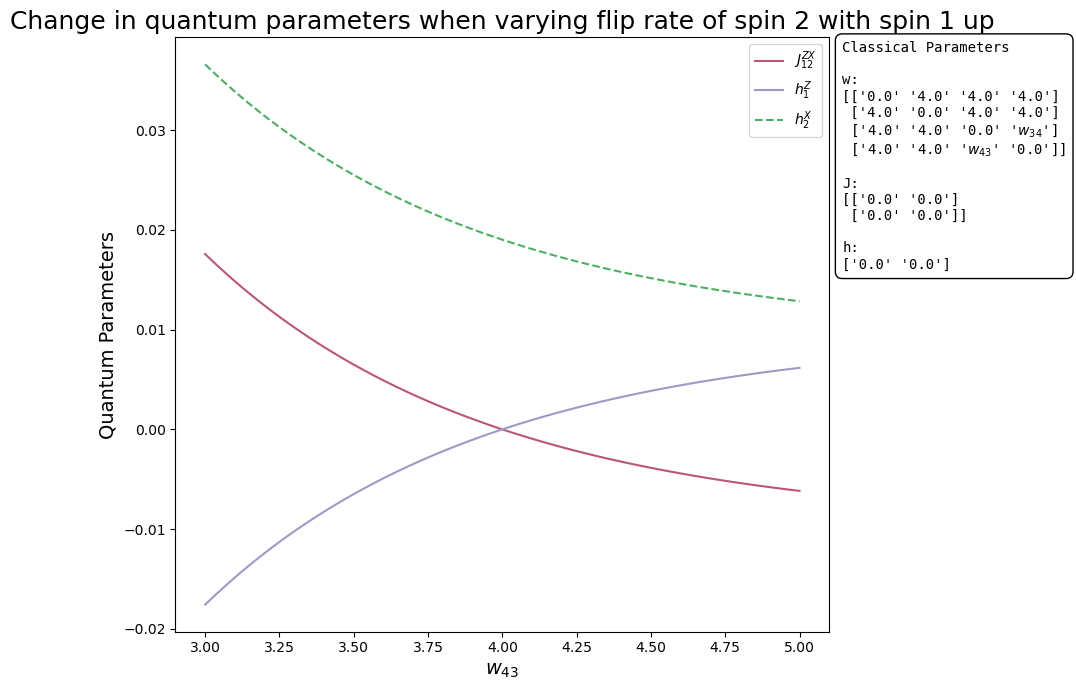

In [298]:
# initialize the classical parameters
N = 2
w = np.array([[0,4,4,4],
              [4,0,4,4],
              [4,4,0,4],
              [4,4,4,0]], dtype=np.float64)
J = np.array([[0, 0],
              [0, 0]],   dtype=np.float64)
h = np.array([0,0],      dtype=np.float64)

#check that parameters are valid
check_parameters(w, J, h)

# define the classical parameter that will be varied
params = ['w']
indices = [(3, 2)]

# define the range over which the classical parameter will be varied
start = 3
end = 5
steps = 100

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$h_{1}^{Z}$', '$h_{2}^{Z}$']
# qm_params_to_plot = ['$h_{1}^{X}$', '$h_{2}^{X}$', '$h_{1}^{Z}$', '$h_{2}^{Z}$','$J_{12}^{ZX}$']
# qm_params_to_plot = ['$h_{1}^{X}$']
threshold = 0.001  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, params, indices, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)
title = 'Change in quantum parameters when varying flip rate of spin 2 with spin 1 up'
plot_forward_mapping(quantum_params, start, end, steps, params, indices, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True, title = title)

#### Varying single spin-flip transititions with biases

When we add biases we get mixing of effects:

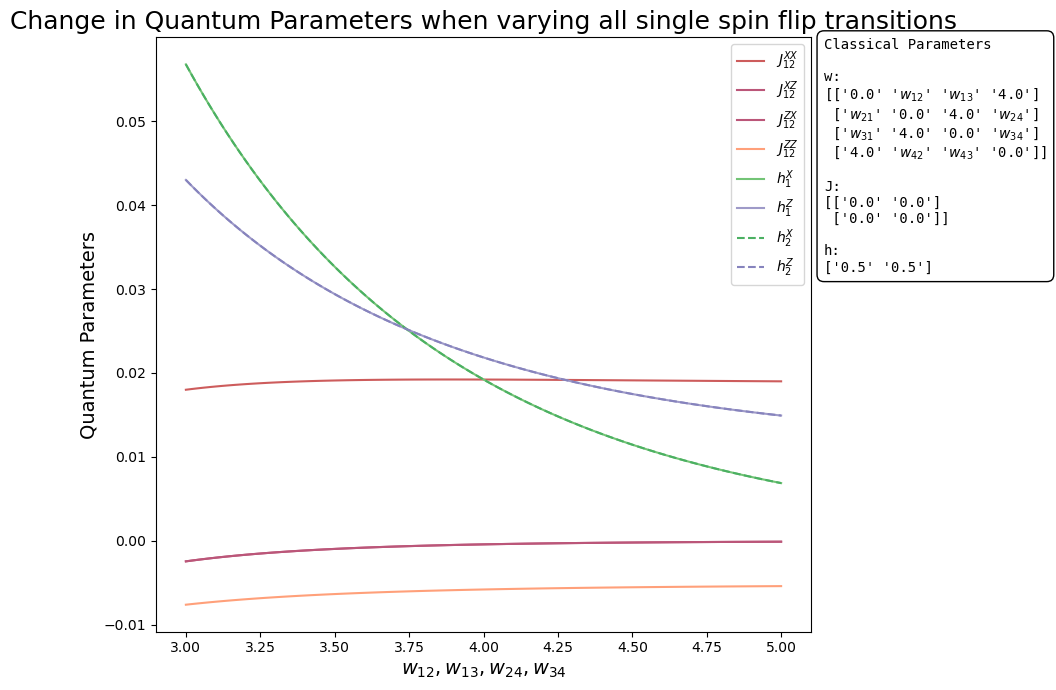

In [320]:
# initialize the classical parameters
N = 2
w = np.array([[0,4,4,4],
              [4,0,4,4],
              [4,4,0,4],
              [4,4,4,0]], dtype=np.float64)
J = np.array([[0, 0],
              [0, 0]],   dtype=np.float64)
h = np.array([.5,.5],      dtype=np.float64)

#check that parameters are valid
check_parameters(w, J, h)

# define the classical parameter that will be varied
params = ['w', 'w', 'w', 'w']
indices = [(0, 1), (0,2), (1,3), (2,3)]

# define the range over which the classical parameter will be varied
start = 3
end = 5
steps = 100

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$J_{12}^{ZX}$', '$h_{2}^{X}$','$h_{1}^{Z}$']
threshold = 0.001  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, params, indices, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)
title = 'Change in Quantum Parameters when varying all single spin flip transitions'
plot_forward_mapping(quantum_params, start, end, steps, params, indices, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True, title = title)


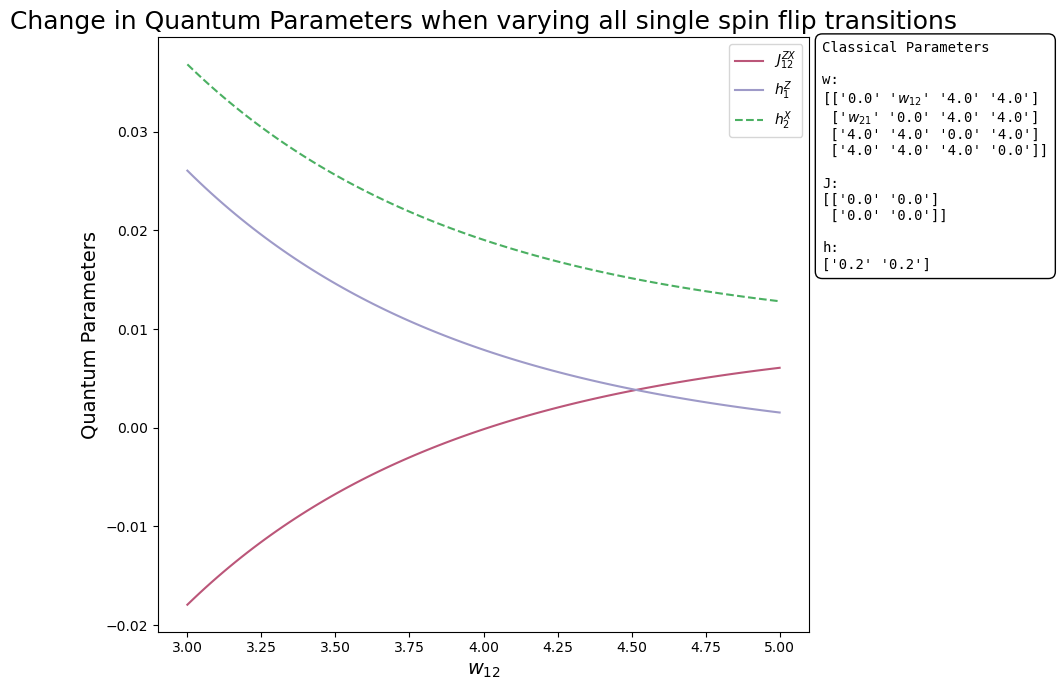

In [323]:
# initialize the classical parameters
N = 2
w = np.array([[0,4,4,4],
              [4,0,4,4],
              [4,4,0,4],
              [4,4,4,0]], dtype=np.float64)
J = np.array([[0, 0],
              [0, 0]],   dtype=np.float64)
h = np.array([.2,.2],      dtype=np.float64)

#check that parameters are valid
check_parameters(w, J, h)

# define the classical parameter that will be varied
params = ['w']
indices = [(0, 1)]

# define the range over which the classical parameter will be varied
start = 3
end = 5
steps = 100

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
qm_params_to_plot = ['$J_{12}^{ZX}$', '$h_{2}^{X}$','$h_{1}^{Z}$']
threshold = 0.001  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, params, indices, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)
title = 'Change in Quantum Parameters when varying all single spin flip transitions'
plot_forward_mapping(quantum_params, start, end, steps, params, indices, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True, title = title)


#### Varying single spin-flip transititions with interactions

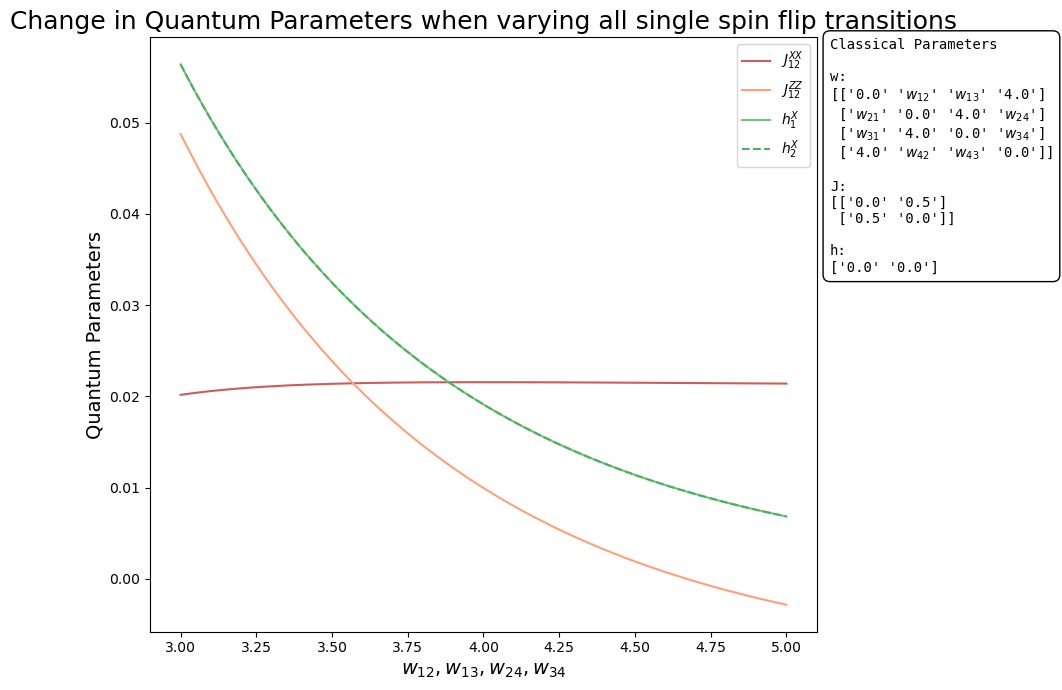

In [315]:
# initialize the classical parameters
N = 2
w = np.array([[0,4,4,4],
              [4,0,4,4],
              [4,4,0,4],
              [4,4,4,0]], dtype=np.float64)
J = np.array([[0, .5],
              [.5, 0]],   dtype=np.float64)
h = np.array([0,0],      dtype=np.float64)

#check that parameters are valid
check_parameters(w, J, h)

# define the classical parameter that will be varied
params = ['w', 'w', 'w', 'w']
indices = [(0, 1), (0,2), (1,3), (2,3)]

# define the range over which the classical parameter will be varied
start = 3
end = 5
steps = 100

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$h_{1}^{Z}$', '$h_{2}^{Z}$']
# qm_params_to_plot = ['$h_{1}^{X}$', '$h_{2}^{X}$', '$h_{1}^{Z}$', '$h_{2}^{Z}$','$J_{12}^{ZX}$']
# qm_params_to_plot = ['$h_{1}^{X}$']
threshold = 0.001  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, params, indices, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)
title = 'Change in Quantum Parameters when varying all single spin flip transitions'
plot_forward_mapping(quantum_params, start, end, steps, params, indices, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True, title = title)


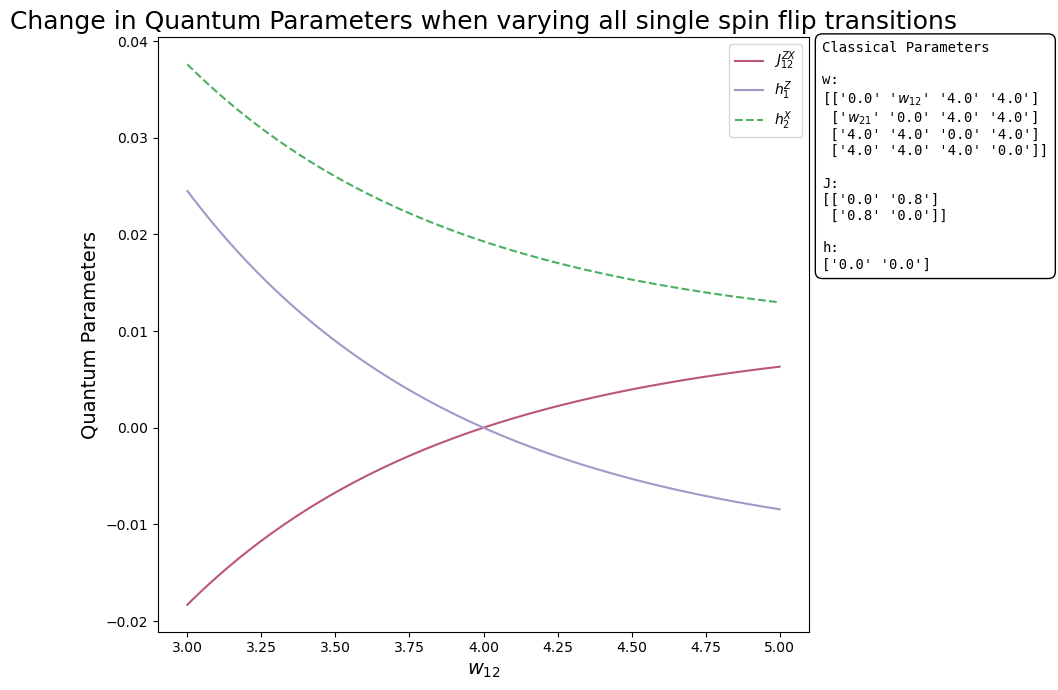

In [318]:
# initialize the classical parameters
N = 2
w = np.array([[0,4,4,4],
              [4,0,4,4],
              [4,4,0,4],
              [4,4,4,0]], dtype=np.float64)
J = np.array([[0, .8],
              [.8, 0]],   dtype=np.float64)
h = np.array([0,0],      dtype=np.float64)

#check that parameters are valid
check_parameters(w, J, h)

# define the classical parameter that will be varied
params = ['w']
indices = [(0, 1)]

# define the range over which the classical parameter will be varied
start = 3
end = 5
steps = 100

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$h_{1}^{Z}$', '$h_{2}^{Z}$']
# qm_params_to_plot = ['$h_{1}^{X}$', '$h_{2}^{X}$', '$h_{1}^{Z}$', '$h_{2}^{Z}$','$J_{12}^{ZX}$']
# qm_params_to_plot = ['$h_{1}^{X}$']
qm_params_to_plot = ['$J_{12}^{ZX}$', '$h_{2}^{X}$','$h_{1}^{Z}$']
threshold = 0.001  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, params, indices, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)
title = 'Change in Quantum Parameters when varying all single spin flip transitions'
plot_forward_mapping(quantum_params, start, end, steps, params, indices, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True, title = title)


#### Varying double spin-flip transititions without interactions or biases

#### Varying double spin-flip transititions with biases

#### Varying double spin-flip transititions with interactions

### Results 3-qubit

#### Varying J in homogenous system with zero biases

In [ ]:
# initialize the classical parameters
N = 2
w = np.ones((8,8), dtype = np.float64)
J = np.array([[0, 1],
              [1, 0]],   dtype=np.float64)
h = np.array([1e-6,1e-6],      dtype=np.float64)

#check if we got valid parameters
check_parameters(w, J, h)

# define the classical parameter that will be varied
param = 'J'
index = (0, 1)

# define the range over which the classical parameter will be varied
start = -1.4
end = 1.4
steps = 30

# intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .5
maxiter_qbm = 2**11

#only relevant for checking if the mapping is inverisble
learning_rate_bm = .8
maxiter_bm = 2**20

#check the inversion error to see if trajectory is valid:
check_inversion_error_forward(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
qm_params_to_plot = ['$J_{12}^{XX}$', '$J_{12}^{YY}$', '$J_{12}^{ZZ}$'] 
# qm_params_to_plot = ['$J_{12}^{ZZ}$'] 

threshold = 0.01  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm)
plot_forward_mapping(quantum_params, start, end, steps, param, index, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True)

Smaller biases

In [ ]:
# initialize the parameters
N = 3
w = np.array([[3, 3 ,3],
              [3, 3, 3],
              [3, 3, 3]], dtype = np.float64)

J = np.array([[0, 0, 0],
              [0 ,0, 0],
              [0, 0, 0]], dtype = np.float64)

h = np.array([.000001, .000001, .000001],   dtype = np.float64)

#check if we got valid parameters
check_parameters(w, J, h)

# define the classical parameter that will be varied
param = 'J'
index = (1, 2)

# define the range over which the classical parameter will be varied
start = -.7
end = .7
steps = 30

#check the inversion error to see if trajectory is valid:
check_inversion_error_forward(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)

# intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .5
maxiter_qbm = 2**11

#only relevant for checking if the mapping is inverisble
learning_rate_bm = .8
maxiter_bm = 2**20

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = ['$J_{12}^{ZZ}$', '$J_{12}^{YY}$'] 

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$J_{12}^{XX}$', '$J_{12}^{YY}$', '$J_{12}^{ZZ}$'] 
threshold = 0.01  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm)
plot_forward_mapping(quantum_params, start, end, steps, param, index, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True)

#### Varying J in homogenous system with small biases

In [ ]:
# initialize the parameters
N = 3
w = np.array([[3, 3 ,3],
              [3, 3, 3],
              [3, 3, 3]], dtype = np.float64)

J = np.array([[0, 0, 0],
              [0 ,0, 0],
              [0, 0, 0]], dtype = np.float64)

h = np.array([.75, .75, .75],   dtype = np.float64)

#check if we got valid parameters
check_parameters(w, J, h)

# define the classical parameter that will be varied
param = 'J'
index = (0, 1)

# define the range over which the classical parameter will be varied
start = 0
end = .70
steps = 30

#check the inversion error to see if trajectory is valid:
check_inversion_error_forward(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)

# intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .5
maxiter_qbm = 2**11

#only relevant for checking if the mapping is inverisble
learning_rate_bm = .8
maxiter_bm = 2**20

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = ['$J_{12}^{ZZ}$', '$J_{12}^{YY}$'] 

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
# qm_params_to_plot = None
# qm_params_to_plot = ['$J_{12}^{XX}$', '$J_{12}^{YY}$', '$J_{12}^{ZZ}$'] 
threshold = 0.01  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm)
plot_forward_mapping(quantum_params, start, end, steps, param, index, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True)

#### Varying J in homogenous system with large biases

In [ ]:
# initialize the parameters
N = 3
w = np.array([[3, 3 ,3],
              [3, 3, 3],
              [3, 3, 3]], dtype = np.float64)

J = np.array([[0, 0, 0],
              [0 ,0, 0],
              [0, 0, 0]], dtype = np.float64)

h = np.array([1.5 ,1e-10, 1e-10],   dtype = np.float64)

#check if we got valid parameters
check_parameters(w, J, h)

#### Varying h in homogenous system without interactions

In [ ]:
# initialize the parameters
N = 3
w = np.array([[3, 3 ,3],
              [3, 3, 3],
              [3, 3, 3]], dtype = np.float64)

J = np.array([[0, 0, 0],
              [0 ,0, 0],
              [0, 0, 0]], dtype = np.float64)

h = np.array([0 ,1e-10, 1e-10],   dtype = np.float64)

#check if we got valid parameters
check_parameters(w, J, h)

# define the classical parameter that will be varied
param = 'h'
index = (0, 0)

# define the range over which the classical parameter will be varied
start = -1.5
end = 1.5
steps = 30

# intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .5
maxiter_qbm = 2**11

#only relevant for checking if the mapping is inverisble
learning_rate_bm = .8
maxiter_bm = 2**20

#check the inversion error to see if trajectory is valid:
check_inversion_error_forward(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$J_{12}^{XX}$', '$J_{12}^{YY}$', '$J_{12}^{ZZ}$'] 
# qm_params_to_plot = ['$J_{12}^{ZZ}$'] 

threshold = 0.1  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm)
plot_forward_mapping(quantum_params, start, end, steps, param, index, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True)

#### Varying h in homogenous system with small interactions

#### Varying h in homogenous system with large interactions

#### Varying w in homogenous system without interactions or biases

#### Varying w in homogenous system with interactions and biases

### Results 4-qubit

#### Varying J in homogenous system with zero biases

In [ ]:
N = 4
w = np.ones((16,16), dtype = np.float64)
w = set_w_zero(w,N)

J = np.array([[0, 0, 0, 0],
                [0 ,0, 0, 0],
                [0 ,0, 0, 0],
                [0, 0, 0, 0]],    dtype = np.float64)

h = np.array([1e-7, 1e-7, 1e-7, 1e-7],dtype = np.float64)
check_parameters(w,J,h)

In [ ]:
dont_run =  False #skip this due to long computation time
if not dont_run: 
    # initialize the parameters
    N = 4
    w = np.array([[3, 3 ,3, 3],
                  [3, 3, 3, 3],
                  [3, 3, 3, 3],
                  [3, 3, 3, 3]], dtype = np.float64)

    J = np.array([[0, 0, 0, 0],
                  [0 ,0, 0, 0],
                  [0 ,0, 0, 0],
                  [0, 0, 0, 0]],    dtype = np.float64)

    h = np.array([1e-7, 1e-7, 1e-7, 1e-7],dtype = np.float64)
    check_parameters(w,J,h)

    # define the start, end and step size for the parameter change
    start = -.9
    end = .9
    steps = 3

    # define the parameter and index you want to change
    param = 'J'
    index = (0, 1)

    # intialize the optimal learning parameters for 2-qubits
    learning_rate_qbm = .5
    maxiter_qbm = 2**11

    #only relevant for checking if the mapping is inverisble
    learning_rate_bm = .8
    maxiter_bm = 2**20

    # specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
    qm_params_to_plot = None
    # qm_params_to_plot = ['$J_{12}^{XX}$', '$J_{12}^{YY}$', '$J_{12}^{ZZ}$'] 
    threshold = 0.1  #minimal change over sweep for the parameters to be plotted

    # call the function and plot the results
    quantum_params = analyze_forward_parameter_mapping(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm)
    plot_forward_mapping(quantum_params, start, end, steps, param, index, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True)

#### Varying J in homogenous system with small biases

#### Varying J in homogenous system with large biases

#### Varying h in homogenous system without interactions

- Check biases <-> sigma z correspondence


#### Varying h in homogenous system with small interactions

#### Varying h in homogenous system with large interactions

#### Varying w in homogenous system without interactions or biases

Parameters relating purely to the dynamics of the classical system map to parameters of a static system?

#### Varying w in homogenous system with interactions and biases

If both interactions are independent we can write the density matrix as a tensor product of the two qubit density matrices:

$\hat{eta}_{ij} = \hat{\rho}_i \otimes \hat{\rho}_j$
with  
$\eta_{i} = \frac{e^{h_z \hat{\sigma_z} + h_x \hat{\sigma_x}}}{Z_i} = \frac{1}{Z_i} \left[ \hat{I} \cosh(\sqrt{h_z^2 + h_x^2}) + \frac{h_x}{\sqrt{h_z^2 + h_x^2}} \sinh(\sqrt{h_z^2 + h_x^2}) \hat{\sigma_x} + \frac{h_z}{\sqrt{h_z^2 + h_x^2}} \sinh(\sqrt{h_z^2 + h_x^2}) \hat{\sigma_z} \right] $

[make eduardo check if this is true because I would not know or check it yourself if you dare]

We can abbreviate $H = \sqrt{h_z^2 + h_x^2}$ to write:
$\eta_{i} = \frac{1}{Z_i} \left[ \hat{I} \cosh(H) + \frac{h_x}{H} \sinh(H) \hat{\sigma_x} + \frac{h_z}{H} \sinh(H) \hat{\sigma_z} \right] $

BLEEEEH  
$Z_1 = Z \cosh(H) $

Using all this shit we can derive the following expressions:  

$\frac{h_x}{H} \tanh(H) = m_x = e^{-w}$ (1)  
$\frac{h_z}{H} \tanh(H) = e^{-w} \sinh(h_c)$ (2)  

from which we can derive that   
$h_x = \frac{H}{\tanh{H}} e^{-w} $  
$h_z = \frac{H}{\tanh{H}} e^{-w} \sinh(h_c)$  
$\frac{h_x}{h_z} = \sinh(h_c)$  
[$h_c$ is the classical bias]  

Squaring and adding (1) and (2) gives:  
$\tanh^2(H) = e^{-2w}[1+\sinh^2(h_c)]$  


## Inverse Reversibility

We can’t do the entire mapping backward because the quantum model is a ‘richer’ model, even just with two-body interactions. Due to the nature of the density matrix. This is already hinted at in the forward mapping, where the quantum model is capable of encoding dynamical effects that the BM is ‘blind’ to.  Even if you have only 2-body interactions in your QM hamiltonian, if you expand it in a matrix, you can still have higher order terms:

$$\rho = e^{\hat{H}} = 1 + \hat{H} + \frac{1}{2!} \hat{H}^2 + \frac{1}{3!} \hat{H}^3 + \frac{1}{4!} \hat{H}^4 + ...$$

This is why we can't expect the inverse mapping to work for most cases.

$$W^* = \sqrt{p} \hat{\rho} \frac{1}{\sqrt{p}}$$
$$W  = W(s \mid s) \delta_{s^{\prime}, s} + \sum_{i} g_{i}(s) \delta_{s^{\prime}, F_{i}[s]} +  \sum_{ij} g_{ij}(s) \delta_{s^{\prime}, F_{ij}[s]}$$  
$$W^* \neq W$$

What we can do however, is obtain a transition matrix from the quantum Hamiltonian and analyze it using different methods than a BM, for example by simulating it.  Use small enough QM paramaters otherwise there will be non-normalized probabilities or map to (too large) parameters again (causing numerical precision errors). Work in the .001 regime

The QBM can learn all possible parameters of the QM hamiltonian with 2-body interactions for arbitrary amount of qubits. WE showed this in '''Quantum Boltzmann Machine''' Notebook. What about higher order terms? Better to show that in that notebook, here just show the BM can not correctly infer a 3-qubit dynamics even with 2-body interactions.

### 2-qubit model is complete:

In [ ]:
#generate the weights using the dictionary
num_qubits = 2
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(num_qubits)

#Leave out the terms containing odd amounts of Y
interaction_weights[('I', 'I')] =  0

#hx1 > Jxz
interaction_weights[('I', 'X')] = .8   #hx1
interaction_weights[('X', 'Z')] = .5   #Jxz

#hx2 > Jzx
interaction_weights[('X', 'I')] = .6   #hx2
interaction_weights[('Z', 'X')] = .4   #Jzx

# Jxx > Jyy
interaction_weights[('X', 'X')] = .6   #Jxx
interaction_weights[('Y', 'Y')] = .4   #Jyy

# all Z-only terms < 1
interaction_weights[('I', 'Z')] = .1   #hz1
interaction_weights[('Z', 'I')] = .1   #hz2
interaction_weights[('Z', 'Z')] = .4   #Jzz

# make sure there are no imaginary components
interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)

#qm hamiltonian to density matrix
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 

# perform inverse mapping
W, w, J, h = inverse_mapping(w_qm, learning_rate_bm =.4 , maxiter_bm = 2**18, plot_convergence = False, perform_checks = True)
w_qm_recovered = forward_mapping(w, J, h, learning_rate_qbm= .4,  maxiter_qbm= 2**16, plot_convergence = True, perform_checks = True)

#plot the full dynamics
N = 2
steps = 2000
trajectory = simulate_dynamics(W, steps, N)
plot_combined_dynamics(trajectory, N, w_qm, w, J, h, title = 'Full dynamics', print_inferred_params = True)

#plot the dynamics inferred by the Boltzmann machine
W_bm = compute_transition_matrix(w, h, J)
trajectory_bm = simulate_dynamics(W_bm, steps, N)
plot_combined_dynamics(trajectory_bm, N, w_qm, w, J, h, title= 'BM inferred dynamics', print_inferred_params = True)

print(f'Error in transition matrices [BM ERROR]: \n {W - W_bm}')
print(f'Error in quantum parameters [QBM ERROR]: \n {w_qm - w_qm_recovered}')


### 3-qubits

#### With 2-body interactions in QM Hamiltonian

In [ ]:
N = 3
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)

#Leave out the terms containing odd amounts of Y
interaction_weights[('I', 'I', 'I')] = 0    #log(Z)

#hxi > Jxzij + jxzik
interaction_weights[('X', 'I', 'I')] = .5   #hx1
interaction_weights[('X', 'Z', 'I')] = .1   #Jxz12
interaction_weights[('X', 'I', 'Z')] = .2   #Jxz13

interaction_weights[('I', 'X', 'I')] = .4   #hx2
interaction_weights[('I', 'X', 'Z')] = .1   #Jxz23
interaction_weights[('Z', 'X', 'I')] = .1   #Jzx12

interaction_weights[('I', 'I', 'X')] = .8   #hx3
interaction_weights[('I', 'Z', 'X')] = .2   #Jzx23
interaction_weights[('Z', 'I', 'X')] = .3   #Jzx13


# Jxx > Jyy
interaction_weights[('X', 'X', 'I')] = .6   #Jxx12
interaction_weights[('Y', 'Y', 'I')] = .4   #Jyy12

interaction_weights[('I', 'X', 'X')] = .7   #Jxx23
interaction_weights[('I', 'Y', 'Y')] = .4   #Jyy23

interaction_weights[('X', 'I', 'X')] = .8   #Jxx13
interaction_weights[('Y', 'I', 'Y')] = .4   #Jyy13


# all Z-only terms < 1
interaction_weights[('Z', 'I', 'I')] = .1   #hz1
interaction_weights[('I', 'Z', 'I')] = .1   #hz2
interaction_weights[('I', 'I', 'Z')] = .1   #hz3

interaction_weights[('Z', 'Z', 'I')] = .3   #Jzz12
interaction_weights[('Z', 'I', 'Z')] = .3   #Jzz13
interaction_weights[('I', 'Z', 'Z')] = .3   #Jzz23

# make sure there are no imaginary components
interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)

#qm hamiltonian to density matrix
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 

#set learning rates BM
maxiter_bm = 2**20
learning_rate_bm = 0.5

# perform inverse mapping
W, w, J, h = inverse_mapping(w_qm, learning_rate_bm =.4 , maxiter_bm = 2**18, plot_convergence = False, perform_checks = True)

#convert it to a target density matrix
eta = transition_matrix_to_density_matrix(W)

# test if W and eta are valid
test_transition_matrix(W)
check_density_matrix(eta)

# learning parameters qbm
tolerance = 1e-14
random_seed = 444
learning_rate_qbm = 0.5
maxiter_qbm = 2**20

# set initial weights for QBM
interaction_matrices, interaction_labels, _ = generate_interaction_matrices(N)
w_initial= generate_random_parameter_matrix(random_seed + 1, N, interaction_labels)

#infer its parameters using the QBM
w_qm_recovered, lk, kl, Wdiff, it = quantum_boltzmann_machine(interaction_matrices, learning_rate_qbm, maxiter_qbm, tolerance, w_initial, eta=eta)
plot(it, Wdiff, kl, lk, title='QBM Convergence', size=10)

#plot the full dynamics
N = 2
steps = 2000
trajectory = simulate_dynamics(W, steps, N)
plot_combined_dynamics(trajectory, N, w_qm, w, J, h, title = 'Full dynamics', print_inferred_params = True)

#plot the dynamics inferred by the Boltzmann machine
W_bm = compute_transition_matrix(w, h, J)
trajectory_bm = simulate_dynamics(W_bm, steps, N)
plot_combined_dynamics(trajectory_bm, N, w_qm, w, J, h, title= 'BM inferred dynamics', print_inferred_params = True)

print(W - W_bm)

print(f'Error in transition matrices [BM ERROR]: \n {W - W_bm}')
print(f'Error in quantum parameters [QBM ERROR]: \n {w_qm - w_qm_recovered}')

#### With 3-body interactions in QM Hamiltonian

In [ ]:
N = 3
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)

#Leave out the terms containing odd amounts of Y
interaction_weights[('I', 'I', 'I')] = 0    #log(Z)

#hxi > Jxzij + jxzik
interaction_weights[('X', 'I', 'I')] = .5   #hx1
interaction_weights[('X', 'Z', 'I')] = .1   #Jxz12
interaction_weights[('X', 'I', 'Z')] = .2   #Jxz13

interaction_weights[('I', 'X', 'I')] = .4   #hx2
interaction_weights[('I', 'X', 'Z')] = .1   #Jxz23
interaction_weights[('Z', 'X', 'I')] = .1   #Jzx12

interaction_weights[('I', 'I', 'X')] = .8   #hx3
interaction_weights[('I', 'Z', 'X')] = .2   #Jzx23
interaction_weights[('Z', 'I', 'X')] = .3   #Jzx13


# Jxx > Jyy
interaction_weights[('X', 'X', 'I')] = .6   #Jxx12
interaction_weights[('Y', 'Y', 'I')] = .4   #Jyy12

interaction_weights[('I', 'X', 'X')] = .7   #Jxx23
interaction_weights[('I', 'Y', 'Y')] = .4   #Jyy23

interaction_weights[('X', 'I', 'X')] = .8   #Jxx13
interaction_weights[('Y', 'I', 'Y')] = .4   #Jyy13


# all Z-only terms < 1
interaction_weights[('Z', 'I', 'I')] = .1   #hz1
interaction_weights[('I', 'Z', 'I')] = .1   #hz2
interaction_weights[('I', 'I', 'Z')] = .1   #hz3

interaction_weights[('Z', 'Z', 'I')] = .3   #Jzz12
interaction_weights[('Z', 'I', 'Z')] = .3   #Jzz13
interaction_weights[('I', 'Z', 'Z')] = .3   #Jzz23

# Higher order terms
interaction_weights[('X', 'Y', 'Y')] = .1   
interaction_weights[('Y', 'X', 'Y')] = .1   
interaction_weights[('Y', 'Y', 'X')] = .1  

interaction_weights[('X', 'Z', 'Z')] = .1   
interaction_weights[('Z', 'X', 'Z')] = .1   
interaction_weights[('Z', 'Z', 'X')] = .1   

interaction_weights[('Z', 'X', 'X')] = .1   
interaction_weights[('X', 'Z', 'X')] = .1   
interaction_weights[('X', 'X', 'Z')] = .1   

interaction_weights[('X', 'X', 'X')] = .1   
interaction_weights[('Z', 'Z', 'Z')] = .1   

# make sure there are no imaginary components
interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)

#qm hamiltonian to density matrix
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 

#set learning rates BM
maxiter_bm = 2**20
learning_rate_bm = 0.5

# perform inverse mapping
W, w, J, h = inverse_mapping(w_qm, learning_rate_bm =.4 , maxiter_bm = 2**18, plot_convergence = False, perform_checks = True)

#convert it to a target density matrix
eta = transition_matrix_to_density_matrix(W)

# test if W and eta are valid
test_transition_matrix(W)
check_density_matrix(eta)

# learning parameters qbm
tolerance = 1e-14
random_seed = 444
learning_rate_qbm = 0.5
maxiter_qbm = 2**20

# set initial weights for QBM
interaction_matrices, interaction_labels, _ = generate_interaction_matrices(N)
w_initial= generate_random_parameter_matrix(random_seed + 1, N, interaction_labels)

#infer its parameters using the QBM
w_qm_recovered, lk, kl, Wdiff, it = quantum_boltzmann_machine(interaction_matrices, learning_rate_qbm, maxiter_qbm, tolerance, w_initial, eta=eta)
plot(it, Wdiff, kl, lk, title='QBM Convergence', size=10)

#plot the full dynamics
N = 2
steps = 2000
trajectory = simulate_dynamics(W, steps, N)
plot_combined_dynamics(trajectory, N, w_qm, w, J, h, title = 'Full dynamics', print_inferred_params = True)

#plot the dynamics inferred by the Boltzmann machine
W_bm = compute_transition_matrix(w, h, J)
trajectory_bm = simulate_dynamics(W_bm, steps, N)
plot_combined_dynamics(trajectory_bm, N, w_qm, w, J, h, title= 'BM inferred dynamics', print_inferred_params = True)

print(f'Error in transition matrices [BM ERROR]: \n {W - W_bm}')
print(f'Error in quantum parameters [QBM ERROR]: \n {w_qm - w_qm_recovered}')

## Inverse Mapping

### 2-Qubits Result

In [ ]:
# PARAMETERS FOR ALL 2-QUBIT PLOTS   
#----------------------------------------------------------
N = 2

learning_rate_bm = .8
maxiter_bm = 2**18

learning_rate_qbm = .7
maxiter_qbm = 2**16

threshold = 1e-3

#### Influence of $h^x$ terms

$h^{x}$ correspond to flipping rates of the dynamics and map to the classical single-spin flip transition parameters $w$. For all further plots, we will set a small flipping rate on both spins, to ensure the transition matrix is always ergodic and to be able to visualize the results better.

In [ ]:
# initialize the qm parameters using the weight dictionary
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)

# change these to increase the single spin flip rates
interaction_weights[('X', 'I')] = .002   #hx1
interaction_weights[('I', 'X')] = .002   #hx2

interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)
w_qm = weights_dict_to_array(interaction_labels, interaction_weights)

# define the quantum parameter that will be varied
quantum_param_label = ('X','I')

# define the range over which the classical parameter will be varied
start = .001
end = .005
steps = 50
simulation_steps = 10000

# specify the classical parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
# classical_params_to_plot = None
classical_params_to_plot = ['$w_{14}$', '$w_{23}$']
threshold = 0.01

# perform inverse mapping and plot the results
W_vals, w_vals, J_vals, h_vals = analyze_inverse_parameter_mapping(start, end, steps, quantum_param_label, w_qm, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm, higher_order_terms = False)
plot_inverse_mapping(w_vals, J_vals, h_vals, start, end, steps, quantum_param_label, w_qm, classical_params_to_plot, threshold)
plot_left_right_dynamics(start, end, steps, quantum_param_label, simulation_steps, w_qm, W_vals)

#### Influence of $h^z$ term

$h_i^z$ correspond to the classical bias $h_i$.

In [ ]:
# initialize the qm parameters using the weight dictionary
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)

# set small single spin flip rates for ergodicity
interaction_weights[('X', 'I')] = .001   #hx1
interaction_weights[('I', 'X')] = .001   #hx2

interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)
w_qm = weights_dict_to_array(interaction_labels, interaction_weights)

# define the quantum parameter that will be varied
quantum_param_label = ('I','Z')

# define the range over which the classical parameter will be varied
start = -.005
end = .005
steps = 50
simulation_steps = 10000

# specify the classical parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
classical_params_to_plot = None
# classical_params_to_plot = ['$w_{14}$', '$w_{23}$', '$J_{12}$']
threshold = 0.01

# perform inverse mapping and plot the results
W_vals, w_vals, J_vals, h_vals = analyze_inverse_parameter_mapping(start, end, steps, quantum_param_label, w_qm, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm, higher_order_terms = False)
plot_inverse_mapping(w_vals, J_vals, h_vals, start, end, steps, quantum_param_label, w_qm, classical_params_to_plot, threshold)
plot_left_right_dynamics(start, end, steps, quantum_param_label, simulation_steps, w_qm, W_vals)

#### Influence of $J^{xz}$ and $J^{zx}$ terms

The XZ terms connect the bias of one spin to the flipping rate of the other spin. If we set $J^{xz} > 0$, then increasing the flipping rate of spin 1 means increasing the bias of spin 2. If we set $J^{xz} < 0$, then increasing the flipping rate of spin 1 means decreasing the bias of spin 2. The ZX terms does the same but with the roles of spin 1 and 2 reversed.

In [ ]:
# initialize the qm parameters using the weight dictionary
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)

# set small single spin flip rates for ergodicity
interaction_weights[('X', 'I')] = .01   #hx1
interaction_weights[('I', 'X')] = .01   #hx2

interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)
w_qm = weights_dict_to_array(interaction_labels, interaction_weights)

# define the quantum parameter that will be varied
quantum_param_label = ('X','Z')

# define the range over which the classical parameter will be varied. Make sure its smaller than the single spin flip rates otherwise we have an invalid domain.
start = -.008
end = .008
steps = 50
simulation_steps = 10000

# specify the classical parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
classical_params_to_plot = None
# classical_params_to_plot = ['$w_{14}$', '$w_{23}$', '$J_{12}$']
threshold = 0.01

# perform inverse mapping and plot the results
W_vals, w_vals, J_vals, h_vals = analyze_inverse_parameter_mapping(start, end, steps, quantum_param_label, w_qm, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm, higher_order_terms = False)
plot_inverse_mapping(w_vals, J_vals, h_vals, start, end, steps, quantum_param_label, w_qm, classical_params_to_plot, threshold)
plot_left_right_dynamics(start, end, steps, quantum_param_label, simulation_steps, w_qm, W_vals)

To be sure this is the function of XZ, we also check how altering the flipping rate of spin 1 affects the bias of spin 2 for a constant value of XZ. Vice versa, we also check how altering the bias of spin 2 affects the flipping rate of spin 1.

Appears hypothesis is wrong? Either its one way (changing bias changes flipping rate but not vice versa) or JXZ is related to dynamical effects?

In [ ]:
# initialize the qm parameters using the weight dictionary
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)


#set constant xz or zx interaction
#hx1 > Jxz
interaction_weights[('X', 'I')] = .001   #hx1
interaction_weights[('X', 'Z')] = -.0008  #Jxz

#hx2 > Jzx
interaction_weights[('I', 'X')] = .001   #hx2
interaction_weights[('Z', 'X')] = .0    # Jzx

interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)
w_qm = weights_dict_to_array(interaction_labels, interaction_weights)

# sweep over the flipping rate of spin 1
quantum_param_label = ('X','I')

# define the range over which the classical parameter will be varied
start = .001
end = .02
steps = 50
simulation_steps = 60000

# specify the classical parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
classical_params_to_plot = None
# classical_params_to_plot = ['$w_{14}$']
# classical_params_to_plot = ['$w_{13}$', '$w_{24}$']
threshold = 0.01

# perform inverse mapping and plot the results
title = 'Sweep over flipping rate of spin 1 for negative $J_{12}^{XZ}$'
W_vals, w_vals, J_vals, h_vals = analyze_inverse_parameter_mapping(start, end, steps, quantum_param_label, w_qm, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm, higher_order_terms = False)
plot_inverse_mapping(w_vals, J_vals, h_vals, start, end, steps, quantum_param_label, w_qm, classical_params_to_plot, threshold,  title = title)
plot_left_right_dynamics(start, end, steps, quantum_param_label, simulation_steps, w_qm, W_vals, title)

In [ ]:
# initialize the qm parameters using the weight dictionary
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)


#set constant xz or zx interaction
#hx1 > Jxz
interaction_weights[('X', 'I')] = .01  #hx1
interaction_weights[('X', 'Z')] = -.007  #Jxz

#hx2 > Jzx
interaction_weights[('I', 'X')] = .01  #hx2
# interaction_weights[('Z', 'X')] = .0    #Jzx

interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)
w_qm = weights_dict_to_array(interaction_labels, interaction_weights)

# sweep over bias of spin 2
quantum_param_label = ('I','Z')

# define the range over which the classical parameter will be varied
start = -0.05
end = .05
steps = 50
simulation_steps = 2000

# specify the classical parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
classical_params_to_plot = None
# classical_params_to_plot = ['$w_{12}$', '$h_{2}$']
# classical_params_to_plot = ['$w_{13}$', '$h_{2}$']
# classical_params_to_plot = ['$w_{14}$', '$h_{2}$']

# perform inverse mapping and plot the results
title = 'Sweep over bias of spin 2 for negative $J_{12}^{XZ}$'
W_vals, w_vals, J_vals, h_vals = analyze_inverse_parameter_mapping(start, end, steps, quantum_param_label, w_qm, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm, higher_order_terms = False)
plot_inverse_mapping(w_vals, J_vals, h_vals, start, end, steps, quantum_param_label, w_qm, classical_params_to_plot, threshold, title)
plot_left_right_dynamics(start, end, steps, quantum_param_label, simulation_steps, w_qm, W_vals, title)

#### Influence of $J^{zz}$ term


In [ ]:
# initialize the qm parameters using the weight dictionary
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)

# set small single spin flip rates for ergodicity
interaction_weights[('X', 'I')] = .001   #hx1
interaction_weights[('I', 'X')] = .001   #hx2

interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)
w_qm = weights_dict_to_array(interaction_labels, interaction_weights)

# define the quantum parameter that will be varied
quantum_param_labels = ('Z','Z')

# define the range over which the classical parameter will be varied
start = -.005
end = .005
steps = 50
simulation_steps = 20000

# specify the classical parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
classical_params_to_plot = None
# classical_params_to_plot = ['$w_{14}$', '$w_{23}$', '$J_{12}$']

# perform inverse mapping and plot the results
W_vals, w_vals, J_vals, h_vals = analyze_inverse_parameter_mapping(start, end, steps, quantum_param_label, w_qm, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm, higher_order_terms = False)
plot_inverse_mapping(w_vals, J_vals, h_vals, start, end, steps, quantum_param_label, w_qm, classical_params_to_plot, threshold)
plot_left_right_dynamics(start, end, steps, quantum_param_label, simulation_steps, w_qm, W_vals)

#### Influence of $J^{xx}$ term

In [ ]:
# initialize the qm parameters using the weight dictionary
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)

# set small single spin flip rates for ergodicity
interaction_weights[('X', 'I')] = .001   #hx1
interaction_weights[('I', 'X')] = .001   #hx2

interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)
w_qm = weights_dict_to_array(interaction_labels, interaction_weights)

# define the quantum parameter that will be varied
quantum_param_label = ('X','X')

# define the range over which the classical parameter will be varied
start = .001
end = .01
steps = 50
simulation_steps = 1000

# specify the classical parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
classical_params_to_plot = None
# classical_params_to_plot = ['$w_{14}$', '$w_{23}$', '$J_{12}$']

# perform inverse mapping and plot the results
W_vals, w_vals, J_vals, h_vals = analyze_inverse_parameter_mapping(start, end, steps, quantum_param_label, w_qm, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm, higher_order_terms = False)
plot_inverse_mapping(w_vals, J_vals, h_vals, start, end, steps, quantum_param_label, w_qm, classical_params_to_plot, threshold)
plot_left_right_dynamics(start, end, steps, quantum_param_label, simulation_steps, w_qm, W_vals)

#### Influence of $J^{yy}$ term

Hypothesis 1: Jyy connects double flip rate with interaction strength (2nd order bias) in the same way Jxz connects bias of one spin with flip rate of the other spin.  
Hypothesis 2: The sum and difference of Jxx and Jyy encode the flipping synchronisation between the spins. Jzz then encodes the synchronization between the spins due to toplogical connection. Jxx + Jyy encode the synchronization due to external effects

Note: Jyy is zero when classical J is zero. 

In [ ]:
# initialize the qm parameters using the weight dictionary
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)

# set small single spin flip rates for ergodicity
interaction_weights[('X', 'I')] = .0005   #hx1
interaction_weights[('I', 'X')] = .0005   #hx2

interaction_weights[('X', 'X')] = .001    #Jxx

interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)
w_qm = weights_dict_to_array(interaction_labels, interaction_weights)

# define the quantum parameter that will be varied
quantum_param_labels = [('Z','Z'),('Y','Y')]
anti_synchronize = True
threshold = 1e-12

# define the range over which the classical parameter will be varied
start =  0
ends  =  .0009
steps = 50
simulation_steps = 40000

# specify the classical parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
classical_params_to_plot = None
classical_params_to_plot = ['$w_{14}$', '$w_{23}$', '$J_{12}$']

# perform inverse mapping and plot the results
W_vals, w_vals, J_vals, h_vals = analyze_inverse_parameter_mapping(start, end, steps, quantum_param_labels, w_qm, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm, higher_order_terms = False, anti_synchronize = anti_synchronize)
plot_inverse_mapping(w_vals, J_vals, h_vals, start, end, steps, quantum_param_labels, w_qm, classical_params_to_plot, threshold, anti_synchronize=anti_synchronize)
plot_left_right_dynamics(start, end, steps, quantum_param_labels, simulation_steps, w_qm, W_vals)

Do the same shit as with XZ

In [ ]:
# initialize the qm parameters using the weight dictionary
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)

# set small single spin flip rates for ergodicity
interaction_weights[('X', 'I')] = .0005   #hx1
interaction_weights[('I', 'X')] = .0005   #hx2

interaction_weights[('Y', 'Y')] = -.001    #Jyy

interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)
w_qm = weights_dict_to_array(interaction_labels, interaction_weights)

# define the quantum parameter that will be varied
quantum_param_label = ('X','X')

# define the range over which the classical parameter will be varied
start = .001
end = .005
steps = 45
simulation_steps = 40000

# specify the classical parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
classical_params_to_plot = None
classical_params_to_plot = ['$w_{14}$', '$w_{23}$', '$J_{12}$']

# perform inverse mapping and plot the results
title = 'Sweep over $J_{12}^{XX}$ for negative $J_{12}^{YY}$'
W_vals, w_vals, J_vals, h_vals = analyze_inverse_parameter_mapping(start, end, steps, quantum_param_label, w_qm, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm, higher_order_terms = False)
plot_inverse_mapping(w_vals, J_vals, h_vals, start, end, steps, quantum_param_label, w_qm, learning_rate_bm, maxiter_bm, classical_params_to_plot, threshold, title)
plot_left_right_dynamics(start, end, steps, quantum_param_label, simulation_steps, w_qm, W_vals, title)

In [ ]:
# initialize the qm parameters using the weight dictionary
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)

# set small single spin flip rates for ergodicity
interaction_weights[('X', 'I')] = .0005   #hx1
interaction_weights[('I', 'X')] = .0005   #hx2

interaction_weights[('X', 'X')] = .001    #Jxx
interaction_weights[('Y', 'Y')] = -.0008   #Jyy


interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)
w_qm = weights_dict_to_array(interaction_labels, interaction_weights)

# define the quantum parameter that will be varied
quantum_param_label = ('Z','Z')

# define the range over which the classical parameter will be varied
start = -.001
end = .001
steps = 50
simulation_steps = 40000

# specify the classical parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
classical_params_to_plot = None
# classical_params_to_plot = ['$w_{14}$', '$w_{23}$', '$J_{12}$']

# perform inverse mapping and plot the results
title = 'Sweep over $J_{12}^{ZZ}$ for negative $J_{12}^{YY}$'
W_vals, w_vals, J_vals, h_vals = analyze_inverse_parameter_mapping(start, end, steps, quantum_param_label, w_qm, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm, higher_order_terms = False)
plot_inverse_mapping(w_vals, J_vals, h_vals, start, end, steps, quantum_param_label, w_qm, learning_rate_bm, maxiter_bm, classical_params_to_plot, threshold, title)
plot_left_right_dynamics(start, end, steps, quantum_param_label, simulation_steps, w_qm, W_vals, title)

### Three-body interactions

Set higher_order_interactions to True

In [ ]:
analyze_inverse_parameter_mapping(start, end, steps, quantum_param_label, w_qm, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm, higher_order_terms = False, classical_params_to_plot = None, threshold=0.01)


In [ ]:
# PARAMETERS FOR ALL 3-QUBIT PLOTS   
#----------------------------------------------------------
N = 3

learning_rate_bm = .8
maxiter_bm = 2**18

learning_rate_qbm = .7
maxiter_qbm = 2**16

# specify the minimal change threshold
threshold = 0.01

In [ ]:
#generate the weights using the dictionary
num_qubits = 3
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(num_qubits)

#hx2 > Jzx
interaction_weights[('X', 'X', 'X')] = 0.05   
# interaction_weights[('X', 'I', 'I')] = 0.001   #hx1
# interaction_weights[('I', 'X', 'I')] = 0.001   #hx2
# interaction_weights[('I', 'I', 'X')] = 0.001   #hx3


# make sure there are no imaginary components
interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)

#qm hamiltonian to density matrix
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 

# perform inverse mapping
W, w, J, h = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence = False, perform_checks = True)

#plot the dynamics
N = 3
steps = 1000
trajectory = simulate_dynamics(W, steps, N)
plot_combined_dynamics(trajectory, N, w_qm, w, J , h, title = 'Influence of $\sigma_{123}^{XXX}$ on dynamics', print_inferred_params = False, print_only_nonzero = True)    

In [ ]:
#generate the weights using the dictionary
num_qubits = 3
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(num_qubits)

#hx2 > Jzx
interaction_weights[('X', 'X', 'X')] = 0.06  
# interaction_weights[('X', 'Y', 'Y')] = -0.05
# interaction_weights[('X', 'I', 'I')] = 0.04   #hx1
# interaction_weights[('I', 'X', 'I')] = 0.04   #hx2
# interaction_weights[('I', 'I', 'X')] = 0.04   #hx3


# make sure there are no imaginary components
interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)

#qm hamiltonian to density matrix
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 

# perform inverse mapping
W, w, J, h = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence = False, perform_checks = True)

#plot the dynamics
N = 3
steps = 1000
trajectory = simulate_dynamics(W, steps, N, s =np.array([-1,-1,-1]))
plot_combined_dynamics(trajectory, N, w_qm, w, J , h, title = 'Influence of $\sigma_{123}^{XXX}$ on dynamics', print_inferred_params = False, print_only_nonzero = True)    

### Higher order YYYY couplings

In [ ]:
#generate the weights using the dictionary
num_qubits = 4
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(num_qubits)

#hx2 > Jzx
interaction_weights[('X', 'X', 'X', 'X')] = 0.08
interaction_weights[('Y', 'Y', 'Y', 'Y')] = 0.07
# interaction_weights[('X', 'I', 'I', 'I')] = 0.01   #hx1
# interaction_weights[('I', 'X', 'I', 'I')] = 0.01   #hx2
# interaction_weights[('I', 'I', 'X', 'I')] = 0.01   #hx3
# interaction_weights[('I', 'I', 'I', 'X')] = 0.01   #hx4


# make sure there are no imaginary components
interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)

#qm hamiltonian to density matrix
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 

# perform inverse mapping
W, w, J, h = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence = False, perform_checks = False)

#plot the dynamics
N = 4
steps = 1000
trajectory = simulate_dynamics(W, steps, N, s = np.array([-1,-1, 1, 1]))
plot_combined_dynamics(trajectory, N, w_qm, w, J , h, title = 'Influence of $\sigma_{1234}^{YYYY}$ on dynamics', print_inferred_params = False, print_only_nonzero = True)    

In [ ]:
def check_detailed_balance(W):
    """
    Check if the transition matrix W and stationary distribution pi satisfy the detailed balance condition.
    """
    pi = steady_state(W)
    n_states = W.shape[0]
    for i in range(n_states):
        for j in range(n_states):
            assert np.isclose(W[i, j] * pi[i], W[j, i] * pi[j]), "Transition matrix does not satisfy detailed balance"

In [ ]:
# initialize the classical parameters
N = 2
w = np.array([[8,9],
              [9,8]], dtype=np.float64)
J = np.array([[1,4],
              [4,2]], dtype=np.float64)
h = np.array([0, 2],  dtype=np.float64)

W = compute_transition_matrix(w,h,J)

check_detailed_balance(W)

We hypothesise that the assymetric part of the transition matrix maps to the imaginary components of the density matrix. We can check this by looking at the assymetric part of the transition matrix and see if it maps to the imaginary components of the density matrix.

We can do so as follows:

$\Pi = diag(p(s))$  
$F = \Pi W$   Corresponds to probability flux, rewritten in terms of the transition matrix:
$W = \Pi^{-1} F$
We can split the flux in a symmetric and assymetric part:  
$F_{S} = \frac{F + F^T}{2} , F_{A} = \frac{F - F^T}{2} $  
Which we can rewrite in terms of the symmetric and antisymmetric transition matrix:
$W_{S} = \Pi^{-1} F_{S}, W_{A} = \Pi^{-1} F_{A}$  

$W_{S} = \Pi^{-1} \frac{F + F^T}{2} = \frac{\Pi^{-1} F + \Pi^{-1} F^T}{2} = \frac{W + \Pi W^{T} \Pi^{-1}}{2}$

With $F^T = (W \Pi)^T = \Pi^T W^T = \Pi W^T$
  
Combining these results, we can write
$W_{S/A} = \left[\frac{W \pm \Pi W^{T} \Pi^{-1}}{2}\right]$ 

Splitting W into a symmetric and assymetric part. Maybe we can split into a symmetric part and assymetric part and individually see to which QM parameters these transition matrices map back. In the symmetric case, we can also map it back to classical parameters.



We know that that the odd y-terms of the QM hamiltonian map to imaginary parts. So if we can find this link, we can link the odd y-terms to a dynamics that does not satisfy detailed balance, which would be interesting. Then we know other qm-parameters that map to dynamical classical parameters.


### 2, 3 and 4 Qubit template

In [ ]:
#generate the weights using the dictionary
num_qubits = 2
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(num_qubits)

#Leave out the terms containing odd amounts of Y
interaction_weights[('I', 'I')] =  0

#hx1 > Jxz
interaction_weights[('X', 'I')] = 0   #hx1
interaction_weights[('X', 'Z')] = 0   #Jxz

#hx2 > Jzx
interaction_weights[('I', 'X')] = 0   #hx2
interaction_weights[('Z', 'X')] = 0   #Jzx

# Jxx > Jyy
interaction_weights[('X', 'X')] = 0.05 #Jxx
interaction_weights[('Y', 'Y')] = 0    #Jyy

# all Z-only terms < 1
interaction_weights[('I', 'Z')] = 0   #hz1
interaction_weights[('Z', 'I')] = 0   #hz2
interaction_weights[('Z', 'Z')] = 0   #Jzz

# make sure there are no imaginary components
interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)

#qm hamiltonian to density matrix
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 

# perform inverse mapping
W, w, J, h = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence = False, perform_checks = True)

#plot the dynamics
N = 2
steps = 1000
trajectory = simulate_dynamics(W, steps, N)
plot_combined_dynamics(trajectory, N)

In [ ]:
num_qubits = 3
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(num_qubits)

#Leave out the terms containing odd amounts of Y
interaction_weights[('I', 'I', 'I')] = 0    #log(Z)

#hxi > Jxzij + jxzik
interaction_weights[('X', 'I', 'I')] = .5   #hx1
interaction_weights[('X', 'Z', 'I')] = .1   #Jxz12
interaction_weights[('X', 'I', 'Z')] = .2   #Jxz13

interaction_weights[('I', 'X', 'I')] = .4   #hx2
interaction_weights[('I', 'X', 'Z')] = .1   #Jxz23
interaction_weights[('Z', 'X', 'I')] = .1   #Jzx12

interaction_weights[('I', 'I', 'X')] = .8   #hx3
interaction_weights[('I', 'Z', 'X')] = .2   #Jzx23
interaction_weights[('Z', 'I', 'X')] = .3   #Jzx13


# Jxx > Jyy
interaction_weights[('X', 'X', 'I')] = .6   #Jxx12
interaction_weights[('Y', 'Y', 'I')] = .4   #Jyy12

interaction_weights[('I', 'X', 'X')] = .7   #Jxx23
interaction_weights[('I', 'Y', 'Y')] = .4   #Jyy23

interaction_weights[('X', 'I', 'X')] = .8   #Jxx13
interaction_weights[('Y', 'I', 'Y')] = .4   #Jyy13


# all Z-only terms < 1
interaction_weights[('Z', 'I', 'I')] = .1   #hz1
interaction_weights[('I', 'Z', 'I')] = .1   #hz2
interaction_weights[('I', 'I', 'Z')] = .1   #hz3

interaction_weights[('Z', 'Z', 'I')] = .3   #Jzz12
interaction_weights[('Z', 'I', 'Z')] = .3   #Jzz13
interaction_weights[('I', 'Z', 'Z')] = .3   #Jzz23]

# Higher order terms
interaction_weights[('X', 'Y', 'Y')] = .1   
interaction_weights[('Y', 'X', 'Y')] = .1   
interaction_weights[('Y', 'Y', 'X')] = .1  

interaction_weights[('X', 'Z', 'Z')] = .1   
interaction_weights[('Z', 'X', 'Z')] = .1   
interaction_weights[('Z', 'Z', 'X')] = .1   

interaction_weights[('Z', 'X', 'X')] = .1   
interaction_weights[('X', 'Z', 'X')] = .1   
interaction_weights[('X', 'X', 'Z')] = .1   

interaction_weights[('X', 'X', 'X')] = .1   
interaction_weights[('Z', 'Z', 'Z')] = .1   

# make sure there are no imaginary components
interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)

In [ ]:
num_qubits = 4
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(num_qubits)

#Leave out the terms containing odd amounts of Y
interaction_weights[('I', 'I', 'I', 'I')] = 0    #log(Z)

#hxi > xz terms
interaction_weights[('X', 'I', 'I', 'I')] = .5   #hx1
interaction_weights[('X', 'Z', 'I', 'I')] = .1   #Jxz12
interaction_weights[('X', 'I', 'Z', 'I')] = .2   #Jxz13
interaction_weights[('X', 'I', 'I', 'Z')] = .2   #Jxz14

interaction_weights[('I', 'X', 'I', 'I')] = .4   #hx2
interaction_weights[('Z', 'X', 'I', 'I')] = .1   #Jzx21
interaction_weights[('I', 'X', 'Z', 'I')] = .1   #Jxz23
interaction_weights[('I', 'X', 'I', 'Z')] = .1   #Jxz24

interaction_weights[('I', 'I', 'X', 'I')] = .4   #hx3
interaction_weights[('Z', 'I', 'X', 'I')] = .1   #Jzx31
interaction_weights[('I', 'Z', 'X', 'I')] = .1   #Jzx32
interaction_weights[('I', 'I', 'X', 'Z')] = .1   #Jxz34

interaction_weights[('I', 'I', 'I', 'X')] = .4   #hx4
interaction_weights[('Z', 'I', 'I', 'X')] = .1   #Jzx41
interaction_weights[('I', 'Z', 'I', 'X')] = .1   #Jzx42
interaction_weights[('I', 'I', 'Z', 'X')] = .1   #Jzx43


# Jxx > Jyy
interaction_weights[('X', 'X', 'I', 'I')] = .6   #Jxx12
interaction_weights[('Y', 'Y', 'I', 'I')] = .4   #Jyy12

interaction_weights[('I', 'X', 'X', 'I')] = .7   #Jxx23
interaction_weights[('I', 'Y', 'Y', 'I')] = .4   #Jyy23

interaction_weights[('X', 'I', 'X', 'I')] = .8   #Jxx13
interaction_weights[('Y', 'I', 'Y', 'I')] = .4   #Jyy13


# all Z-only terms < 1
interaction_weights[('Z', 'I', 'I', 'I')] = .1   #hz1
interaction_weights[('I', 'Z', 'I', 'I')] = .1   #hz2
interaction_weights[('I', 'I', 'Z', 'I')] = .1   #hz3

interaction_weights[('Z', 'Z', 'I', 'I')] = .3   #Jzz12
interaction_weights[('Z', 'I', 'Z', 'I')] = .3   #Jzz13
interaction_weights[('I', 'Z', 'Z', 'I')] = .3   #Jzz23

# Higher order terms
interaction_weights[('X', 'Y', 'Y')] = .1   
interaction_weights[('Y', 'X', 'Y')] = .1   
interaction_weights[('Y', 'Y', 'X')] = .1  

interaction_weights[('X', 'Z', 'Z')] = .1   
interaction_weights[('Z', 'X', 'Z')] = .1   
interaction_weights[('Z', 'Z', 'X')] = .1   

interaction_weights[('Z', 'X', 'X')] = .1   
interaction_weights[('X', 'Z', 'X')] = .1   
interaction_weights[('X', 'X', 'Z')] = .1   

interaction_weights[('X', 'X', 'X')] = .1   
interaction_weights[('Z', 'Z', 'Z')] = .1   

# make sure there are no imaginary components
interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)

## Assymetry and symmetric stuff

We can however insert the full resolution W directly in the QBM route and get quantum parameters that might map to non-equilibrium effects. We only can't invert the mapping.

Note that we can’t just take a NON-DB transition matrix to a density matrix because of the steady state stuff. 

In [ ]:
def check_detailed_balance(W):
    """
    Check if the transition matrix W and stationary distribution pi satisfy the detailed balance condition.
    """
    pi = steady_state(W)
    n_states = W.shape[0]
    for i in range(n_states):
        for j in range(n_states):
            assert np.isclose(W[i, j] * pi[i], W[j, i] * pi[j]), "Transition matrix does not satisfy detailed balance"

In [ ]:
# initialize the classical parameters
N = 2
w = np.array([[8,9],
              [9,8]], dtype=np.float64)
J = np.array([[1,4],
              [4,2]], dtype=np.float64)
h = np.array([0, 2],  dtype=np.float64)

W = compute_transition_matrix(w,h,J)

check_detailed_balance(W)

In [ ]:
# initialize the classical parameters
N = 2
w = np.array([[0,3,3,3],
              [3,0,3,3],
              [3,3,0,3],
              [3,3,3,0]], dtype=np.float64)
J = np.array([[0, .1],
              [-.5, 0]],   dtype=np.float64)
h = np.array([.8,-.8],   dtype=np.float64)

interaction_matrices, interaction_labels, _ = generate_interaction_matrices(N)
W = compute_transition_matrix(w,h,J)
w_qm = forward_mapping(w, J, h, learning_rate_qbm= .6, maxiter_qbm = 100000, perform_checks=False)
rho = rho_model(w_qm, interaction_matrices)
W_return = density_matrix_to_transition_matrix(rho)

w_qm_dict = weights_array_to_dict(interaction_labels, w_qm)

print(f'Transition matrix difference: \n {W - W_return}')
for key, value in w_qm_dict.items():
    print(f'{key} {value   :.6f}')

In [ ]:
# initialize the classical parameters
N = 2
w = np.array([[0,3,3,3],
              [3,0,3,3],
              [3,3,0,3],
              [3,3,3,0]], dtype=np.float64)
J = np.array([[0, .1],
              [.1, 0]],   dtype=np.float64)
h = np.array([.8,-.8],   dtype=np.float64)

interaction_matrices, interaction_labels, _ = generate_interaction_matrices(N)
W = compute_transition_matrix(w,h,J)
w_qm = forward_mapping(w, J, h, learning_rate_qbm= .6, maxiter_qbm = 100000, perform_checks=False)
rho = rho_model(w_qm, interaction_matrices)
W_return = density_matrix_to_transition_matrix(rho)

w_qm_dict = weights_array_to_dict(interaction_labels, w_qm)

print(f'Transition matrix difference: \n {W - W_return}')
for key, value in w_qm_dict.items():
    print(f'{key} {value   :.6f}')

In [ ]:
# initialize the classical parameters
N = 2
w = np.array([[0,3,3,3],
              [3,0,3,3],
              [3,3,0,3],
              [3,3,3,0]], dtype=np.float64)
J = np.array([[0, .1],
              [-.2, 0]],   dtype=np.float64)
h = np.array([.8,-.8],   dtype=np.float64)

# define the classical parameter that will be varied
param = 'J'
index = (0, 1)

# define the range over which the classical parameter will be varied
start = -1.15
end = .8
steps = 100

# intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .5
maxiter_qbm = 2**22

#only relevant for checking if the mapping is inverisble
learning_rate_bm = .8
maxiter_bm = 2**20

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# qm_params_to_plot = ['$J_{12}^{XX}$', '$J_{12}^{YY}$', '$J_{12}^{ZZ}$'] 
qm_params_to_plot = ['$J_{12}^{XZ}$', '$J_{12}^{ZX}$']

# qm_params_to_plot = ['$h_{1}^{Z}$', '$h_{2}^{Z}$']
# qm_params_to_plot = ['$h_{1}^{X}$', '$h_{2}^{X}$']
threshold = 0.0001  #minimal change over sweep for the parameters to be plotted

# call the function and plot the results
quantum_params = analyze_forward_parameter_mapping(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm)
plot_forward_mapping(quantum_params, start, end, steps, param, index, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True)

We hypothesise that the assymetric part of the transition matrix maps to the imaginary components of the density matrix. We can check this by looking at the assymetric part of the transition matrix and see if it maps to the imaginary components of the density matrix.

We can do so as follows:

$\Pi = diag(p(s))$  
$F = \Pi W$   Corresponds to probability flux, rewritten in terms of the transition matrix:
$W = \Pi^{-1} F$
We can split the flux in a symmetric and assymetric part:  
$F_{S} = \frac{F + F^T}{2} , F_{A} = \frac{F - F^T}{2} $  
Which we can rewrite in terms of the symmetric and antisymmetric transition matrix:
$W_{S} = \Pi^{-1} F_{S}, W_{A} = \Pi^{-1} F_{A}$  

$W_{S} = \Pi^{-1} \frac{F + F^T}{2} = \frac{\Pi^{-1} F + \Pi^{-1} F^T}{2} = \frac{W + \Pi W^{T} \Pi^{-1}}{2}$

With $F^T = (W \Pi)^T = \Pi^T W^T = \Pi W^T$
  
Combining these results, we can write
$W_{S/A} = \left[\frac{W \pm \Pi W^{T} \Pi^{-1}}{2}\right]$ 

Splitting W into a symmetric and assymetric part. Maybe we can split into a symmetric part and assymetric part and individually see to which QM parameters these transition matrices map back. In the symmetric case, we can also map it back to classical parameters.



We know that that the odd y-terms of the QM hamiltonian map to imaginary parts. So if we can find this link, we can link the odd y-terms to a dynamics that does not satisfy detailed balance, which would be interesting. Then we know other qm-parameters that map to dynamical classical parameters.


Deconstruct W in a symmetric and assymetric part and check if the assymmetric part corresponds to imaginary components of the density matrix 

Also:  define a non-detailed balance classical W and see to what parameters they map. The mapping won’t be invertible, but that's okay.